
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)
## Dean Webb - Vehicle Detection & Tracking Pipeline

In this project, your goal is to write a software pipeline to detect vehicles in a video (start with the test_video.mp4 and later implement on full project_video.mp4), but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  

Project Goals:
----

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier.  These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.   You are welcome and encouraged to take advantage of the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment your training data.  

Some example images for testing your pipeline on single frames are located in the `test_images` folder.  To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include them in your writeup for the project by describing what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

### Dataset - Load Data and Extract Features

In [2]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from PIL import Image
import time
import os
import zipfile as zf
import tarfile
import csv
import pickle
import urllib
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

### Pull in Udacity Dataset

In [38]:
## Dataset Parameters ##
TRAINING_DATASET_DIRECTORY = 'training_set/'
PIPELINE_SETUP_DIRECTORY = 'pipeline_setup_images/'
WORKING_DIRECTORY = 'data/'
NON_VEHICLES_TOKEN = 'non-vehicles'
dataset_path = "{}{}{}{}".format(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY,'**/', '*.png')
DATACACHE_DIRECTORY = os.path.join(WORKING_DIRECTORY, 'datacache/')
PROJECT_SOURCE_URL = 'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking'

## Udacity Dataset Extraction Parameters ##
LABELS_CSV = 'data/object-detection-crowdai/labels.csv'
UDACITY_SOURCE_URL = 'http://bit.ly/udacity-annoations-crowdai'
DATASET_ZIPFILE = 'object-detection-crowdai.tar.gz'
VEHICLES_ZIPFILE = 'vehicles.zip'
NONVEHICLES_ZIPFILE = 'non-vehicles.zip'
UDACITY_DATASET_DIRECTORY = 'udacity-set'

## Image Processing ##
DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH = (64, 64, 3)
if DEFAULT_DEPTH > 1:
    DEFAULT_RESOLUTION = (DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH)
else:
    DEFAULT_RESOLUTION = (DEFAULT_LENGTH, DEFAULT_WIDTH)

## Feature Extraction Parameters ##
# Spatial Binning
SPATIAL = 32
BIN_SPATIAL_SIZE = (SPATIAL, SPATIAL)
# Color Histogram
HIST_NBINS = 128
COLOR_SPACE = 'HSV'
# HOG Parameters
HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = 8
HOG_CELLS_PER_BLOCK = 2
HOG_CHANNEL = 'ALL' # Can be 0, 1, 2, or "ALL"

# SVC Parameters
VALIDATION_PORTION = .3
N_PREDICTIONS = 100

In [39]:
def maybe_download(source_url, filename):
    if not os.path.exists(WORKING_DIRECTORY):
        os.mkdir(WORKING_DIRECTORY)
    
    filepath = os.path.join(WORKING_DIRECTORY, filename)
    if not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(source_url, filepath)
        statinfo = os.stat(filepath)
        print('')
        print('Succesfully downloaded:', filepath, '| % d MB.' % int(statinfo.st_size*1e-6))
    return filepath

In [40]:
def unzip_file(zip_file, source_dir_name=None, destination=WORKING_DIRECTORY):
    if 'tar.gz' in zip_file:
        head, tail = os.path.splitext(zip_file)
        if not os.path.exists(os.path.join(destination, os.path.splitext(head)[0])):
            print('unzipping file:', zip_file, 'to directory:', os.path.join(destination, os.path.splitext(head)[0]))
            tar = tarfile.open(zip_file, "r:*")
            tar.extractall(destination)
            tar.close()
    else: #.zip extension
        head, tail = os.path.splitext(zip_file)
        print('Target Dir', os.path.join(destination, head))
        if not os.path.exists(os.path.join(destination, head)):
            print('File does not exist: ', os.path.join(destination, head), ': Extracting')
            zipf = zf.ZipFile(os.path.join(WORKING_DIRECTORY,zip_file))
            print('Loaded zipf',zipf, ': Extracting')
            zipf.extractall(os.path.join(destination, head))
            zipf.close()

In [41]:
## Download and Extract Training Datasets
# Create Training Set Directories
## Project Datasets
vehicles_zipfile = maybe_download(os.path.join(PROJECT_SOURCE_URL,VEHICLES_ZIPFILE), VEHICLES_ZIPFILE)
source_dir_name, fname = os.path.split(vehicles_zipfile)
unzip_file(fname, source_dir_name=source_dir_name, destination=os.path.join(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY))

non_vehicles_zipfile = maybe_download(os.path.join(PROJECT_SOURCE_URL,NONVEHICLES_ZIPFILE), NONVEHICLES_ZIPFILE)
source_dir_name, fname = os.path.split(non_vehicles_zipfile)
unzip_file(fname, source_dir_name=source_dir_name, destination=os.path.join(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY))

## Udacity Dataset
tar_file = maybe_download(UDACITY_SOURCE_URL, DATASET_ZIPFILE)
unzip_file(tar_file)

cars_dir = os.path.join(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY, 
                         'vehicles', UDACITY_DATASET_DIRECTORY)
os.makedirs(cars_dir, exist_ok=True)
noncars_dir = os.path.join(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY, 
                         'non-vehicles', UDACITY_DATASET_DIRECTORY)
os.makedirs(os.path.join(noncars_dir, 'skies'), exist_ok=True)
os.makedirs(os.path.join(noncars_dir, 'roads'), exist_ok=True)


Succesfully downloaded: data/vehicles.zip |  68 MB.
Target Dir data/training_set/vehicles
File does not exist:  data/training_set/vehicles : Extracting
Loaded zipf <zipfile.ZipFile filename='data/vehicles.zip' mode='r'> : Extracting

Succesfully downloaded: data/non-vehicles.zip |  57 MB.
Target Dir data/training_set/non-vehicles
File does not exist:  data/training_set/non-vehicles : Extracting
Loaded zipf <zipfile.ZipFile filename='data/non-vehicles.zip' mode='r'> : Extracting

Succesfully downloaded: data/object-detection-crowdai.tar.gz |  1650 MB.
unzipping file: data/object-detection-crowdai.tar.gz to directory: data/data/object-detection-crowdai


In [43]:
## Extract Labels ##
HEADER_ROW=['xstart', 'ystart', 'xstop', 'ystop', 'frame', 'label', 'preview_url']
annotations = pd.read_csv(LABELS_CSV, names=HEADER_ROW, skiprows=1)
annotations.head()

,xstart,ystart,xstop,ystop,frame,label,preview_url
0,785,533,905,644,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
1,89,551,291,680,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
2,268,546,383,650,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
3,455,522,548,615,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
4,548,522,625,605,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...


In [513]:
# Define a function to scale .PNG and JPEG Files both to 0 to 1 
def normalize_pixels(img):
    max_pixel_value = np.max(img)
    if max_pixel_value > 1.0:
        img = np.copy(np.multiply(img, 1.0 / 255.0)).astype(np.float64) 
    return img

# Define a function to scale .PNG and JPEG Files both to 0 to 255 
def denormalize_pixels(img):
    max_pixel_value = np.max(img)
    if max_pixel_value <= 1.0:
        img = np.copy(np.multiply(img, 255.0)).astype(np.float64) 
    return img

In [545]:
def extract_and_preprocess_image(filepath, cars_dir, noncars_dir, xstart, ystart, xstop, ystop,
                                 img_size=(DEFAULT_LENGTH, DEFAULT_WIDTH), img_ext = '.png'):
    full_path = os.path.join(WORKING_DIRECTORY, 'object-detection-crowdai', filepath)
    # Image read in from cv2 + .jpg -> (0 to 1)
    if os.path.exists(full_path):
        # Use cv2 to open image and extract bounding boxes
        img = cv2.imread(full_path)
        # Scale to 0-255 and convert to uint8
        scaled_img = np.uint8(np.copy(img))
        scaled_img = cv2.cvtColor(scaled_img,cv2.COLOR_BGR2RGB)
        plt.imshow(scaled_img)
        img_shape = img.shape
            
        # boxed_img = im[y:y+h,x:x+w]
        # Extract Car Image. Note: numpy arrays are (row, col)!
        car_img = scaled_img[ystart:ystop, xstart:xstop]
        resized_car_img = cv2.resize(car_img, img_size, interpolation=cv2.INTER_AREA)
        im = Image.fromarray(resized_car_img)
        # Save Car Image to corresponding Directory
        filename, ext = os.path.splitext(filepath)
        new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,'car', xstart, ystart, xstop, ystop, img_ext)
        im.save(os.path.join(cars_dir, new_filename)) # Save as .png
        im.close
        
        # Generate a 'Non-Car' Image to keep dataset balanced
        i_lrc = np.random.randint(2)
        if (i_lrc == 0):
            xstart_mod, ystart_mod, xstop_mod, ystop_mod = xstart, \
                                                    (0 if ystart-(ystop-ystart) < 0 else ystart-(ystop-ystart)), xstop, ystart
            new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,'sky', xstart_mod, ystart_mod, xstop_mod, ystop_mod, img_ext)
            path_file = os.path.join(noncars_dir,'skies', new_filename)
        else:
            xstart_mod, ystart_mod, xstop_mod, ystop_mod = xstart, ystop, xstop, \
                                                    (img_shape[0] if ystop+(ystop-ystart) > img_shape[0] else ystop+(ystop-ystart))
            new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,'road', xstart_mod, ystart_mod, xstop_mod, ystop_mod, img_ext)
            path_file = os.path.join(noncars_dir, 'roads', new_filename)
            
        noncar_img = scaled_img[ystart_mod:ystop_mod, xstart_mod:xstop_mod]
        resized_noncar_img = cv2.resize(noncar_img, img_size, interpolation=cv2.INTER_AREA)
        # Save noncar image to corresponding Directory
        im = Image.fromarray(resized_noncar_img)
        filename, ext = os.path.splitext(filepath)
        im.save(path_file) # Save as .png
        im.close

In [ ]:
## Extract Labels ##      
for label in annotations.as_matrix():
    filename, ext = os.path.splitext(label[4])
    new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,'car', label[0], label[1], label[2], label[3], '.png')
    if label[5].lower() == 'car' and not os.path.exists(new_filename):
        extract_and_preprocess_image(label[4], cars_dir, noncars_dir, xstart=label[0], ystart=label[1],
                                     xstop=label[2], ystop=label[3])

OSError: [Errno 28] No space left on device

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=BIN_SPATIAL_SIZE):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3)) 


In [5]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=HIST_NBINS):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


In [6]:
# Define a function to return HOG features and visualization --
def get_hog_features(img, orient=HOG_ORIENTATIONS, pix_per_cell=HOG_PIXELS_PER_CELL,
                     cell_per_block=HOG_CELLS_PER_BLOCK, vis=False, feature_vec=True):      
    denormalized_img = denormalize_pixels(img)
    if vis == True:
        features, hog_image = hog(denormalized_img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(denormalized_img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [7]:
# Define a function to extract features from a list of images
def extract_features(imgs, cspace=COLOR_SPACE, spatial_size=BIN_SPATIAL_SIZE,
                        hist_bins=HIST_NBINS):
    # Create a list to append feature vectors
    features = []
    for file in imgs:
        image = mpimg.imread(file)

        # Image read in from mpimg + .png -> (0 to 1) scaled
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        hog_image = np.copy(image)
        hog_shape = np.asarray(hog_image.shape)
        if HOG_CHANNEL == 'ALL':
            hog_features = []
            for channel in range(len(hog_shape)):
                hog_features.append(get_hog_features(hog_image[:,:,channel]))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(hog_image[:,:,HOG_CHANNEL])
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

In [8]:
## Starting Training Pipeline ##
# Load Image Paths 
images = glob.glob(dataset_path, recursive=True)
cars = []
notcars = []
for image in images:
    if NON_VEHICLES_TOKEN in image:
        notcars.append(image)
    else:
        cars.append(image)
print('Number of Vehicle Images Found:',len(cars),'(images in directory):', dataset_path)
print('Number of Non-Vehicle Images Found:',len(notcars),'(images in directory):', dataset_path)
assert len(images) == len(cars) + len(notcars), 'The subarrays have not split the dataset correctly.'

Number of Vehicle Images Found: 8792 (images in directory): data/training_set/**/*.png
Number of Non-Vehicle Images Found: 8968 (images in directory): data/training_set/**/*.png


Feature Vector size for Cars: 8748
Using Spatial Binning of: 32 and 128 histogram bins


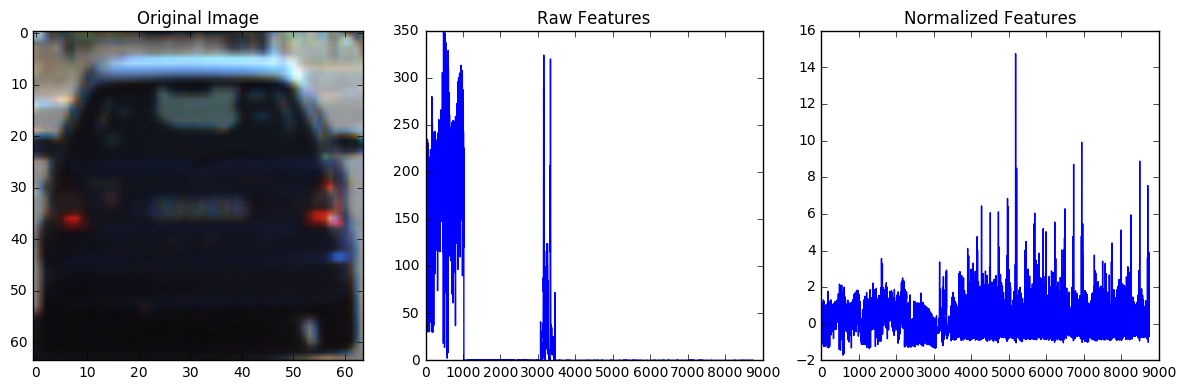

In [9]:
# Start Pipeline - Combine and Normalilze Features
car_features = extract_features(cars)
notcar_features = extract_features(notcars)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

print('Feature Vector size for Cars:', len(car_features[car_ind]))
print('Using Spatial Binning of:',BIN_SPATIAL_SIZE[0],
    'and', HIST_NBINS,'histogram bins')

In [10]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [11]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=VALIDATION_PORTION, random_state=rand_state)
print('Feature vector length:', len(X_train[0]))

Feature vector length: 8748


In [12]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = N_PREDICTIONS
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

73.04 Seconds to train SVC...
Test Accuracy of SVC =  0.9914
SVC predicts:  [ 1.  0.  1.  0.  1.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  1.  0.  1.  0.  1.  0.  1.  0.  1.  1.  1.  1.  1.  0.  0.  0.  1.  0.
  1.  0.  1.  1.  1.  0.  0.  1.  1.  0.  1.  0.  1.  1.  1.  0.  1.  1.
  1.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  1.  1.  0.  1.  1.  1.
  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.
  1.  1.  0.  0.  0.  1.  0.  0.  0.  1.]
For these 100 labels:  [ 1.  0.  1.  0.  1.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  1.  0.  1.  0.  1.  0.  1.  0.  1.  1.  1.  1.  1.  0.  0.  0.  1.  0.
  1.  0.  1.  1.  1.  0.  0.  1.  1.  0.  1.  0.  1.  1.  1.  1.  0.  1.
  1.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  1.  1.  0.  1.  1.  1.
  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.
  1.  1.  0.  0.  0.  1.  0.  0.  0.  1.]
0.04033 Seconds to predict 100 labels with SVC


In [13]:
#Save Support Vector Classifier to Datacache
def save_to_datacache(support_vector_classifier, datacache_dir=DATACACHE_DIRECTORY):
    os.makedirs(datacache_dir, exist_ok=True)
    svc_pickle = os.path.join(datacache_dir,"svc_pickle.p")
    if not os.path.exists(svc_pickle): 
        svc_hyperparameters = {'svc': svc,
                               'X_scaler':X_scaler,
                               'SPATIAL': SPATIAL, 
                               'HIST_NBINS': HIST_NBINS,
                               'COLOR_SPACE': COLOR_SPACE,
                               'HOG_ORIENTATIONS': HOG_ORIENTATIONS,
                               'HOG_PIXELS_PER_CELL': HOG_PIXELS_PER_CELL,
                               'HOG_CELLS_PER_BLOCK': HOG_CELLS_PER_BLOCK,
                               'HOG_CHANNEL': HOG_CHANNEL
                              }

        pickle.dump(svc_hyperparameters, open(svc_pickle, "wb"))
    
# Save classifier and parameters to datacache directory  
save_to_datacache(svc)

# Finished Training SVC - Now to Utilize Sliding Windows

In [14]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog

In [15]:
# Sliding Window Constants
WORKING_DIRECTORY = 'data/'
DATACACHE_DIRECTORY = os.path.join(WORKING_DIRECTORY, 'datacache/')
svc_pickle = os.path.join(DATACACHE_DIRECTORY,"svc_pickle.p")
TESTING_DATASET_DIRECTORY = 'testing_dataset/'
TESTING_PIPELINE_SETUP_DIR= 'test_images/'

testset_path = "{}{}{}".format(WORKING_DIRECTORY, TESTING_PIPELINE_SETUP_DIR, '*.jpg')


with open(svc_pickle, mode='rb') as f:
    svc_hyperparameters = pickle.load(f)
    
    
## Feature Extraction Parameters ##
# Spatial Binning
SVC = svc_hyperparameters['svc']
X_SCALER = svc_hyperparameters['X_scaler']
SPATIAL = svc_hyperparameters['SPATIAL']

BIN_SPATIAL_SIZE = (SPATIAL, SPATIAL)
# Color Histogram
HIST_NBINS = svc_hyperparameters['HIST_NBINS']
COLOR_SPACE = svc_hyperparameters['COLOR_SPACE']
# HOG Parameters
HOG_ORIENTATIONS = svc_hyperparameters['HOG_ORIENTATIONS']
HOG_PIXELS_PER_CELL = svc_hyperparameters['HOG_PIXELS_PER_CELL']
HOG_CELLS_PER_BLOCK = svc_hyperparameters['HOG_CELLS_PER_BLOCK']
HOG_CHANNEL = svc_hyperparameters['HOG_CHANNEL'] # Can be 0, 1, 2, or "ALL"

BBOX_COLOR = (0, 0, 255)
BBOX_THICK = 6

## Sliding Windows Parameters - Horizon ##
SW_XSTART_STOPS = [(None, None), (None, None), (200, 1000),(400, 1300)]
SW_YSTART_STOPS = [(420, 650), (400, 575), (375, 500), (400,556)]
SW_XY_WINDOWS = [(240, 150), (120,96), (60,48), (96,96)]
SW_XY_OVERLAPS = [(0.75, 0.55), (0.75,0.5), (0.75,0.5), (0.5,0.5)]


SW_SPATIAL_FEAT_FLAG = True
SW_HOG_FEAT_FLAG = True
SW_COLOR_HIST_FEAT_FLAG = True

In [16]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=BBOX_COLOR, thick=BBOX_THICK):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [17]:
# Define a function that takes an image, a list of start_stop positions in both x and y, 
# a list of window sizes (x and y dimensions), and a list of overlap fraction (for both x and y)
def slide_windows(img, x_start_stops=[[None, None]], y_start_stops=[[None, None]],
                 xy_windows=[(64, 64)], xy_overlaps=[(0.5, 0.5)]):

    windows = []
    for i in range(len(x_start_stops)):
        if len(x_start_stops) == len(xy_windows) and len(x_start_stops) == len(xy_overlaps):
            windows = slide_window(img, np.asarray(x_start_stops[i]), np.asarray(y_start_stops[i]),
                                np.asarray(xy_windows[i]), np.asarray(xy_overlaps[i]), windows)
        else:
            windows = slide_window(img, np.asarray(x_start_stops[i]), np.asarray(y_start_stops[i]),
                                np.asarray(xy_windows[0]), np.asarray(xy_overlaps[0]), windows)
            
    return windows

In [18]:
# Define a function that takes an image, start and stop positions in both x and y, 
# window size (x and y dimensions), and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5), window_list=[]):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
#     elif x_start_stop[0] >= img.shape[1]:
#         x_start_stop[0] = img.shape[1] - 64
        
    if x_start_stop[1] == None or x_start_stop[1] >= img.shape[1]:
        x_start_stop[1] = img.shape[1]
       
        
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
#     elif y_start_stop[0] >= img.shape[0]:
#         y_start_stop[0] = img.shape[0] - 64
    if y_start_stop[1] == None or y_start_stop[1] >= img.shape[0]:
        y_start_stop[1] = img.shape[0]


    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 

    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

In [19]:
#Define a function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

In [20]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space=COLOR_SPACE, spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [496]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, svc=SVC, X_scaler=X_SCALER, color_space=COLOR_SPACE, 
                    spatial_size=BIN_SPATIAL_SIZE, hist_bins=HIST_NBINS, 
                    orient=HOG_ORIENTATIONS, pix_per_cell=HOG_PIXELS_PER_CELL, cell_per_block=HOG_CELLS_PER_BLOCK, 
                    hog_channel=HOG_CHANNEL, spatial_feat=SW_SPATIAL_FEAT_FLAG, 
                    hist_feat=SW_COLOR_HIST_FEAT_FLAG, hog_feat=SW_HOG_FEAT_FLAG):
            
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    heatmap = np.zeros_like(img[:,:,0])    
    #2) Iterate over all windows in the list
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (DEFAULT_LENGTH, DEFAULT_WIDTH))      
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = X_scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = svc.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1: # Car detected
            on_windows.append(window)
            heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] +=1


    #8) Return windows for positive detections
    return on_windows, heatmap
    

In [497]:
# Try Scaling Windows on Test Images
image_paths = glob.glob(testset_path, recursive=True)
print('Found',len(image_paths),'images in directory:', testset_path)

Found 6 images in directory: data/test_images/*.jpg


In [498]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        #Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        #Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        #Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], BBOX_COLOR, BBOX_THICK)
    # Return the image
    return img

In [499]:
# Define a single function that can extract features using hog sub-sampling and make predictions
carslist = []
out_images = []
out_titles = []

## Sliding Windows Parameters ##
SW_XSTART_STOPS = [(None, None), (None, None), (192, 1216),(None, None), (200,None)]#, (400, 1300),(200, 1000),(400, 1300)]
SW_YSTART_STOPS = [(192, 640), (416, 640),(384, 576),(416, 640), (384, 512)]#, (500, 600), (375, 500), (400,656)]
SW_XY_WINDOWS = [(256, 128), (96,96), (128, 96), (96, 64), (64,64)]#, (96,64), (64,48), (96,96)]
SW_XY_OVERLAPS = [(0.75, 0.25),(0.750,0.50), (0.750, 0.350), (0.750, 0.500), (.75,.75)]#, (0.75,0.5), (0.75,0.5), (0.5,0.5)]


for img_path in image_paths:
    t1 = time.time()
    img = mpimg.imread(img_path)
    draw_img = np.copy(img)
    img = normalize_pixels(img).astype(np.float32)
    #Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    windows = []
    hot_windows = []
    threshold = 7
    filename = os.path.split(img_path)[-1]
    
    windows_1 = slide_windows(img, x_start_stops=SW_XSTART_STOPS, y_start_stops=SW_YSTART_STOPS, 
                           xy_windows=SW_XY_WINDOWS, 
                           xy_overlaps=SW_XY_OVERLAPS)

    hot_windows_1, heatmap = search_windows(img, windows_1, SVC, X_SCALER, color_space=COLOR_SPACE,
                                 spatial_size=BIN_SPATIAL_SIZE, hist_bins=HIST_NBINS, orient=HOG_ORIENTATIONS,
                                 pix_per_cell=HOG_PIXELS_PER_CELL, cell_per_block=HOG_CELLS_PER_BLOCK,
                                 hog_channel=HOG_CHANNEL, spatial_feat=SW_SPATIAL_FEAT_FLAG, hog_feat=SW_HOG_FEAT_FLAG,
                                 hist_feat=SW_COLOR_HIST_FEAT_FLAG)

    print('BBoxes Found:', len(hot_windows_1))
    windows.extend(windows_1)
    hot_windows.extend(hot_windows_1)
    
    window_img = draw_boxes(draw_img, hot_windows, color=BBOX_COLOR, thick=BBOX_THICK)
    
    labels = label(apply_threshold(heatmap, threshold))
    # Draw bounding boxes on a copy of the image       
    window_img_thresh = draw_labeled_bboxes(draw_img, [labels])
    
    
    out_images.append(window_img_thresh)
    out_titles.append(filename)
    out_images.append(apply_threshold(heatmap, threshold))
    out_titles.append(filename)
    
    print(time.time()-t1, 'seconds to process one image search', len(windows), 'windows')

fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

error: /Users/jenkins/miniconda/1/x64/conda-bld/work/opencv-3.1.0/modules/imgproc/src/imgwarp.cpp:3229: error: (-215) ssize.area() > 0 in function resize


# Explore HOG Sub-Sampling Window Search

We want a more efficient way to detect vehicles. This approach will allow for only a single call to get HOG features. The pipeline will then find a sub sample

In [25]:
SW_CONVERT_COLOR = 'RGB2YCrCb'
def convert_color(img, conv=SW_CONVERT_COLOR):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

0.5049028396606445 seconds to run, total windows =  5
0.5097768306732178 seconds to run, total windows =  10
0.5156018733978271 seconds to run, total windows =  15
0.520331859588623 seconds to run, total windows =  20
0.524561882019043 seconds to run, total windows =  25
0.5290658473968506 seconds to run, total windows =  30
0.5364840030670166 seconds to run, total windows =  35
0.5428338050842285 seconds to run, total windows =  40
0.5487217903137207 seconds to run, total windows =  45
0.5542738437652588 seconds to run, total windows =  50
0.5586779117584229 seconds to run, total windows =  55
0.5642008781433105 seconds to run, total windows =  60
0.5701339244842529 seconds to run, total windows =  65
0.5747618675231934 seconds to run, total windows =  70
0.5796678066253662 seconds to run, total windows =  75
0.5856189727783203 seconds to run, total windows =  80
0.5902268886566162 seconds to run, total windows =  85
0.5951178073883057 seconds to run, total windows =  90
0.60091686248

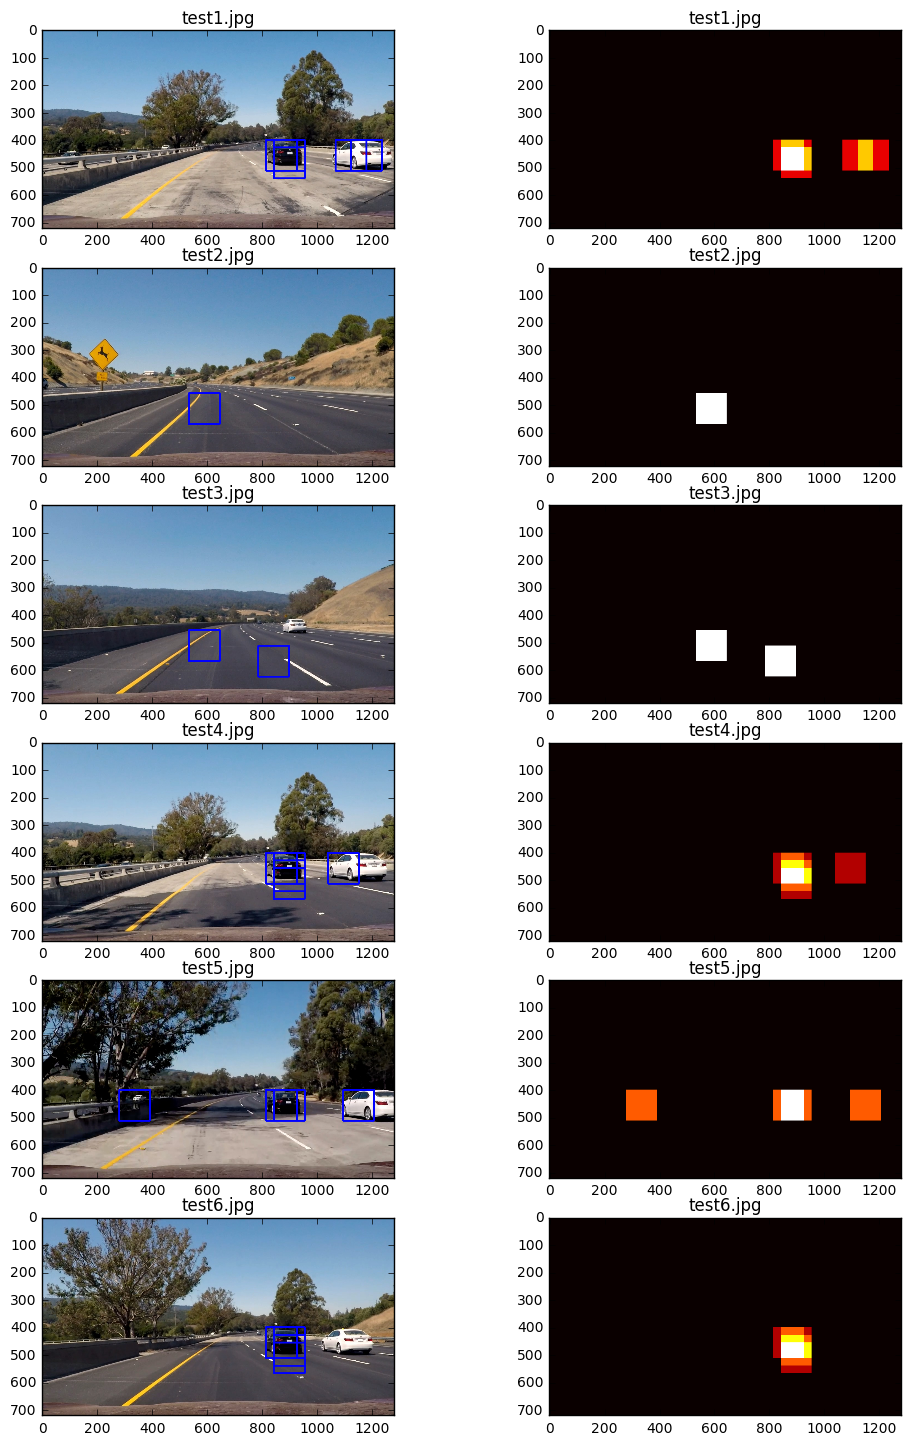

In [26]:
# Define a single function that can extract features using hog sub-sampling and make predictions
out_images = []
out_maps = []
out_titles = []
out_boxes = []

## Sliding Window Parameters - HOG Sub-Sampling ##
SW_YSTART = 400
SW_YSTOP = 665
SW_SCALE = 1.75

ystart = SW_YSTART
ystop = SW_YSTOP
scale = SW_SCALE
spatial_size=BIN_SPATIAL_SIZE
hist_bins=HIST_NBINS
orient=HOG_ORIENTATIONS
pix_per_cell=HOG_PIXELS_PER_CELL
cell_per_block=HOG_CELLS_PER_BLOCK
hog_channel=HOG_CHANNEL
spatial_feat=SW_SPATIAL_FEAT_FLAG
hog_feat=SW_HOG_FEAT_FLAG
hist_feat=SW_COLOR_HIST_FEAT_FLAG


#Iterate over the test images
for img_path in image_paths:
    img_boxes = []
    t1 = time.time()
    count = 0
    img = mpimg.imread(img_path)
    draw_img = np.copy(img)
    
    #Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = normalize_pixels(img).astype(np.float32)
    img_to_search = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_to_search, conv=SW_CONVERT_COLOR)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    window = HOG_PIXELS_PER_CELL*HOG_PIXELS_PER_CELL # 8 cells and 8 pix per cell
    nblocks_per_window = (window // pix_per_cell)-1  # The // division is used for integers (for indices)
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step # The // division is used for integers (for indices)
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step # The // division is used for integers (for indices)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)


    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            # Extract HOG for this particular patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (DEFAULT_LENGTH, DEFAULT_WIDTH))

            # Get color features
            spatial_features = bin_spatial(subimg, size=BIN_SPATIAL_SIZE)
            hist_features = color_hist(subimg, nbins=HIST_NBINS)
            
            
            test_feats = np.hstack((spatial_features, hist_features, hog_features))
            # Scale features and make a prediction
            test_features = X_SCALER.transform(test_feats.reshape(1, -1))
            test_prediction = SVC.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw, ytop_draw+win_draw+ystart),BBOX_COLOR,6)
                img_boxes.append(((xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart)))

                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] +=1
        print(time.time()-t1, 'seconds to run, total windows = ', count)

    out_images.append(draw_img)

    out_titles.append(os.path.split(img_path)[-1])
    out_titles.append(os.path.split(img_path)[-1])
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [27]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart=SW_YSTART, ystop=SW_YSTOP, scale=SW_SCALE, svc=SVC, X_scaler=X_SCALER,
              orient=HOG_ORIENTATIONS, pix_per_cell=HOG_PIXELS_PER_CELL, cell_per_block=HOG_CELLS_PER_BLOCK,
              spatial_size=BIN_SPATIAL_SIZE, hist_bins=HIST_NBINS):

    spatial_feat=SW_SPATIAL_FEAT_FLAG
    hog_feat=SW_HOG_FEAT_FLAG
    hist_feat=SW_COLOR_HIST_FEAT_FLAG
    
    # If y start/stop positions not defined, set to image size      
    if ystart == None or ystart < 0:
        ystart = 0
    if ystop == None or ystop > img.shape[0]:
        ystop = img.shape[0]

    draw_img = np.copy(img)

    #Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = normalize_pixels(img).astype(np.float32)
    img_to_search = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_to_search, conv=SW_CONVERT_COLOR)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    window = HOG_PIXELS_PER_CELL*HOG_PIXELS_PER_CELL # 8 cells and 8 pix per cell
    nblocks_per_window = (window // pix_per_cell)-1  # The // division is used for integers (for indices)
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step # The // division is used for integers (for indices)
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step # The // division is used for integers (for indices)

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)


    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            # Extract HOG for this particular patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (DEFAULT_LENGTH, DEFAULT_WIDTH))

            # Get color features
            spatial_features = bin_spatial(subimg, size=BIN_SPATIAL_SIZE)
            hist_features = color_hist(subimg, nbins=HIST_NBINS)

            test_feats = np.hstack((spatial_features, hist_features, hog_features))
            # Scale features and make a prediction
            test_features = X_scaler.transform(test_feats.reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw, ytop_draw+win_draw+ystart),BBOX_COLOR,6)
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] +=1
    return draw_img, heatmap

In [72]:
# DEFINE A CLASS TO RECEIVE THE CHARACTERISTICS OF EACH VEHICLE DETECTION
# Objects defined as "Vehicles" will be where multiple overlaping detections exists in the heatmap
class Vehicle():
    def __init__(self, bbox):
        self.prev_detected = False # Flag sets if the Vehicle was detected in the last iteration
        self.cur_detected = True # Flag sets if the Vehicle is detected in the current iteration
        self.n_detections = 1 # number of times this vehicle has been detected
        self.n_non_detections = 0 # number of consecutive times this vehicle has not been detected
        self.xpixels = np.arange(bbox[0][0], bbox[1][0]+1) # Pixel x values of last detection
        self.ypixels = np.arange(bbox[0][1], bbox[1][1]+1) # Pixel y values of last detection
        self.recent_xfitted = []
        self.recent_xfitted.append(bbox[0][0]) # x position of the last n fits of the bounding box
        self.bestx = bbox[0][0] # X position of the current fit
        self.recent_yfitted = []
        self.recent_yfitted.append(bbox[0][1]) # Y position of the last n fits of the bounding box
        self.besty = bbox[0][1] # Average y position of the current fit
        self.recent_wfitted = []
        self.recent_wfitted.append(bbox[1][0])
        self.bestw = bbox[1][0] # Average width of the last n fits
        self.recent_hfitted = []
        self.recent_hfitted.append(bbox[1][1]) # Height of the last n fits of the bounding box
        self.besth = bbox[1][1] # Average height of the last n fits
        self.bounding_box = bbox

In [122]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels, smoothing_factor=1, remove_threshold = 6):
    img = np.copy(img)
    # Set all cur_detected values to false for current frame
    for car in carslist:
        car.cur_detected = False
    
    for label in labels:
        # Iterate through all detected labels
        for car_number in range(1, label[1] + 1):
            # Find pixels with each car_number label value
            nonzero = (label[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

            # Check if bounding box appears in carslist
            found_match = False
            for car in carslist:
                # Check if car's previous pix values are 'close enough' to current bounding_box. If so, grab vehicle
                if((bbox[0][0] in car.recent_xfitted and bbox[0][1] in car.recent_yfitted and 
                   bbox[1][0] in car.recent_wfitted and bbox[1][1] in car.recent_hfitted) or 
                    (np.allclose(len(car.xpixels), len(nonzerox)) and 
                    np.allclose(len(car.ypixels), len(nonzeroy)) and 
                    np.allclose(np.ravel(car.xpixels), np.ravel(nonzerox)) and
                    np.allclose(np.ravel(car.ypixels), np.ravel(nonzeroy)))):

                    found_match = True
                    print('Found a match. Car Number', car_number, '| length nonzerox:',len(nonzerox),
                          '| length nonzeroy:',len(nonzeroy))
                    print('Bounding box:',bbox)

                    car.n_detections += 1                
                    car.prev_detected = found_match
                    car.cur_detected = found_match
                    car.n_non_detections = 0 # Reset non_detections value
                    car.xpixels = nonzerox # Pixel x values of current detection
                    car.ypixels = nonzeroy # Pixel y values of current detection
                    if car.n_detections > smoothing_factor: # Average last x values to keep best points current
                        car.recent_xfitted.append(bbox[0][0])
                        car.bestx = int(np.mean(car.recent_xfitted[:-smoothing_factor])) # Average x position of the last n fits
                        car.recent_yfitted.append(bbox[0][1]) # Y position of the last n fits of the bounding box
                        car.besty = int(np.mean(car.recent_yfitted[:-smoothing_factor])) # Average y position of the current fit
                        car.recent_wfitted.append(bbox[1][0])
                        car.bestw = int(np.mean(car.recent_wfitted[:-smoothing_factor])) # Average width of the last n fits
                        car.recent_hfitted.append(bbox[1][1]) # Height of the last n fits of the bounding box
                        car.besth = int(np.mean(car.recent_hfitted[:-smoothing_factor])) # Average height of the last n fits
                    else:
                        car.recent_xfitted.append(bbox[0][0])
                        car.bestx = int(np.mean(car.recent_xfitted)) # Average x position of the last n fits
                        car.recent_yfitted.append(bbox[0][1]) # Y position of the last n fits of the bounding box
                        car.besty = int(np.mean(car.recent_yfitted)) # Average y position of the current fit
                        car.recent_wfitted.append(bbox[1][0])
                        car.bestw = int(np.mean(car.recent_wfitted)) # Average width of the last n fits
                        car.recent_hfitted.append(bbox[1][1]) # Height of the last n fits of the bounding box
                        car.besth = int(np.mean(car.recent_hfitted)) # Average height of the last n fits

                    car.bounding_box = ((car.bestx, car.besty),
                                            (car.bestw, car.besth))
                    break

            # After searching for existing car, add new Vehicle         
            if found_match == False:
                # Add New Vehicle
                car = Vehicle(bbox)
                car.xpixels = nonzerox
                car.ypixels = nonzeroy
                car.n_non_detections +=1 
                car.prev_detected = found_match
                car.cur_detected = True

                # Add car to carslist
                carslist.append(car)
            
        
    # After searching through labels and updating carslist, draw labels
    for car in carslist:
        # Set n_non_detections+=1 for each car in carslist that wasn't prev_detected
        if (car.prev_detected == True and car.cur_detected == False):
            print('Found possible false positive for car:', car.bounding_box, 'will check against smoothing factor')
            car.prev_detected == False
            car.n_non_detections +=1
            
        if (car.n_non_detections <= smoothing_factor): #Process cars within the smoothing factor range
            cv2.rectangle(img, car.bounding_box[0], car.bounding_box[1], BBOX_COLOR, BBOX_THICK)
        else:
            # car.n_non_detections > remove_threshold:
            print('Removing Car:', car.bounding_box)
            carslist.remove(car)
        
    # Return the image
    return img

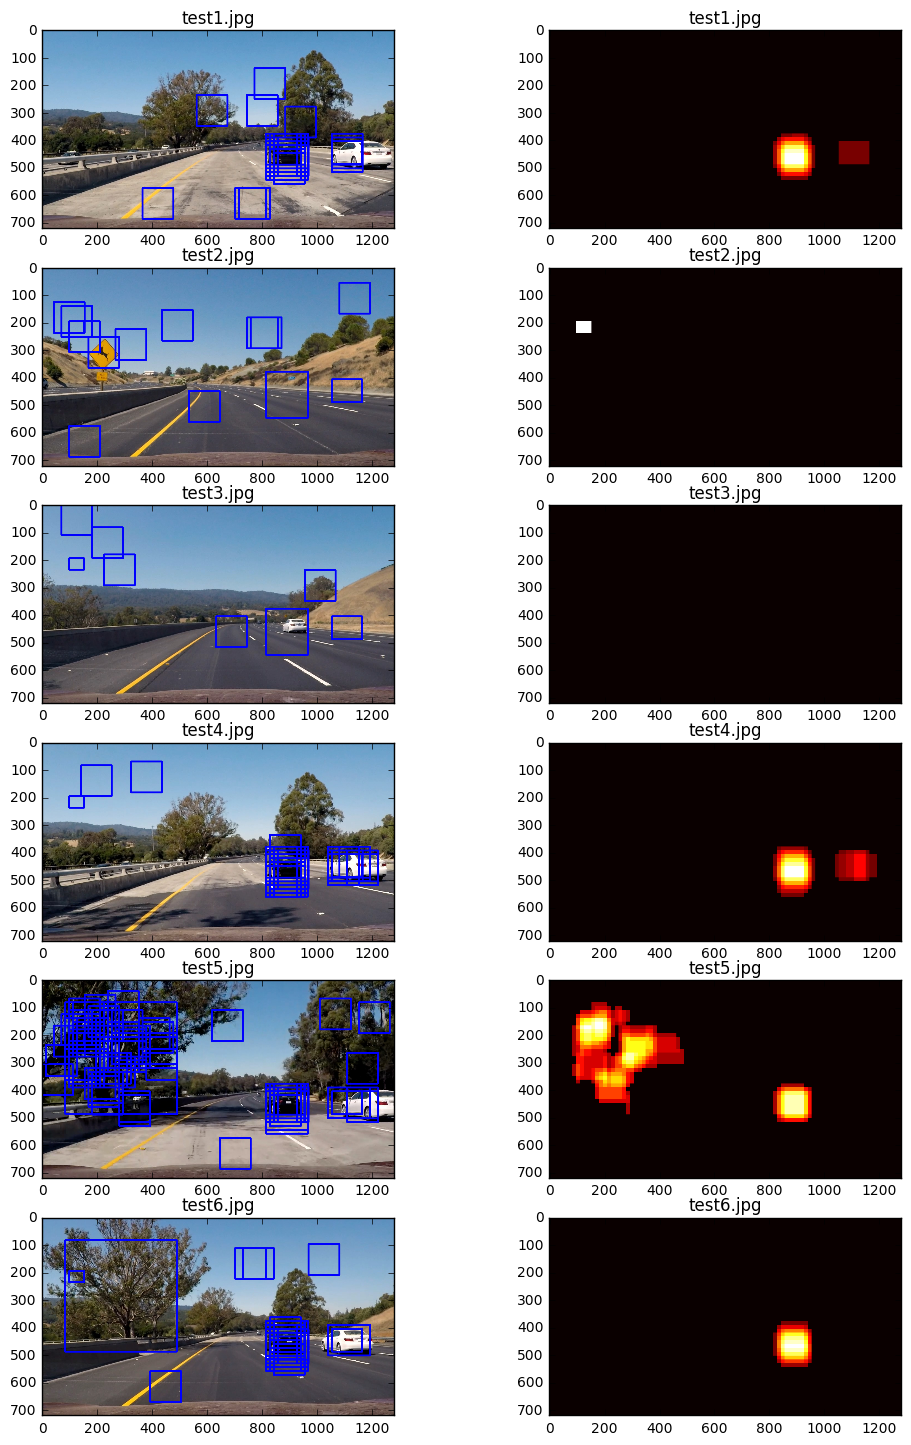

In [125]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []
carslist = []

## Sliding Window Parameters - HOG Sub-Sampling ##
SW_CONVERT_COLOR = 'RGB2YCrCb'
SW_YSTART = None
SW_YSTOP = None
SW_SCALE = 1.75
BIN_SPATIAL_SIZE = (32,32)
HIST_NBINS = 128
HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = 8
HOG_CELLS_PER_BLOCK = 2
HOG_CHANNEL = 'ALL' # Can be 0, 1, 2, or "ALL"
SW_SPATIAL_FEAT_FLAG = True
SW_HOG_FEAT_FLAG = True
SW_COLOR_HIST_FEAT_FLAG = True

#Iterate over the test images
for img_path in image_paths:
    img = mpimg.imread(img_path)
    out_img, heatmap = find_cars(img, ystart=SW_YSTART, ystop=SW_YSTOP, scale=SW_SCALE, svc=SVC, X_scaler=X_SCALER,
              orient=HOG_ORIENTATIONS, pix_per_cell=HOG_PIXELS_PER_CELL, cell_per_block=HOG_CELLS_PER_BLOCK,
              spatial_size=BIN_SPATIAL_SIZE, hist_bins=HIST_NBINS)
    labels = label(apply_threshold(heatmap, 2))
    # Draw bounding boxes on a copy of the image       
    draw_img = draw_labeled_bboxes(np.copy(out_img), [labels])
    out_images.append(draw_img)
    out_images.append(heatmap)
    filename = os.path.split(img_path)[-1]
    out_titles.append(filename)
    out_titles.append(filename)

fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [352]:
def process_image(img):
    ## Search for cars from previous frame Gather previous bboxes from carslist
    heatmap_1 = np.zeros_like(img[:,:,2])
    img = np.copy(img)       
    
    # Try sliding windows to capture wider bbox
    ## Sliding Windows Parameters ##
    SW_XSTART_STOPS = [(None, None), (None, None)]#, (192, 1216)]#,(None, None), (200,None)]
    SW_YSTART_STOPS = [(384, 640), (384, None)]#,(384, 576)]#,(416, 640), (384, 512)]
    SW_XY_WINDOWS = [(64, 64), (96,96),(128,64)]#, (64, 64)]#, (96, 64), (64,64)]
    SW_XY_OVERLAPS = [(0.50, 0.50),(.50,.50),(.50,.50)]#, (0.50, 0.50)]#, (0.750, 0.500), (.75,.75)] 

    ## Alternative - Use Sliding windows primariliy
    threshold = 5
    labels = []
    windows_1 = slide_windows(img, x_start_stops=SW_XSTART_STOPS, y_start_stops=SW_YSTART_STOPS, 
                           xy_windows=SW_XY_WINDOWS, 
                           xy_overlaps=SW_XY_OVERLAPS)

    hot_windows_1, heatmap_1 = search_windows(img, windows_1, SVC, X_SCALER, color_space=COLOR_SPACE,
                                 spatial_size=BIN_SPATIAL_SIZE, hist_bins=HIST_NBINS, orient=HOG_ORIENTATIONS,
                                 pix_per_cell=HOG_PIXELS_PER_CELL, cell_per_block=HOG_CELLS_PER_BLOCK,
                                 hog_channel=HOG_CHANNEL, spatial_feat=SW_SPATIAL_FEAT_FLAG, hog_feat=SW_HOG_FEAT_FLAG,
                                 hist_feat=SW_COLOR_HIST_FEAT_FLAG)
    labels.append(label(apply_threshold(heatmap_1, threshold)))
    
#    draw_img = draw_labeled_bboxes(np.copy(img), labels, smoothing_factor=6)
    
    ## Search for cars using HOG subsampling (in current frame)
    SW_YSTART = 384
    SW_YSTOP = None
    SW_SCALE = 1.75
    _, heatmap_2 = find_cars(img, ystart=SW_YSTART, ystop=SW_YSTOP, scale=SW_SCALE, svc=SVC, X_scaler=X_SCALER,
              orient=HOG_ORIENTATIONS, pix_per_cell=HOG_PIXELS_PER_CELL, cell_per_block=HOG_CELLS_PER_BLOCK,
              spatial_size=BIN_SPATIAL_SIZE, hist_bins=HIST_NBINS)
    #heatmap = np.add(heatmap_1, heatmap_2)
    labels.append(label(apply_threshold(heatmap_2, 4)))
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels, smoothing_factor=2)
    return draw_img

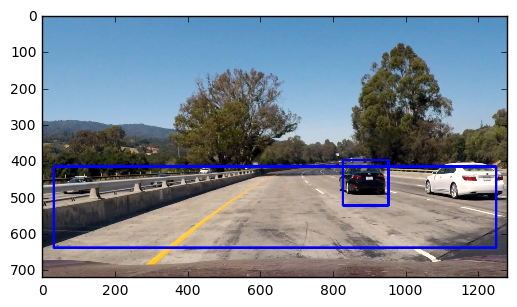

In [353]:
carslist = []
out_img = process_image(mpimg.imread(image_paths[0])) # For Debugging # 
plt.imshow(out_img)

In [338]:
#Import packages to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# SW_YSTART = None #384
# SW_YSTOP = None #640
# SW_SCALE = 1.75

test_ouput = 'test_output.mp4'
VIDEO_OUTPUT_PATH = os.path.join(WORKING_DIRECTORY, test_ouput)

TEST_VIDEO = 'test_video.mp4'
PROJECT_VIDEO = 'project_video.mp4'
VIDEO_FILE_PATH = os.path.join(WORKING_DIRECTORY, TEST_VIDEO)
clip = VideoFileClip(VIDEO_FILE_PATH)
carslist = []
test_clip = clip.fl_image(process_image)
#%time
test_clip.write_videofile(VIDEO_OUTPUT_PATH, audio=False)

HTML("""
<video width="960" height="540" controls>
 <source src="{0}">
</video>
""".format(VIDEO_OUTPUT_PATH))

[MoviePy] >>>> Building video data/test_output.mp4
[MoviePy] Writing video data/test_output.mp4



  0%|          | 0/39 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Process Project Video

In [64]:
project_ouput = 'project_output.mp4'
PROJECT_VIDEO = 'project_video.mp4'
VIDEO_FILE_PATH = os.path.join(WORKING_DIRECTORY, PROJECT_VIDEO)
VIDEO_OUTPUT_PATH = os.path.join(WORKING_DIRECTORY, project_ouput)

carslist = []
clip = VideoFileClip(VIDEO_FILE_PATH)
project_clip = clip.fl_image(process_image)
project_clip.write_videofile(VIDEO_OUTPUT_PATH, audio=False)

[MoviePy] >>>> Building video data/project_output.mp4
[MoviePy] Writing video data/project_output.mp4







  0%|          | 0/1261 [00:00<?, ?it/s]




  0%|          | 1/1261 [00:03<1:16:27,  3.64s/it]




  0%|          | 2/1261 [00:07<1:16:17,  3.64s/it]




  0%|          | 3/1261 [00:10<1:15:53,  3.62s/it]




  0%|          | 4/1261 [00:14<1:15:51,  3.62s/it]




  0%|          | 5/1261 [00:18<1:15:40,  3.62s/it]




  0%|          | 6/1261 [00:21<1:15:23,  3.60s/it]




  1%|          | 7/1261 [00:25<1:14:55,  3.59s/it]




  1%|          | 8/1261 [00:28<1:14:56,  3.59s/it]




  1%|          | 9/1261 [00:32<1:15:09,  3.60s/it]




  1%|          | 10/1261 [00:35<1:14:44,  3.59s/it]




  1%|          | 11/1261 [00:39<1:14:38,  3.58s/it]




  1%|          | 12/1261 [00:43<1:14:44,  3.59s/it]




  1%|          | 13/1261 [00:46<1:14:49,  3.60s/it]

Found a match. Car Number 1 | length nonzerox: 19600 | length nonzeroy: 19600
Bounding box: ((420, 462), (629, 671))







  1%|          | 14/1261 [00:50<1:14:35,  3.59s/it]




  1%|          | 15/1261 [00:53<1:14:18,  3.58s/it]

Found a match. Car Number 1 | length nonzerox: 24500 | length nonzeroy: 24500
Bounding box: ((406, 462), (629, 671))







  1%|▏         | 16/1261 [00:57<1:14:29,  3.59s/it]




  1%|▏         | 17/1261 [01:01<1:14:28,  3.59s/it]




  1%|▏         | 18/1261 [01:04<1:14:08,  3.58s/it]




  2%|▏         | 19/1261 [01:08<1:14:01,  3.58s/it]




  2%|▏         | 20/1261 [01:11<1:13:59,  3.58s/it]




  2%|▏         | 21/1261 [01:15<1:14:14,  3.59s/it]




  2%|▏         | 22/1261 [01:18<1:13:56,  3.58s/it]




  2%|▏         | 23/1261 [01:22<1:14:02,  3.59s/it]




  2%|▏         | 24/1261 [01:26<1:13:38,  3.57s/it]

Found a match. Car Number 1 | length nonzerox: 9996 | length nonzeroy: 9996
Bounding box: ((518, 462), (629, 559))







  2%|▏         | 25/1261 [01:29<1:13:31,  3.57s/it]




  2%|▏         | 26/1261 [01:33<1:13:15,  3.56s/it]




  2%|▏         | 27/1261 [01:36<1:13:04,  3.55s/it]




  2%|▏         | 28/1261 [01:40<1:12:54,  3.55s/it]




  2%|▏         | 29/1261 [01:43<1:12:43,  3.54s/it]




  2%|▏         | 30/1261 [01:47<1:12:25,  3.53s/it]




  2%|▏         | 31/1261 [01:50<1:12:14,  3.52s/it]




  3%|▎         | 32/1261 [01:54<1:12:28,  3.54s/it]




  3%|▎         | 33/1261 [01:57<1:12:24,  3.54s/it]

Found a match. Car Number 1 | length nonzerox: 35280 | length nonzeroy: 35280
Bounding box: ((392, 448), (643, 685))







  3%|▎         | 34/1261 [02:01<1:12:36,  3.55s/it]




  3%|▎         | 35/1261 [02:05<1:12:33,  3.55s/it]




  3%|▎         | 36/1261 [02:08<1:12:32,  3.55s/it]




  3%|▎         | 37/1261 [02:12<1:12:15,  3.54s/it]




  3%|▎         | 38/1261 [02:15<1:12:03,  3.54s/it]




  3%|▎         | 39/1261 [02:19<1:12:33,  3.56s/it]




  3%|▎         | 40/1261 [02:22<1:12:45,  3.58s/it]




  3%|▎         | 41/1261 [02:26<1:12:25,  3.56s/it]




  3%|▎         | 42/1261 [02:29<1:12:18,  3.56s/it]




  3%|▎         | 43/1261 [02:33<1:12:31,  3.57s/it]




  3%|▎         | 44/1261 [02:37<1:12:17,  3.56s/it]




  4%|▎         | 45/1261 [02:40<1:12:04,  3.56s/it]

Found a match. Car Number 3 | length nonzerox: 31360 | length nonzeroy: 31360
Bounding box: ((392, 448), (643, 685))







  4%|▎         | 46/1261 [02:44<1:12:10,  3.56s/it]




  4%|▎         | 47/1261 [02:47<1:12:36,  3.59s/it]

Found a match. Car Number 2 | length nonzerox: 36456 | length nonzeroy: 36456
Bounding box: ((392, 448), (643, 685))







  4%|▍         | 48/1261 [02:51<1:12:45,  3.60s/it]




  4%|▍         | 49/1261 [02:55<1:12:13,  3.58s/it]




  4%|▍         | 50/1261 [02:58<1:12:48,  3.61s/it]




  4%|▍         | 51/1261 [03:02<1:12:47,  3.61s/it]




  4%|▍         | 52/1261 [03:05<1:12:36,  3.60s/it]




  4%|▍         | 53/1261 [03:09<1:11:59,  3.58s/it]




  4%|▍         | 54/1261 [03:13<1:11:55,  3.58s/it]




  4%|▍         | 55/1261 [03:16<1:12:24,  3.60s/it]




  4%|▍         | 56/1261 [03:20<1:12:16,  3.60s/it]

Found a match. Car Number 1 | length nonzerox: 33124 | length nonzeroy: 33124
Bounding box: ((406, 448), (643, 671))







  5%|▍         | 57/1261 [03:23<1:11:57,  3.59s/it]




  5%|▍         | 58/1261 [03:27<1:11:44,  3.58s/it]




  5%|▍         | 59/1261 [03:30<1:11:45,  3.58s/it]

Found a match. Car Number 1 | length nonzerox: 28812 | length nonzeroy: 28812
Bounding box: ((392, 462), (629, 685))







  5%|▍         | 60/1261 [03:34<1:11:50,  3.59s/it]

Found a match. Car Number 1 | length nonzerox: 29792 | length nonzeroy: 29792
Bounding box: ((406, 448), (643, 671))







  5%|▍         | 61/1261 [03:38<1:11:41,  3.58s/it]

Found a match. Car Number 1 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((532, 462), (629, 545))







  5%|▍         | 62/1261 [03:41<1:11:28,  3.58s/it]




  5%|▍         | 63/1261 [03:45<1:11:18,  3.57s/it]




  5%|▌         | 64/1261 [03:49<1:14:59,  3.76s/it]




  5%|▌         | 65/1261 [03:53<1:14:06,  3.72s/it]




  5%|▌         | 66/1261 [03:56<1:13:11,  3.67s/it]




  5%|▌         | 67/1261 [04:00<1:12:41,  3.65s/it]




  5%|▌         | 68/1261 [04:03<1:12:18,  3.64s/it]

Found a match. Car Number 1 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((532, 462), (629, 545))







  5%|▌         | 69/1261 [04:07<1:11:43,  3.61s/it]

Found a match. Car Number 1 | length nonzerox: 18228 | length nonzeroy: 18228
Bounding box: ((490, 462), (643, 601))







  6%|▌         | 70/1261 [04:11<1:11:34,  3.61s/it]




  6%|▌         | 71/1261 [04:14<1:11:42,  3.62s/it]




  6%|▌         | 72/1261 [04:18<1:11:22,  3.60s/it]




  6%|▌         | 73/1261 [04:21<1:11:11,  3.60s/it]




  6%|▌         | 74/1261 [04:25<1:10:51,  3.58s/it]




  6%|▌         | 75/1261 [04:28<1:10:45,  3.58s/it]




  6%|▌         | 76/1261 [04:32<1:10:45,  3.58s/it]




  6%|▌         | 77/1261 [04:36<1:10:22,  3.57s/it]




  6%|▌         | 78/1261 [04:39<1:10:06,  3.56s/it]




  6%|▋         | 79/1261 [04:43<1:10:07,  3.56s/it]




  6%|▋         | 80/1261 [04:46<1:10:02,  3.56s/it]




  6%|▋         | 81/1261 [04:50<1:09:43,  3.55s/it]




  7%|▋         | 82/1261 [04:53<1:10:02,  3.56s/it]




  7%|▋         | 83/1261 [04:57<1:10:00,  3.57s/it]




  7%|▋         | 84/1261 [05:00<1:09:58,  3.57s/it]




  7%|▋         | 85/1261 [05:04<1:09:43,  3.56s/it]




  7%|▋         | 86/1261 [05:08<1:09:45,  3.56s/it]




  7%|▋         | 87/1261 [05:11<1:09:41,  3

Found a match. Car Number 1 | length nonzerox: 11760 | length nonzeroy: 11760
Bounding box: ((532, 448), (643, 559))







  7%|▋         | 89/1261 [05:18<1:09:20,  3.55s/it]




  7%|▋         | 90/1261 [05:22<1:09:29,  3.56s/it]




  7%|▋         | 91/1261 [05:25<1:09:31,  3.57s/it]




  7%|▋         | 92/1261 [05:29<1:09:19,  3.56s/it]




  7%|▋         | 93/1261 [05:32<1:09:12,  3.56s/it]




  7%|▋         | 94/1261 [05:36<1:09:12,  3.56s/it]




  8%|▊         | 95/1261 [05:40<1:09:19,  3.57s/it]




  8%|▊         | 96/1261 [05:43<1:09:01,  3.55s/it]




  8%|▊         | 97/1261 [05:47<1:09:07,  3.56s/it]




  8%|▊         | 98/1261 [05:50<1:09:01,  3.56s/it]

Found a match. Car Number 1 | length nonzerox: 33908 | length nonzeroy: 33908
Bounding box: ((406, 434), (657, 671))







  8%|▊         | 99/1261 [05:54<1:09:05,  3.57s/it]




  8%|▊         | 100/1261 [05:57<1:08:46,  3.55s/it]




  8%|▊         | 101/1261 [06:01<1:08:53,  3.56s/it]




  8%|▊         | 102/1261 [06:05<1:08:45,  3.56s/it]




  8%|▊         | 103/1261 [06:08<1:08:44,  3.56s/it]




  8%|▊         | 104/1261 [06:12<1:08:25,  3.55s/it]




  8%|▊         | 105/1261 [06:15<1:08:24,  3.55s/it]




  8%|▊         | 106/1261 [06:19<1:08:15,  3.55s/it]




  8%|▊         | 107/1261 [06:22<1:08:17,  3.55s/it]




  9%|▊         | 108/1261 [06:26<1:08:01,  3.54s/it]




  9%|▊         | 109/1261 [06:29<1:08:10,  3.55s/it]




  9%|▊         | 110/1261 [06:33<1:08:09,  3.55s/it]




  9%|▉         | 111/1261 [06:36<1:08:05,  3.55s/it]

Found a match. Car Number 1 | length nonzerox: 28028 | length nonzeroy: 28028
Bounding box: ((392, 462), (629, 671))







  9%|▉         | 112/1261 [06:40<1:07:54,  3.55s/it]




  9%|▉         | 113/1261 [06:44<1:08:07,  3.56s/it]




  9%|▉         | 114/1261 [06:47<1:08:07,  3.56s/it]

Found a match. Car Number 2 | length nonzerox: 12740 | length nonzeroy: 12740
Bounding box: ((532, 448), (643, 573))







  9%|▉         | 115/1261 [06:51<1:08:12,  3.57s/it]




  9%|▉         | 116/1261 [06:54<1:08:04,  3.57s/it]




  9%|▉         | 117/1261 [06:58<1:08:01,  3.57s/it]




  9%|▉         | 118/1261 [07:01<1:07:58,  3.57s/it]




  9%|▉         | 119/1261 [07:05<1:07:44,  3.56s/it]

Found a match. Car Number 2 | length nonzerox: 32732 | length nonzeroy: 32732
Bounding box: ((392, 462), (629, 685))







 10%|▉         | 120/1261 [07:09<1:08:04,  3.58s/it]




 10%|▉         | 121/1261 [07:12<1:08:02,  3.58s/it]




 10%|▉         | 122/1261 [07:16<1:08:04,  3.59s/it]




 10%|▉         | 123/1261 [07:19<1:07:35,  3.56s/it]

Found a match. Car Number 1 | length nonzerox: 14112 | length nonzeroy: 14112
Bounding box: ((518, 448), (643, 573))







 10%|▉         | 124/1261 [07:23<1:07:37,  3.57s/it]




 10%|▉         | 125/1261 [07:26<1:07:34,  3.57s/it]

Found a match. Car Number 1 | length nonzerox: 35280 | length nonzeroy: 35280
Bounding box: ((392, 448), (643, 685))







 10%|▉         | 126/1261 [07:30<1:07:44,  3.58s/it]




 10%|█         | 127/1261 [07:34<1:08:17,  3.61s/it]




 10%|█         | 128/1261 [07:38<1:11:45,  3.80s/it]

Found a match. Car Number 1 | length nonzerox: 12152 | length nonzeroy: 12152
Bounding box: ((532, 448), (643, 559))







 10%|█         | 129/1261 [07:42<1:10:47,  3.75s/it]




 10%|█         | 130/1261 [07:45<1:09:40,  3.70s/it]




 10%|█         | 131/1261 [07:49<1:08:47,  3.65s/it]

Found a match. Car Number 1 | length nonzerox: 27440 | length nonzeroy: 27440
Bounding box: ((406, 448), (643, 671))







 10%|█         | 132/1261 [07:52<1:08:12,  3.63s/it]

Found a match. Car Number 1 | length nonzerox: 30968 | length nonzeroy: 30968
Bounding box: ((406, 448), (657, 671))







 11%|█         | 133/1261 [07:56<1:07:55,  3.61s/it]




 11%|█         | 134/1261 [07:59<1:07:32,  3.60s/it]




 11%|█         | 135/1261 [08:03<1:07:08,  3.58s/it]

Found a match. Car Number 1 | length nonzerox: 36260 | length nonzeroy: 36260
Bounding box: ((406, 434), (657, 671))







 11%|█         | 136/1261 [08:07<1:07:01,  3.58s/it]




 11%|█         | 137/1261 [08:10<1:06:51,  3.57s/it]




 11%|█         | 138/1261 [08:14<1:06:47,  3.57s/it]




 11%|█         | 139/1261 [08:17<1:06:46,  3.57s/it]

Found a match. Car Number 1 | length nonzerox: 28420 | length nonzeroy: 28420
Bounding box: ((420, 448), (643, 657))







 11%|█         | 140/1261 [08:21<1:06:46,  3.57s/it]




 11%|█         | 141/1261 [08:24<1:06:52,  3.58s/it]

Found a match. Car Number 1 | length nonzerox: 10584 | length nonzeroy: 10584
Bounding box: ((532, 448), (643, 559))







 11%|█▏        | 142/1261 [08:28<1:06:53,  3.59s/it]




 11%|█▏        | 143/1261 [08:32<1:06:49,  3.59s/it]




 11%|█▏        | 144/1261 [08:35<1:06:42,  3.58s/it]




 11%|█▏        | 145/1261 [08:39<1:06:39,  3.58s/it]




 12%|█▏        | 146/1261 [08:42<1:06:32,  3.58s/it]




 12%|█▏        | 147/1261 [08:46<1:06:19,  3.57s/it]




 12%|█▏        | 148/1261 [08:50<1:09:25,  3.74s/it]

Found a match. Car Number 2 | length nonzerox: 10584 | length nonzeroy: 10584
Bounding box: ((392, 574), (503, 671))







 12%|█▏        | 149/1261 [08:54<1:08:23,  3.69s/it]




 12%|█▏        | 150/1261 [08:57<1:07:29,  3.65s/it]




 12%|█▏        | 151/1261 [09:01<1:06:57,  3.62s/it]

Found a match. Car Number 2 | length nonzerox: 12152 | length nonzeroy: 12152
Bounding box: ((532, 448), (643, 559))







 12%|█▏        | 152/1261 [09:04<1:06:38,  3.61s/it]




 12%|█▏        | 153/1261 [09:08<1:06:18,  3.59s/it]




 12%|█▏        | 154/1261 [09:11<1:05:58,  3.58s/it]




 12%|█▏        | 155/1261 [09:15<1:05:46,  3.57s/it]




 12%|█▏        | 156/1261 [09:18<1:05:37,  3.56s/it]




 12%|█▏        | 157/1261 [09:22<1:05:37,  3.57s/it]

Found a match. Car Number 1 | length nonzerox: 24696 | length nonzeroy: 24696
Bounding box: ((406, 448), (629, 657))







 13%|█▎        | 158/1261 [09:26<1:05:36,  3.57s/it]




 13%|█▎        | 159/1261 [09:29<1:05:21,  3.56s/it]

Found a match. Car Number 1 | length nonzerox: 29792 | length nonzeroy: 29792
Bounding box: ((406, 448), (643, 671))







 13%|█▎        | 160/1261 [09:33<1:05:24,  3.56s/it]

Found a match. Car Number 1 | length nonzerox: 30380 | length nonzeroy: 30380
Bounding box: ((406, 448), (643, 671))







 13%|█▎        | 161/1261 [09:36<1:05:37,  3.58s/it]

Found a match. Car Number 1 | length nonzerox: 12152 | length nonzeroy: 12152
Bounding box: ((532, 448), (643, 559))







 13%|█▎        | 162/1261 [09:40<1:05:25,  3.57s/it]




 13%|█▎        | 163/1261 [09:43<1:05:00,  3.55s/it]




 13%|█▎        | 164/1261 [09:47<1:05:06,  3.56s/it]




 13%|█▎        | 165/1261 [09:51<1:05:07,  3.57s/it]




 13%|█▎        | 166/1261 [09:54<1:05:03,  3.56s/it]




 13%|█▎        | 167/1261 [09:58<1:04:45,  3.55s/it]




 13%|█▎        | 168/1261 [10:01<1:04:52,  3.56s/it]

Found a match. Car Number 1 | length nonzerox: 32536 | length nonzeroy: 32536
Bounding box: ((392, 448), (643, 685))







 13%|█▎        | 169/1261 [10:05<1:05:08,  3.58s/it]




 13%|█▎        | 170/1261 [10:08<1:04:59,  3.57s/it]

Found a match. Car Number 1 | length nonzerox: 24696 | length nonzeroy: 24696
Bounding box: ((392, 490), (587, 671))







 14%|█▎        | 171/1261 [10:12<1:04:41,  3.56s/it]

Found a match. Car Number 1 | length nonzerox: 18228 | length nonzeroy: 18228
Bounding box: ((392, 532), (545, 685))







 14%|█▎        | 172/1261 [10:16<1:04:45,  3.57s/it]




 14%|█▎        | 173/1261 [10:19<1:04:46,  3.57s/it]

Found a match. Car Number 1 | length nonzerox: 29400 | length nonzeroy: 29400
Bounding box: ((392, 462), (629, 671))







 14%|█▍        | 174/1261 [10:23<1:04:48,  3.58s/it]




 14%|█▍        | 175/1261 [10:26<1:04:35,  3.57s/it]




 14%|█▍        | 176/1261 [10:30<1:04:29,  3.57s/it]




 14%|█▍        | 177/1261 [10:33<1:04:27,  3.57s/it]




 14%|█▍        | 178/1261 [10:37<1:04:11,  3.56s/it]




 14%|█▍        | 179/1261 [10:40<1:04:08,  3.56s/it]




 14%|█▍        | 180/1261 [10:44<1:04:08,  3.56s/it]




 14%|█▍        | 181/1261 [10:48<1:04:04,  3.56s/it]




 14%|█▍        | 182/1261 [10:51<1:03:57,  3.56s/it]




 15%|█▍        | 183/1261 [10:55<1:03:36,  3.54s/it]




 15%|█▍        | 184/1261 [10:58<1:03:33,  3.54s/it]




 15%|█▍        | 185/1261 [11:02<1:03:31,  3.54s/it]




 15%|█▍        | 186/1261 [11:05<1:03:17,  3.53s/it]




 15%|█▍        | 187/1261 [11:09<1:03:29,  3.55s/it]




 15%|█▍        | 188/1261 [11:12<1:03:19,  3.54s/it]

Found a match. Car Number 1 | length nonzerox: 9604 | length nonzeroy: 9604
Bounding box: ((1106, 406), (1203, 503))







 15%|█▍        | 189/1261 [11:16<1:03:30,  3.55s/it]




 15%|█▌        | 190/1261 [11:19<1:03:18,  3.55s/it]

Found a match. Car Number 1 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((1106, 406), (1189, 503))
Found a match. Car Number 2 | length nonzerox: 28420 | length nonzeroy: 28420
Bounding box: ((378, 462), (629, 685))







 15%|█▌        | 191/1261 [11:23<1:03:28,  3.56s/it]

Found a match. Car Number 1 | length nonzerox: 9604 | length nonzeroy: 9604
Bounding box: ((1106, 406), (1203, 503))
Found a match. Car Number 2 | length nonzerox: 22736 | length nonzeroy: 22736
Bounding box: ((406, 462), (629, 671))







 15%|█▌        | 192/1261 [11:27<1:03:36,  3.57s/it]

Found a match. Car Number 1 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((1106, 406), (1189, 503))







 15%|█▌        | 193/1261 [11:30<1:03:45,  3.58s/it]

Found a match. Car Number 1 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((1106, 406), (1189, 503))







 15%|█▌        | 194/1261 [11:34<1:03:25,  3.57s/it]




 15%|█▌        | 195/1261 [11:37<1:03:19,  3.56s/it]




 16%|█▌        | 196/1261 [11:41<1:03:19,  3.57s/it]




 16%|█▌        | 197/1261 [11:44<1:03:16,  3.57s/it]




 16%|█▌        | 198/1261 [11:48<1:03:02,  3.56s/it]

Found a match. Car Number 1 | length nonzerox: 31164 | length nonzeroy: 31164
Bounding box: ((392, 462), (629, 671))







 16%|█▌        | 199/1261 [11:52<1:03:05,  3.56s/it]




 16%|█▌        | 200/1261 [11:55<1:02:57,  3.56s/it]




 16%|█▌        | 201/1261 [11:59<1:02:44,  3.55s/it]

Found a match. Car Number 1 | length nonzerox: 17444 | length nonzeroy: 17444
Bounding box: ((476, 462), (615, 615))







 16%|█▌        | 202/1261 [12:02<1:02:45,  3.56s/it]




 16%|█▌        | 203/1261 [12:06<1:02:39,  3.55s/it]




 16%|█▌        | 204/1261 [12:09<1:02:31,  3.55s/it]




 16%|█▋        | 205/1261 [12:13<1:02:26,  3.55s/it]




 16%|█▋        | 206/1261 [12:16<1:02:21,  3.55s/it]




 16%|█▋        | 207/1261 [12:20<1:02:26,  3.55s/it]




 16%|█▋        | 208/1261 [12:24<1:02:26,  3.56s/it]

Found a match. Car Number 1 | length nonzerox: 8624 | length nonzeroy: 8624
Bounding box: ((1078, 406), (1175, 503))







 17%|█▋        | 209/1261 [12:27<1:02:16,  3.55s/it]

Found a match. Car Number 1 | length nonzerox: 27832 | length nonzeroy: 27832
Bounding box: ((392, 462), (629, 671))







 17%|█▋        | 210/1261 [12:31<1:02:23,  3.56s/it]

Found a match. Car Number 1 | length nonzerox: 35084 | length nonzeroy: 35084
Bounding box: ((378, 448), (629, 685))







 17%|█▋        | 211/1261 [12:34<1:02:20,  3.56s/it]




 17%|█▋        | 212/1261 [12:38<1:02:11,  3.56s/it]




 17%|█▋        | 213/1261 [12:41<1:02:07,  3.56s/it]

Found a match. Car Number 1 | length nonzerox: 9604 | length nonzeroy: 9604
Bounding box: ((1078, 406), (1175, 503))







 17%|█▋        | 214/1261 [12:45<1:02:12,  3.57s/it]

Found a match. Car Number 1 | length nonzerox: 9604 | length nonzeroy: 9604
Bounding box: ((1078, 406), (1175, 503))







 17%|█▋        | 215/1261 [12:49<1:02:12,  3.57s/it]

Found a match. Car Number 1 | length nonzerox: 9604 | length nonzeroy: 9604
Bounding box: ((1078, 406), (1175, 503))







 17%|█▋        | 216/1261 [12:52<1:02:17,  3.58s/it]

Found a match. Car Number 1 | length nonzerox: 9604 | length nonzeroy: 9604
Bounding box: ((1078, 406), (1175, 503))







 17%|█▋        | 217/1261 [12:56<1:02:00,  3.56s/it]




 17%|█▋        | 218/1261 [12:59<1:02:07,  3.57s/it]




 17%|█▋        | 219/1261 [13:03<1:02:02,  3.57s/it]




 17%|█▋        | 220/1261 [13:06<1:02:04,  3.58s/it]




 18%|█▊        | 221/1261 [13:10<1:01:42,  3.56s/it]




 18%|█▊        | 222/1261 [13:14<1:02:41,  3.62s/it]

Found a match. Car Number 2 | length nonzerox: 28812 | length nonzeroy: 28812
Bounding box: ((392, 476), (587, 685))







 18%|█▊        | 223/1261 [13:18<1:05:44,  3.80s/it]




 18%|█▊        | 224/1261 [13:22<1:04:51,  3.75s/it]

Found a match. Car Number 2 | length nonzerox: 14308 | length nonzeroy: 14308
Bounding box: ((378, 560), (503, 685))







 18%|█▊        | 225/1261 [13:25<1:03:42,  3.69s/it]




 18%|█▊        | 226/1261 [13:29<1:02:51,  3.64s/it]




 18%|█▊        | 227/1261 [13:32<1:02:23,  3.62s/it]




 18%|█▊        | 228/1261 [13:36<1:01:57,  3.60s/it]




 18%|█▊        | 229/1261 [13:39<1:01:32,  3.58s/it]




 18%|█▊        | 230/1261 [13:43<1:01:19,  3.57s/it]




 18%|█▊        | 231/1261 [13:46<1:01:10,  3.56s/it]




 18%|█▊        | 232/1261 [13:50<1:01:06,  3.56s/it]




 18%|█▊        | 233/1261 [13:53<1:00:53,  3.55s/it]




 19%|█▊        | 234/1261 [13:57<1:00:53,  3.56s/it]




 19%|█▊        | 235/1261 [14:01<1:00:48,  3.56s/it]




 19%|█▊        | 236/1261 [14:04<1:00:41,  3.55s/it]

Found a match. Car Number 1 | length nonzerox: 10192 | length nonzeroy: 10192
Bounding box: ((532, 448), (643, 559))







 19%|█▉        | 237/1261 [14:08<1:00:39,  3.55s/it]




 19%|█▉        | 238/1261 [14:11<1:00:29,  3.55s/it]




 19%|█▉        | 239/1261 [14:15<1:00:29,  3.55s/it]




 19%|█▉        | 240/1261 [14:18<1:00:24,  3.55s/it]




 19%|█▉        | 241/1261 [14:22<1:00:23,  3.55s/it]




 19%|█▉        | 242/1261 [14:25<1:00:22,  3.55s/it]




 19%|█▉        | 243/1261 [14:29<1:00:27,  3.56s/it]

Found a match. Car Number 3 | length nonzerox: 15680 | length nonzeroy: 15680
Bounding box: ((378, 532), (517, 671))







 19%|█▉        | 244/1261 [14:33<1:03:35,  3.75s/it]




 19%|█▉        | 245/1261 [14:37<1:02:32,  3.69s/it]

Found a match. Car Number 1 | length nonzerox: 12544 | length nonzeroy: 12544
Bounding box: ((1036, 392), (1147, 503))







 20%|█▉        | 246/1261 [14:40<1:01:52,  3.66s/it]

Found a match. Car Number 1 | length nonzerox: 10388 | length nonzeroy: 10388
Bounding box: ((1036, 392), (1147, 503))







 20%|█▉        | 247/1261 [14:44<1:01:39,  3.65s/it]




 20%|█▉        | 248/1261 [14:48<1:01:13,  3.63s/it]

Found a match. Car Number 1 | length nonzerox: 10584 | length nonzeroy: 10584
Bounding box: ((1050, 392), (1147, 503))







 20%|█▉        | 249/1261 [14:51<1:00:57,  3.61s/it]

Found a match. Car Number 1 | length nonzerox: 10584 | length nonzeroy: 10584
Bounding box: ((1050, 392), (1147, 503))







 20%|█▉        | 250/1261 [14:55<1:00:33,  3.59s/it]

Found a match. Car Number 1 | length nonzerox: 10584 | length nonzeroy: 10584
Bounding box: ((1050, 392), (1147, 503))







 20%|█▉        | 251/1261 [14:58<1:00:23,  3.59s/it]

Found a match. Car Number 1 | length nonzerox: 10584 | length nonzeroy: 10584
Bounding box: ((1050, 392), (1147, 503))







 20%|█▉        | 252/1261 [15:02<1:00:13,  3.58s/it]

Found a match. Car Number 1 | length nonzerox: 11956 | length nonzeroy: 11956
Bounding box: ((1036, 392), (1147, 503))







 20%|██        | 253/1261 [15:05<1:00:07,  3.58s/it]

Found a match. Car Number 3 | length nonzerox: 19600 | length nonzeroy: 19600
Bounding box: ((378, 532), (531, 671))







 20%|██        | 254/1261 [15:09<1:00:02,  3.58s/it]




 20%|██        | 255/1261 [15:13<59:56,  3.57s/it]  




 20%|██        | 256/1261 [15:16<59:40,  3.56s/it]

Found a match. Car Number 1 | length nonzerox: 9604 | length nonzeroy: 9604
Bounding box: ((406, 546), (503, 643))







 20%|██        | 257/1261 [15:20<59:34,  3.56s/it]




 20%|██        | 258/1261 [15:23<59:35,  3.56s/it]




 21%|██        | 259/1261 [15:27<59:31,  3.56s/it]




 21%|██        | 260/1261 [15:30<59:20,  3.56s/it]

Found a match. Car Number 2 | length nonzerox: 6076 | length nonzeroy: 6076
Bounding box: ((532, 462), (601, 559))







 21%|██        | 261/1261 [15:34<59:26,  3.57s/it]




 21%|██        | 262/1261 [15:37<59:29,  3.57s/it]




 21%|██        | 263/1261 [15:41<59:23,  3.57s/it]




 21%|██        | 264/1261 [15:45<59:09,  3.56s/it]




 21%|██        | 265/1261 [15:48<58:56,  3.55s/it]

Found a match. Car Number 1 | length nonzerox: 10388 | length nonzeroy: 10388
Bounding box: ((1036, 392), (1147, 503))







 21%|██        | 266/1261 [15:52<59:08,  3.57s/it]

Found a match. Car Number 1 | length nonzerox: 10388 | length nonzeroy: 10388
Bounding box: ((1036, 392), (1147, 503))







 21%|██        | 267/1261 [15:55<59:15,  3.58s/it]

Found a match. Car Number 1 | length nonzerox: 11368 | length nonzeroy: 11368
Bounding box: ((1036, 392), (1147, 503))
Found a match. Car Number 2 | length nonzerox: 11172 | length nonzeroy: 11172
Bounding box: ((392, 546), (503, 657))







 21%|██▏       | 268/1261 [15:59<59:11,  3.58s/it]

Found a match. Car Number 1 | length nonzerox: 9212 | length nonzeroy: 9212
Bounding box: ((1036, 392), (1147, 503))







 21%|██▏       | 269/1261 [16:02<59:14,  3.58s/it]




 21%|██▏       | 270/1261 [16:06<59:10,  3.58s/it]

Found a match. Car Number 1 | length nonzerox: 9016 | length nonzeroy: 9016
Bounding box: ((1036, 392), (1133, 503))







 21%|██▏       | 271/1261 [16:10<59:00,  3.58s/it]

Found a match. Car Number 1 | length nonzerox: 9996 | length nonzeroy: 9996
Bounding box: ((1036, 392), (1133, 503))







 22%|██▏       | 272/1261 [16:13<58:45,  3.56s/it]

Found a match. Car Number 1 | length nonzerox: 11172 | length nonzeroy: 11172
Bounding box: ((1036, 392), (1147, 503))







 22%|██▏       | 273/1261 [16:17<58:58,  3.58s/it]

Found a match. Car Number 2 | length nonzerox: 11956 | length nonzeroy: 11956
Bounding box: ((532, 434), (657, 559))
Found a match. Car Number 5 | length nonzerox: 12348 | length nonzeroy: 12348
Bounding box: ((392, 546), (503, 671))







 22%|██▏       | 274/1261 [16:20<58:50,  3.58s/it]

Found a match. Car Number 1 | length nonzerox: 9604 | length nonzeroy: 9604
Bounding box: ((1036, 406), (1133, 503))







 22%|██▏       | 275/1261 [16:24<58:45,  3.58s/it]




 22%|██▏       | 276/1261 [16:27<58:24,  3.56s/it]




 22%|██▏       | 277/1261 [16:31<58:20,  3.56s/it]

Found a match. Car Number 3 | length nonzerox: 12152 | length nonzeroy: 12152
Bounding box: ((392, 546), (503, 671))







 22%|██▏       | 278/1261 [16:35<58:28,  3.57s/it]




 22%|██▏       | 279/1261 [16:38<58:35,  3.58s/it]




 22%|██▏       | 280/1261 [16:42<58:18,  3.57s/it]

Found a match. Car Number 3 | length nonzerox: 15484 | length nonzeroy: 15484
Bounding box: ((364, 546), (503, 685))







 22%|██▏       | 281/1261 [16:45<58:22,  3.57s/it]




 22%|██▏       | 282/1261 [16:49<58:23,  3.58s/it]




 22%|██▏       | 283/1261 [16:53<58:27,  3.59s/it]

Found a match. Car Number 1 | length nonzerox: 3724 | length nonzeroy: 3724
Bounding box: ((1092, 406), (1133, 503))







 23%|██▎       | 284/1261 [16:56<58:15,  3.58s/it]




 23%|██▎       | 285/1261 [17:00<58:05,  3.57s/it]




 23%|██▎       | 286/1261 [17:03<57:54,  3.56s/it]




 23%|██▎       | 287/1261 [17:07<57:43,  3.56s/it]




 23%|██▎       | 288/1261 [17:10<57:31,  3.55s/it]




 23%|██▎       | 289/1261 [17:14<57:38,  3.56s/it]




 23%|██▎       | 290/1261 [17:17<57:28,  3.55s/it]




 23%|██▎       | 291/1261 [17:21<57:31,  3.56s/it]




 23%|██▎       | 292/1261 [17:24<57:22,  3.55s/it]




 23%|██▎       | 293/1261 [17:28<57:31,  3.57s/it]




 23%|██▎       | 294/1261 [17:32<57:23,  3.56s/it]




 23%|██▎       | 295/1261 [17:35<57:15,  3.56s/it]

Found a match. Car Number 1 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((1022, 406), (1119, 489))







 23%|██▎       | 296/1261 [17:39<57:12,  3.56s/it]




 24%|██▎       | 297/1261 [17:42<57:10,  3.56s/it]




 24%|██▎       | 298/1261 [17:46<57:05,  3.56s/it]




 24%|██▎       | 299/1261 [17:49<56:40,  3.54s/it]




 24%|██▍       | 300/1261 [17:53<56:37,  3.54s/it]




 24%|██▍       | 301/1261 [17:56<56:41,  3.54s/it]




 24%|██▍       | 302/1261 [18:00<56:40,  3.55s/it]

Found a match. Car Number 1 | length nonzerox: 8820 | length nonzeroy: 8820
Bounding box: ((532, 462), (629, 559))







 24%|██▍       | 303/1261 [18:04<56:35,  3.54s/it]




 24%|██▍       | 304/1261 [18:07<56:29,  3.54s/it]




 24%|██▍       | 305/1261 [18:11<56:34,  3.55s/it]




 24%|██▍       | 306/1261 [18:14<56:28,  3.55s/it]

Found a match. Car Number 1 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((1008, 406), (1105, 489))







 24%|██▍       | 307/1261 [18:18<56:28,  3.55s/it]

Found a match. Car Number 1 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((1008, 406), (1105, 489))
Found a match. Car Number 2 | length nonzerox: 11956 | length nonzeroy: 11956
Bounding box: ((392, 560), (503, 671))







 24%|██▍       | 308/1261 [18:21<56:40,  3.57s/it]

Found a match. Car Number 2 | length nonzerox: 9408 | length nonzeroy: 9408
Bounding box: ((392, 574), (489, 671))







 25%|██▍       | 309/1261 [18:25<56:37,  3.57s/it]




 25%|██▍       | 310/1261 [18:28<56:33,  3.57s/it]

Found a match. Car Number 1 | length nonzerox: 5880 | length nonzeroy: 5880
Bounding box: ((1036, 406), (1105, 489))







 25%|██▍       | 311/1261 [18:32<56:36,  3.57s/it]

Found a match. Car Number 1 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((1008, 406), (1105, 489))
Found a match. Car Number 2 | length nonzerox: 25284 | length nonzeroy: 25284
Bounding box: ((378, 476), (601, 671))







 25%|██▍       | 312/1261 [18:36<56:27,  3.57s/it]

Found a match. Car Number 1 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((1008, 406), (1105, 489))







 25%|██▍       | 313/1261 [18:39<56:19,  3.56s/it]

Found a match. Car Number 1 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((1008, 406), (1105, 489))







 25%|██▍       | 314/1261 [18:43<56:08,  3.56s/it]

Found a match. Car Number 1 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((1008, 406), (1105, 489))







 25%|██▍       | 315/1261 [18:46<55:56,  3.55s/it]




 25%|██▌       | 316/1261 [18:50<58:51,  3.74s/it]

Found a match. Car Number 2 | length nonzerox: 28812 | length nonzeroy: 28812
Bounding box: ((392, 476), (601, 671))







 25%|██▌       | 317/1261 [18:54<58:05,  3.69s/it]




 25%|██▌       | 318/1261 [18:58<57:36,  3.67s/it]

Found a match. Car Number 1 | length nonzerox: 8820 | length nonzeroy: 8820
Bounding box: ((1022, 392), (1119, 489))







 25%|██▌       | 319/1261 [19:01<57:02,  3.63s/it]




 25%|██▌       | 320/1261 [19:05<56:41,  3.62s/it]

Found a match. Car Number 1 | length nonzerox: 3528 | length nonzeroy: 3528
Bounding box: ((1064, 406), (1105, 489))







 25%|██▌       | 321/1261 [19:08<56:28,  3.60s/it]

Found a match. Car Number 1 | length nonzerox: 3528 | length nonzeroy: 3528
Bounding box: ((1064, 406), (1105, 489))







 26%|██▌       | 322/1261 [19:12<56:25,  3.61s/it]

Found a match. Car Number 1 | length nonzerox: 3528 | length nonzeroy: 3528
Bounding box: ((1064, 406), (1105, 489))







 26%|██▌       | 323/1261 [19:15<56:09,  3.59s/it]




 26%|██▌       | 324/1261 [19:19<55:57,  3.58s/it]




 26%|██▌       | 325/1261 [19:23<55:51,  3.58s/it]




 26%|██▌       | 326/1261 [19:26<55:43,  3.58s/it]




 26%|██▌       | 327/1261 [19:30<55:29,  3.56s/it]

Found a match. Car Number 2 | length nonzerox: 11956 | length nonzeroy: 11956
Bounding box: ((406, 560), (517, 671))







 26%|██▌       | 328/1261 [19:33<55:27,  3.57s/it]




 26%|██▌       | 329/1261 [19:37<55:31,  3.57s/it]

Found a match. Car Number 1 | length nonzerox: 10780 | length nonzeroy: 10780
Bounding box: ((406, 546), (517, 657))







 26%|██▌       | 330/1261 [19:40<55:27,  3.57s/it]




 26%|██▌       | 331/1261 [19:44<55:06,  3.56s/it]




 26%|██▋       | 332/1261 [19:48<55:09,  3.56s/it]




 26%|██▋       | 333/1261 [19:51<55:11,  3.57s/it]




 26%|██▋       | 334/1261 [19:55<54:58,  3.56s/it]

Found a match. Car Number 1 | length nonzerox: 8820 | length nonzeroy: 8820
Bounding box: ((994, 406), (1091, 503))







 27%|██▋       | 335/1261 [19:58<55:00,  3.56s/it]

Found a match. Car Number 2 | length nonzerox: 10192 | length nonzeroy: 10192
Bounding box: ((518, 462), (629, 573))
Found a match. Car Number 3 | length nonzerox: 9604 | length nonzeroy: 9604
Bounding box: ((392, 574), (489, 671))







 27%|██▋       | 336/1261 [20:02<54:59,  3.57s/it]




 27%|██▋       | 337/1261 [20:05<55:08,  3.58s/it]

Found a match. Car Number 1 | length nonzerox: 10584 | length nonzeroy: 10584
Bounding box: ((1008, 392), (1119, 503))
Found a match. Car Number 2 | length nonzerox: 1764 | length nonzeroy: 1764
Bounding box: ((602, 476), (643, 517))







 27%|██▋       | 338/1261 [20:09<55:00,  3.58s/it]

Found a match. Car Number 1 | length nonzerox: 10584 | length nonzeroy: 10584
Bounding box: ((1008, 392), (1119, 503))







 27%|██▋       | 339/1261 [20:13<55:07,  3.59s/it]

Found a match. Car Number 2 | length nonzerox: 24500 | length nonzeroy: 24500
Bounding box: ((392, 504), (587, 671))







 27%|██▋       | 340/1261 [20:16<55:03,  3.59s/it]




 27%|██▋       | 341/1261 [20:20<54:52,  3.58s/it]




 27%|██▋       | 342/1261 [20:23<54:50,  3.58s/it]

Found a match. Car Number 4 | length nonzerox: 10780 | length nonzeroy: 10780
Bounding box: ((420, 560), (531, 657))







 27%|██▋       | 343/1261 [20:27<54:54,  3.59s/it]




 27%|██▋       | 344/1261 [20:31<55:03,  3.60s/it]




 27%|██▋       | 345/1261 [20:34<54:51,  3.59s/it]




 27%|██▋       | 346/1261 [20:38<54:30,  3.57s/it]

Found a match. Car Number 2 | length nonzerox: 3528 | length nonzeroy: 3528
Bounding box: ((1036, 406), (1077, 489))







 28%|██▊       | 347/1261 [20:41<54:40,  3.59s/it]

Found a match. Car Number 1 | length nonzerox: 3528 | length nonzeroy: 3528
Bounding box: ((1036, 406), (1077, 489))







 28%|██▊       | 348/1261 [20:45<54:45,  3.60s/it]

Found a match. Car Number 1 | length nonzerox: 3528 | length nonzeroy: 3528
Bounding box: ((1036, 406), (1077, 489))







 28%|██▊       | 349/1261 [20:49<54:44,  3.60s/it]




 28%|██▊       | 350/1261 [20:52<54:18,  3.58s/it]

Found a match. Car Number 1 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((1036, 392), (1147, 503))
Found a match. Car Number 3 | length nonzerox: 18228 | length nonzeroy: 18228
Bounding box: ((686, 532), (839, 657))







 28%|██▊       | 351/1261 [20:56<54:23,  3.59s/it]

Found a match. Car Number 1 | length nonzerox: 9212 | length nonzeroy: 9212
Bounding box: ((1036, 392), (1147, 503))







 28%|██▊       | 352/1261 [20:59<54:21,  3.59s/it]




 28%|██▊       | 353/1261 [21:03<54:17,  3.59s/it]




 28%|██▊       | 354/1261 [21:06<54:11,  3.58s/it]




 28%|██▊       | 355/1261 [21:10<54:02,  3.58s/it]




 28%|██▊       | 356/1261 [21:14<53:52,  3.57s/it]

Found a match. Car Number 2 | length nonzerox: 20776 | length nonzeroy: 20776
Bounding box: ((434, 504), (601, 657))







 28%|██▊       | 357/1261 [21:17<53:49,  3.57s/it]

Found a match. Car Number 3 | length nonzerox: 16268 | length nonzeroy: 16268
Bounding box: ((392, 546), (531, 671))







 28%|██▊       | 358/1261 [21:21<53:39,  3.57s/it]




 28%|██▊       | 359/1261 [21:24<53:42,  3.57s/it]




 29%|██▊       | 360/1261 [21:28<53:41,  3.58s/it]




 29%|██▊       | 361/1261 [21:31<53:44,  3.58s/it]




 29%|██▊       | 362/1261 [21:35<53:26,  3.57s/it]




 29%|██▉       | 363/1261 [21:39<53:16,  3.56s/it]

Found a match. Car Number 2 | length nonzerox: 24892 | length nonzeroy: 24892
Bounding box: ((406, 462), (629, 657))







 29%|██▉       | 364/1261 [21:42<53:15,  3.56s/it]




 29%|██▉       | 365/1261 [21:46<53:08,  3.56s/it]




 29%|██▉       | 366/1261 [21:49<52:58,  3.55s/it]




 29%|██▉       | 367/1261 [21:53<53:09,  3.57s/it]




 29%|██▉       | 368/1261 [21:56<53:02,  3.56s/it]




 29%|██▉       | 369/1261 [22:00<53:00,  3.57s/it]




 29%|██▉       | 370/1261 [22:03<52:50,  3.56s/it]




 29%|██▉       | 371/1261 [22:07<52:51,  3.56s/it]




 30%|██▉       | 372/1261 [22:11<52:47,  3.56s/it]




 30%|██▉       | 373/1261 [22:14<52:37,  3.56s/it]




 30%|██▉       | 374/1261 [22:18<52:31,  3.55s/it]

Found a match. Car Number 3 | length nonzerox: 9408 | length nonzeroy: 9408
Bounding box: ((420, 560), (517, 657))







 30%|██▉       | 375/1261 [22:21<52:43,  3.57s/it]

Found a match. Car Number 2 | length nonzerox: 12152 | length nonzeroy: 12152
Bounding box: ((420, 546), (531, 657))







 30%|██▉       | 376/1261 [22:25<52:44,  3.58s/it]

Found a match. Car Number 1 | length nonzerox: 10192 | length nonzeroy: 10192
Bounding box: ((1008, 392), (1119, 503))







 30%|██▉       | 377/1261 [22:28<52:36,  3.57s/it]




 30%|██▉       | 378/1261 [22:32<52:37,  3.58s/it]




 30%|███       | 379/1261 [22:36<52:25,  3.57s/it]




 30%|███       | 380/1261 [22:39<52:20,  3.57s/it]




 30%|███       | 381/1261 [22:43<52:17,  3.57s/it]

Found a match. Car Number 1 | length nonzerox: 11956 | length nonzeroy: 11956
Bounding box: ((420, 546), (531, 657))







 30%|███       | 382/1261 [22:46<52:17,  3.57s/it]




 30%|███       | 383/1261 [22:50<52:12,  3.57s/it]

Found a match. Car Number 1 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((994, 406), (1091, 489))







 30%|███       | 384/1261 [22:53<52:08,  3.57s/it]




 31%|███       | 385/1261 [22:57<51:49,  3.55s/it]




 31%|███       | 386/1261 [23:00<51:49,  3.55s/it]




 31%|███       | 387/1261 [23:04<51:42,  3.55s/it]




 31%|███       | 388/1261 [23:08<51:40,  3.55s/it]




 31%|███       | 389/1261 [23:11<51:28,  3.54s/it]

Found a match. Car Number 3 | length nonzerox: 2352 | length nonzeroy: 2352
Bounding box: ((476, 546), (517, 601))







 31%|███       | 390/1261 [23:15<51:37,  3.56s/it]




 31%|███       | 391/1261 [23:18<51:32,  3.55s/it]

Found a match. Car Number 1 | length nonzerox: 10780 | length nonzeroy: 10780
Bounding box: ((1134, 364), (1231, 475))







 31%|███       | 392/1261 [23:22<51:33,  3.56s/it]

Found a match. Car Number 2 | length nonzerox: 9604 | length nonzeroy: 9604
Bounding box: ((980, 406), (1091, 503))
Found a match. Car Number 3 | length nonzerox: 11760 | length nonzeroy: 11760
Bounding box: ((504, 476), (615, 587))







 31%|███       | 393/1261 [23:25<51:32,  3.56s/it]




 31%|███       | 394/1261 [23:29<51:33,  3.57s/it]

Found a match. Car Number 1 | length nonzerox: 10584 | length nonzeroy: 10584
Bounding box: ((420, 546), (531, 657))







 31%|███▏      | 395/1261 [23:33<51:46,  3.59s/it]

Found a match. Car Number 2 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((980, 406), (1077, 489))







 31%|███▏      | 396/1261 [23:36<51:36,  3.58s/it]




 31%|███▏      | 397/1261 [23:40<51:29,  3.58s/it]




 32%|███▏      | 398/1261 [23:43<51:23,  3.57s/it]




 32%|███▏      | 399/1261 [23:47<52:25,  3.65s/it]




 32%|███▏      | 400/1261 [23:51<53:26,  3.72s/it]




 32%|███▏      | 401/1261 [23:55<52:36,  3.67s/it]




 32%|███▏      | 402/1261 [23:58<52:08,  3.64s/it]

Found a match. Car Number 2 | length nonzerox: 21168 | length nonzeroy: 21168
Bounding box: ((420, 476), (629, 643))







 32%|███▏      | 403/1261 [24:02<52:00,  3.64s/it]




 32%|███▏      | 404/1261 [24:05<51:38,  3.62s/it]

Found a match. Car Number 1 | length nonzerox: 6076 | length nonzeroy: 6076
Bounding box: ((1148, 364), (1231, 447))
Found a match. Car Number 2 | length nonzerox: 12936 | length nonzeroy: 12936
Bounding box: ((504, 462), (629, 587))







 32%|███▏      | 405/1261 [24:09<51:17,  3.59s/it]




 32%|███▏      | 406/1261 [24:12<51:04,  3.58s/it]




 32%|███▏      | 407/1261 [24:16<50:53,  3.58s/it]

Found a match. Car Number 1 | length nonzerox: 19404 | length nonzeroy: 19404
Bounding box: ((406, 476), (601, 657))







 32%|███▏      | 408/1261 [24:20<50:48,  3.57s/it]




 32%|███▏      | 409/1261 [24:23<50:34,  3.56s/it]




 33%|███▎      | 410/1261 [24:27<50:29,  3.56s/it]




 33%|███▎      | 411/1261 [24:30<51:16,  3.62s/it]




 33%|███▎      | 412/1261 [24:37<1:02:11,  4.39s/it]




 33%|███▎      | 413/1261 [24:43<1:09:37,  4.93s/it]




 33%|███▎      | 414/1261 [24:47<1:05:31,  4.64s/it]




 33%|███▎      | 415/1261 [24:51<1:02:20,  4.42s/it]




 33%|███▎      | 416/1261 [24:54<59:15,  4.21s/it]  

Found a match. Car Number 1 | length nonzerox: 11368 | length nonzeroy: 11368
Bounding box: ((476, 490), (587, 601))







 33%|███▎      | 417/1261 [24:58<57:25,  4.08s/it]




 33%|███▎      | 418/1261 [25:02<55:38,  3.96s/it]




 33%|███▎      | 419/1261 [25:05<54:15,  3.87s/it]

Found a match. Car Number 1 | length nonzerox: 14112 | length nonzeroy: 14112
Bounding box: ((448, 504), (573, 643))







 33%|███▎      | 420/1261 [25:12<1:05:07,  4.65s/it]




 33%|███▎      | 421/1261 [25:18<1:10:45,  5.05s/it]




 33%|███▎      | 422/1261 [25:22<1:04:27,  4.61s/it]

Found a match. Car Number 2 | length nonzerox: 14896 | length nonzeroy: 14896
Bounding box: ((448, 504), (573, 643))







 34%|███▎      | 423/1261 [25:25<1:00:04,  4.30s/it]




 34%|███▎      | 424/1261 [25:29<56:57,  4.08s/it]  




 34%|███▎      | 425/1261 [25:32<54:43,  3.93s/it]

Found a match. Car Number 1 | length nonzerox: 9212 | length nonzeroy: 9212
Bounding box: ((952, 378), (1049, 475))







 34%|███▍      | 426/1261 [25:36<53:09,  3.82s/it]

Found a match. Car Number 5 | length nonzerox: 26852 | length nonzeroy: 26852
Bounding box: ((392, 504), (587, 685))







 34%|███▍      | 427/1261 [25:40<52:48,  3.80s/it]

Found a match. Car Number 3 | length nonzerox: 28812 | length nonzeroy: 28812
Bounding box: ((406, 476), (615, 671))







 34%|███▍      | 428/1261 [25:43<52:06,  3.75s/it]

Found a match. Car Number 2 | length nonzerox: 8820 | length nonzeroy: 8820
Bounding box: ((952, 378), (1049, 475))







 34%|███▍      | 429/1261 [25:47<51:25,  3.71s/it]




 34%|███▍      | 430/1261 [25:50<50:40,  3.66s/it]

Found a match. Car Number 2 | length nonzerox: 26264 | length nonzeroy: 26264
Bounding box: ((392, 504), (587, 671))







 34%|███▍      | 431/1261 [25:54<50:33,  3.66s/it]




 34%|███▍      | 432/1261 [25:58<50:11,  3.63s/it]




 34%|███▍      | 433/1261 [26:01<49:58,  3.62s/it]

Found a match. Car Number 1 | length nonzerox: 11956 | length nonzeroy: 11956
Bounding box: ((1134, 364), (1245, 475))







 34%|███▍      | 434/1261 [26:05<49:50,  3.62s/it]

Found a match. Car Number 2 | length nonzerox: 10976 | length nonzeroy: 10976
Bounding box: ((1134, 378), (1245, 475))







 34%|███▍      | 435/1261 [26:08<49:41,  3.61s/it]

Found a match. Car Number 1 | length nonzerox: 26460 | length nonzeroy: 26460
Bounding box: ((392, 490), (587, 671))







 35%|███▍      | 436/1261 [26:12<49:39,  3.61s/it]




 35%|███▍      | 437/1261 [26:16<49:27,  3.60s/it]

Found a match. Car Number 3 | length nonzerox: 10780 | length nonzeroy: 10780
Bounding box: ((658, 546), (769, 643))







 35%|███▍      | 438/1261 [26:19<49:05,  3.58s/it]

Found a match. Car Number 1 | length nonzerox: 24108 | length nonzeroy: 24108
Bounding box: ((406, 490), (587, 671))







 35%|███▍      | 439/1261 [26:23<49:10,  3.59s/it]

Found a match. Car Number 1 | length nonzerox: 27244 | length nonzeroy: 27244
Bounding box: ((392, 490), (587, 671))







 35%|███▍      | 440/1261 [26:26<49:02,  3.58s/it]




 35%|███▍      | 441/1261 [26:30<48:57,  3.58s/it]




 35%|███▌      | 442/1261 [26:33<48:38,  3.56s/it]




 35%|███▌      | 443/1261 [26:37<48:32,  3.56s/it]




 35%|███▌      | 444/1261 [26:40<48:32,  3.56s/it]




 35%|███▌      | 445/1261 [26:44<48:32,  3.57s/it]




 35%|███▌      | 446/1261 [26:48<48:24,  3.56s/it]




 35%|███▌      | 447/1261 [26:51<48:27,  3.57s/it]

Found a match. Car Number 1 | length nonzerox: 21560 | length nonzeroy: 21560
Bounding box: ((364, 532), (531, 685))







 36%|███▌      | 448/1261 [26:55<50:21,  3.72s/it]




 36%|███▌      | 449/1261 [27:00<55:11,  4.08s/it]




 36%|███▌      | 450/1261 [27:04<53:26,  3.95s/it]

Found a match. Car Number 2 | length nonzerox: 5488 | length nonzeroy: 5488
Bounding box: ((532, 490), (629, 601))







 36%|███▌      | 451/1261 [27:08<52:14,  3.87s/it]




 36%|███▌      | 452/1261 [27:12<56:21,  4.18s/it]




 36%|███▌      | 453/1261 [27:19<1:06:44,  4.96s/it]

Found a match. Car Number 5 | length nonzerox: 11760 | length nonzeroy: 11760
Bounding box: ((714, 518), (825, 629))







 36%|███▌      | 454/1261 [27:27<1:19:32,  5.91s/it]




 36%|███▌      | 455/1261 [27:31<1:11:11,  5.30s/it]




 36%|███▌      | 456/1261 [27:35<1:04:33,  4.81s/it]




 36%|███▌      | 457/1261 [27:39<1:00:15,  4.50s/it]




 36%|███▋      | 458/1261 [27:42<56:45,  4.24s/it]  




 36%|███▋      | 459/1261 [27:46<54:34,  4.08s/it]

Found a match. Car Number 2 | length nonzerox: 23324 | length nonzeroy: 23324
Bounding box: ((392, 504), (573, 671))







 36%|███▋      | 460/1261 [27:50<52:54,  3.96s/it]

Found a match. Car Number 1 | length nonzerox: 28812 | length nonzeroy: 28812
Bounding box: ((392, 490), (601, 671))







 37%|███▋      | 461/1261 [27:53<51:52,  3.89s/it]

Found a match. Car Number 1 | length nonzerox: 22736 | length nonzeroy: 22736
Bounding box: ((392, 504), (573, 671))







 37%|███▋      | 462/1261 [27:57<50:57,  3.83s/it]




 37%|███▋      | 463/1261 [28:01<50:02,  3.76s/it]

Found a match. Car Number 2 | length nonzerox: 11564 | length nonzeroy: 11564
Bounding box: ((392, 546), (503, 657))







 37%|███▋      | 464/1261 [28:04<49:22,  3.72s/it]




 37%|███▋      | 465/1261 [28:08<49:05,  3.70s/it]




 37%|███▋      | 466/1261 [28:12<48:53,  3.69s/it]

Found a match. Car Number 3 | length nonzerox: 11368 | length nonzeroy: 11368
Bounding box: ((392, 546), (503, 657))







 37%|███▋      | 467/1261 [28:15<48:23,  3.66s/it]




 37%|███▋      | 468/1261 [28:19<47:49,  3.62s/it]

Found a match. Car Number 2 | length nonzerox: 11564 | length nonzeroy: 11564
Bounding box: ((392, 546), (503, 657))







 37%|███▋      | 469/1261 [28:22<47:43,  3.62s/it]




 37%|███▋      | 470/1261 [28:26<47:39,  3.62s/it]




 37%|███▋      | 471/1261 [28:30<47:30,  3.61s/it]




 37%|███▋      | 472/1261 [28:33<47:14,  3.59s/it]




 38%|███▊      | 473/1261 [28:37<47:11,  3.59s/it]




 38%|███▊      | 474/1261 [28:40<47:10,  3.60s/it]




 38%|███▊      | 475/1261 [28:44<46:57,  3.58s/it]

Found a match. Car Number 3 | length nonzerox: 13132 | length nonzeroy: 13132
Bounding box: ((364, 560), (489, 685))







 38%|███▊      | 476/1261 [28:47<46:49,  3.58s/it]

Found a match. Car Number 5 | length nonzerox: 12152 | length nonzeroy: 12152
Bounding box: ((378, 560), (489, 671))







 38%|███▊      | 477/1261 [28:51<47:01,  3.60s/it]




 38%|███▊      | 478/1261 [28:55<47:01,  3.60s/it]




 38%|███▊      | 479/1261 [28:58<46:44,  3.59s/it]

Found a match. Car Number 1 | length nonzerox: 9604 | length nonzeroy: 9604
Bounding box: ((924, 378), (1021, 475))







 38%|███▊      | 480/1261 [29:02<46:36,  3.58s/it]




 38%|███▊      | 481/1261 [29:05<46:39,  3.59s/it]




 38%|███▊      | 482/1261 [29:09<46:37,  3.59s/it]




 38%|███▊      | 483/1261 [29:13<46:28,  3.58s/it]




 38%|███▊      | 484/1261 [29:16<46:52,  3.62s/it]




 38%|███▊      | 485/1261 [29:20<46:45,  3.62s/it]




 39%|███▊      | 486/1261 [29:23<46:38,  3.61s/it]

Found a match. Car Number 1 | length nonzerox: 10976 | length nonzeroy: 10976
Bounding box: ((602, 504), (713, 615))







 39%|███▊      | 487/1261 [29:27<46:24,  3.60s/it]




 39%|███▊      | 488/1261 [29:31<46:21,  3.60s/it]




 39%|███▉      | 489/1261 [29:35<48:52,  3.80s/it]




 39%|███▉      | 490/1261 [29:39<48:18,  3.76s/it]




 39%|███▉      | 491/1261 [29:42<47:49,  3.73s/it]

Found a match. Car Number 1 | length nonzerox: 30772 | length nonzeroy: 30772
Bounding box: ((392, 476), (629, 671))







 39%|███▉      | 492/1261 [29:46<47:28,  3.70s/it]




 39%|███▉      | 493/1261 [29:50<47:08,  3.68s/it]

Found a match. Car Number 2 | length nonzerox: 11564 | length nonzeroy: 11564
Bounding box: ((504, 462), (629, 587))







 39%|███▉      | 494/1261 [29:53<47:22,  3.71s/it]




 39%|███▉      | 495/1261 [29:57<48:09,  3.77s/it]

Found a match. Car Number 1 | length nonzerox: 29596 | length nonzeroy: 29596
Bounding box: ((392, 476), (615, 657))







 39%|███▉      | 496/1261 [30:01<48:27,  3.80s/it]




 39%|███▉      | 497/1261 [30:05<48:34,  3.81s/it]




 39%|███▉      | 498/1261 [30:09<48:32,  3.82s/it]




 40%|███▉      | 499/1261 [30:13<48:40,  3.83s/it]




 40%|███▉      | 500/1261 [30:16<48:42,  3.84s/it]




 40%|███▉      | 501/1261 [30:20<48:41,  3.84s/it]

Found a match. Car Number 1 | length nonzerox: 8624 | length nonzeroy: 8624
Bounding box: ((532, 448), (629, 559))







 40%|███▉      | 502/1261 [30:24<48:47,  3.86s/it]

Found a match. Car Number 2 | length nonzerox: 12152 | length nonzeroy: 12152
Bounding box: ((392, 546), (503, 657))







 40%|███▉      | 503/1261 [30:28<50:18,  3.98s/it]




 40%|███▉      | 504/1261 [30:34<54:34,  4.33s/it]

Found a match. Car Number 1 | length nonzerox: 32732 | length nonzeroy: 32732
Bounding box: ((392, 434), (657, 657))







 40%|████      | 505/1261 [30:39<57:03,  4.53s/it]

Found a match. Car Number 1 | length nonzerox: 9408 | length nonzeroy: 9408
Bounding box: ((504, 462), (615, 573))







 40%|████      | 506/1261 [30:43<55:43,  4.43s/it]




 40%|████      | 507/1261 [30:47<54:45,  4.36s/it]




 40%|████      | 508/1261 [30:51<54:12,  4.32s/it]




 40%|████      | 509/1261 [30:56<56:55,  4.54s/it]




 40%|████      | 510/1261 [31:01<56:00,  4.47s/it]

Found a match. Car Number 2 | length nonzerox: 11956 | length nonzeroy: 11956
Bounding box: ((378, 560), (489, 671))







 41%|████      | 511/1261 [31:05<57:08,  4.57s/it]




 41%|████      | 512/1261 [31:10<56:06,  4.49s/it]

Found a match. Car Number 1 | length nonzerox: 9212 | length nonzeroy: 9212
Bounding box: ((910, 378), (1007, 475))







 41%|████      | 513/1261 [31:14<54:58,  4.41s/it]




 41%|████      | 514/1261 [31:18<53:56,  4.33s/it]

Found a match. Car Number 2 | length nonzerox: 9604 | length nonzeroy: 9604
Bounding box: ((910, 378), (1007, 475))







 41%|████      | 515/1261 [31:22<53:08,  4.27s/it]

Found a match. Car Number 3 | length nonzerox: 29792 | length nonzeroy: 29792
Bounding box: ((378, 490), (601, 671))







 41%|████      | 516/1261 [31:26<52:38,  4.24s/it]

Found a match. Car Number 1 | length nonzerox: 5880 | length nonzeroy: 5880
Bounding box: ((420, 84), (489, 167))







 41%|████      | 517/1261 [31:31<52:32,  4.24s/it]




 41%|████      | 518/1261 [31:35<52:04,  4.21s/it]

Found a match. Car Number 1 | length nonzerox: 22932 | length nonzeroy: 22932
Bounding box: ((420, 490), (601, 657))







 41%|████      | 519/1261 [31:40<55:51,  4.52s/it]




 41%|████      | 520/1261 [31:45<57:02,  4.62s/it]




 41%|████▏     | 521/1261 [31:50<59:05,  4.79s/it]




 41%|████▏     | 522/1261 [31:56<1:02:15,  5.06s/it]

Found a match. Car Number 3 | length nonzerox: 9604 | length nonzeroy: 9604
Bounding box: ((700, 546), (797, 643))







 41%|████▏     | 523/1261 [32:02<1:06:30,  5.41s/it]




 42%|████▏     | 524/1261 [32:07<1:04:41,  5.27s/it]




 42%|████▏     | 525/1261 [32:12<1:02:37,  5.11s/it]




 42%|████▏     | 526/1261 [32:16<1:00:16,  4.92s/it]




 42%|████▏     | 527/1261 [32:21<58:17,  4.77s/it]  




 42%|████▏     | 528/1261 [32:25<56:34,  4.63s/it]




 42%|████▏     | 529/1261 [32:33<1:07:55,  5.57s/it]




 42%|████▏     | 530/1261 [32:37<1:04:07,  5.26s/it]




 42%|████▏     | 531/1261 [32:43<1:07:27,  5.54s/it]




 42%|████▏     | 532/1261 [32:49<1:06:16,  5.46s/it]




 42%|████▏     | 533/1261 [32:53<1:03:57,  5.27s/it]




 42%|████▏     | 534/1261 [32:58<1:00:20,  4.98s/it]




 42%|████▏     | 535/1261 [33:02<57:16,  4.73s/it]  




 43%|████▎     | 536/1261 [33:06<55:46,  4.62s/it]




 43%|████▎     | 537/1261 [33:11<56:10,  4.66s/it]




 43%|████▎     | 538/1261 [33:16<55:52,  4.64s/it]

Found a match. Car Number 1 | length nonzerox: 10584 | length nonzeroy: 10584
Bounding box: ((910, 378), (1007, 489))







 43%|████▎     | 539/1261 [33:21<57:41,  4.80s/it]




 43%|████▎     | 540/1261 [33:25<56:08,  4.67s/it]




 43%|████▎     | 541/1261 [33:30<55:45,  4.65s/it]

Found a match. Car Number 2 | length nonzerox: 11760 | length nonzeroy: 11760
Bounding box: ((392, 546), (503, 657))







 43%|████▎     | 542/1261 [33:34<55:01,  4.59s/it]

Found a match. Car Number 2 | length nonzerox: 12152 | length nonzeroy: 12152
Bounding box: ((378, 560), (489, 671))







 43%|████▎     | 543/1261 [33:39<54:44,  4.57s/it]




 43%|████▎     | 544/1261 [33:43<55:14,  4.62s/it]

Found a match. Car Number 2 | length nonzerox: 16464 | length nonzeroy: 16464
Bounding box: ((896, 378), (1021, 517))







 43%|████▎     | 545/1261 [33:49<57:38,  4.83s/it]

Found a match. Car Number 1 | length nonzerox: 11956 | length nonzeroy: 11956
Bounding box: ((1064, 350), (1175, 461))
Found a match. Car Number 2 | length nonzerox: 6076 | length nonzeroy: 6076
Bounding box: ((910, 378), (1021, 475))







 43%|████▎     | 546/1261 [33:53<55:24,  4.65s/it]




 43%|████▎     | 547/1261 [33:57<53:38,  4.51s/it]




 43%|████▎     | 548/1261 [34:01<52:19,  4.40s/it]




 44%|████▎     | 549/1261 [34:06<51:49,  4.37s/it]




 44%|████▎     | 550/1261 [34:10<51:10,  4.32s/it]




 44%|████▎     | 551/1261 [34:14<51:40,  4.37s/it]

Found a match. Car Number 1 | length nonzerox: 10584 | length nonzeroy: 10584
Bounding box: ((896, 378), (1007, 475))







 44%|████▍     | 552/1261 [34:19<52:56,  4.48s/it]




 44%|████▍     | 553/1261 [34:23<52:32,  4.45s/it]




 44%|████▍     | 554/1261 [34:28<52:24,  4.45s/it]

Found a match. Car Number 1 | length nonzerox: 7056 | length nonzeroy: 7056
Bounding box: ((910, 392), (993, 475))







 44%|████▍     | 555/1261 [34:33<53:09,  4.52s/it]




 44%|████▍     | 556/1261 [34:37<52:44,  4.49s/it]




 44%|████▍     | 557/1261 [34:42<53:57,  4.60s/it]




 44%|████▍     | 558/1261 [34:48<59:22,  5.07s/it]




 44%|████▍     | 559/1261 [34:53<1:00:05,  5.14s/it]

Found a match. Car Number 1 | length nonzerox: 11760 | length nonzeroy: 11760
Bounding box: ((896, 364), (1007, 475))







 44%|████▍     | 560/1261 [34:58<58:43,  5.03s/it]  




 44%|████▍     | 561/1261 [35:02<55:33,  4.76s/it]




 45%|████▍     | 562/1261 [35:06<53:09,  4.56s/it]




 45%|████▍     | 563/1261 [35:10<51:28,  4.42s/it]

Found a match. Car Number 1 | length nonzerox: 6860 | length nonzeroy: 6860
Bounding box: ((896, 392), (993, 461))







 45%|████▍     | 564/1261 [35:15<50:25,  4.34s/it]




 45%|████▍     | 565/1261 [35:19<49:33,  4.27s/it]




 45%|████▍     | 566/1261 [35:23<48:44,  4.21s/it]




 45%|████▍     | 567/1261 [35:27<48:21,  4.18s/it]




 45%|████▌     | 568/1261 [35:31<48:08,  4.17s/it]




 45%|████▌     | 569/1261 [35:35<47:50,  4.15s/it]




 45%|████▌     | 570/1261 [35:39<47:42,  4.14s/it]




 45%|████▌     | 571/1261 [35:43<47:35,  4.14s/it]




 45%|████▌     | 572/1261 [35:47<47:32,  4.14s/it]




 45%|████▌     | 573/1261 [35:52<47:18,  4.13s/it]




 46%|████▌     | 574/1261 [35:56<47:25,  4.14s/it]




 46%|████▌     | 575/1261 [36:00<47:19,  4.14s/it]




 46%|████▌     | 576/1261 [36:04<47:26,  4.16s/it]




 46%|████▌     | 577/1261 [36:08<47:16,  4.15s/it]

Found a match. Car Number 2 | length nonzerox: 12152 | length nonzeroy: 12152
Bounding box: ((392, 560), (503, 671))







 46%|████▌     | 578/1261 [36:12<47:21,  4.16s/it]




 46%|████▌     | 579/1261 [36:17<47:20,  4.17s/it]




 46%|████▌     | 580/1261 [36:21<47:13,  4.16s/it]




 46%|████▌     | 581/1261 [36:25<47:11,  4.16s/it]

Found a match. Car Number 1 | length nonzerox: 6860 | length nonzeroy: 6860
Bounding box: ((896, 406), (993, 475))







 46%|████▌     | 582/1261 [36:29<47:14,  4.17s/it]




 46%|████▌     | 583/1261 [36:33<47:03,  4.16s/it]




 46%|████▋     | 584/1261 [36:37<46:56,  4.16s/it]




 46%|████▋     | 585/1261 [36:42<46:57,  4.17s/it]

Found a match. Car Number 1 | length nonzerox: 11956 | length nonzeroy: 11956
Bounding box: ((882, 378), (993, 489))







 46%|████▋     | 586/1261 [36:46<46:53,  4.17s/it]

Found a match. Car Number 1 | length nonzerox: 10976 | length nonzeroy: 10976
Bounding box: ((882, 378), (993, 489))







 47%|████▋     | 587/1261 [36:50<46:49,  4.17s/it]




 47%|████▋     | 588/1261 [36:54<46:44,  4.17s/it]




 47%|████▋     | 589/1261 [36:58<46:39,  4.17s/it]




 47%|████▋     | 590/1261 [37:02<46:43,  4.18s/it]




 47%|████▋     | 591/1261 [37:07<46:43,  4.19s/it]




 47%|████▋     | 592/1261 [37:11<46:53,  4.21s/it]




 47%|████▋     | 593/1261 [37:15<46:37,  4.19s/it]




 47%|████▋     | 594/1261 [37:19<46:35,  4.19s/it]




 47%|████▋     | 595/1261 [37:23<46:16,  4.17s/it]




 47%|████▋     | 596/1261 [37:27<46:02,  4.15s/it]




 47%|████▋     | 597/1261 [37:32<46:04,  4.16s/it]




 47%|████▋     | 598/1261 [37:36<46:11,  4.18s/it]




 48%|████▊     | 599/1261 [37:40<45:59,  4.17s/it]




 48%|████▊     | 600/1261 [37:44<45:48,  4.16s/it]




 48%|████▊     | 601/1261 [37:48<45:40,  4.15s/it]




 48%|████▊     | 602/1261 [37:52<45:32,  4.15s/it]




 48%|████▊     | 603/1261 [37:56<45:16,  4.13s/it]




 48%|████▊     | 604/1261 [38:01<45:20,  4.14s/it]




 48%|

Found a match. Car Number 1 | length nonzerox: 12152 | length nonzeroy: 12152
Bounding box: ((406, 546), (517, 657))







 52%|█████▏    | 650/1261 [41:11<42:00,  4.12s/it]




 52%|█████▏    | 651/1261 [41:15<42:02,  4.14s/it]




 52%|█████▏    | 652/1261 [41:19<41:48,  4.12s/it]

Found a match. Car Number 1 | length nonzerox: 18424 | length nonzeroy: 18424
Bounding box: ((392, 546), (531, 685))







 52%|█████▏    | 653/1261 [41:23<41:46,  4.12s/it]




 52%|█████▏    | 654/1261 [41:27<41:47,  4.13s/it]

Found a match. Car Number 1 | length nonzerox: 14896 | length nonzeroy: 14896
Bounding box: ((406, 546), (531, 671))







 52%|█████▏    | 655/1261 [41:31<41:42,  4.13s/it]




 52%|█████▏    | 656/1261 [41:35<41:34,  4.12s/it]




 52%|█████▏    | 657/1261 [41:40<41:29,  4.12s/it]

Found a match. Car Number 1 | length nonzerox: 9800 | length nonzeroy: 9800
Bounding box: ((420, 546), (531, 657))







 52%|█████▏    | 658/1261 [41:44<41:26,  4.12s/it]




 52%|█████▏    | 659/1261 [41:48<41:10,  4.10s/it]

Found a match. Car Number 1 | length nonzerox: 14504 | length nonzeroy: 14504
Bounding box: ((406, 532), (531, 671))







 52%|█████▏    | 660/1261 [41:52<41:10,  4.11s/it]

Found a match. Car Number 1 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((420, 574), (503, 671))







 52%|█████▏    | 661/1261 [41:56<41:10,  4.12s/it]




 52%|█████▏    | 662/1261 [42:00<41:00,  4.11s/it]




 53%|█████▎    | 663/1261 [42:04<40:51,  4.10s/it]




 53%|█████▎    | 664/1261 [42:08<40:42,  4.09s/it]




 53%|█████▎    | 665/1261 [42:12<40:44,  4.10s/it]




 53%|█████▎    | 666/1261 [42:17<40:40,  4.10s/it]




 53%|█████▎    | 667/1261 [42:21<40:25,  4.08s/it]

Found a match. Car Number 1 | length nonzerox: 5880 | length nonzeroy: 5880
Bounding box: ((518, 504), (601, 573))







 53%|█████▎    | 668/1261 [42:25<40:29,  4.10s/it]




 53%|█████▎    | 669/1261 [42:29<40:26,  4.10s/it]




 53%|█████▎    | 670/1261 [42:33<41:40,  4.23s/it]




 53%|█████▎    | 671/1261 [42:37<41:15,  4.20s/it]




 53%|█████▎    | 672/1261 [42:42<41:02,  4.18s/it]




 53%|█████▎    | 673/1261 [42:46<40:59,  4.18s/it]




 53%|█████▎    | 674/1261 [42:50<40:33,  4.15s/it]




 54%|█████▎    | 675/1261 [42:54<40:46,  4.17s/it]

Found a match. Car Number 2 | length nonzerox: 19012 | length nonzeroy: 19012
Bounding box: ((406, 504), (601, 671))







 54%|█████▎    | 676/1261 [42:58<40:48,  4.19s/it]




 54%|█████▎    | 677/1261 [43:02<40:37,  4.17s/it]




 54%|█████▍    | 678/1261 [43:07<40:30,  4.17s/it]




 54%|█████▍    | 679/1261 [43:11<40:20,  4.16s/it]




 54%|█████▍    | 680/1261 [43:15<40:55,  4.23s/it]




 54%|█████▍    | 681/1261 [43:21<46:00,  4.76s/it]




 54%|█████▍    | 682/1261 [43:25<44:16,  4.59s/it]




 54%|█████▍    | 683/1261 [43:30<43:06,  4.48s/it]




 54%|█████▍    | 684/1261 [43:34<42:25,  4.41s/it]

Found a match. Car Number 2 | length nonzerox: 12152 | length nonzeroy: 12152
Bounding box: ((742, 504), (853, 615))







 54%|█████▍    | 685/1261 [43:38<41:40,  4.34s/it]




 54%|█████▍    | 686/1261 [43:42<41:20,  4.31s/it]

Found a match. Car Number 2 | length nonzerox: 24500 | length nonzeroy: 24500
Bounding box: ((406, 504), (587, 671))







 54%|█████▍    | 687/1261 [43:46<40:45,  4.26s/it]




 55%|█████▍    | 688/1261 [43:50<40:13,  4.21s/it]




 55%|█████▍    | 689/1261 [43:55<39:57,  4.19s/it]




 55%|█████▍    | 690/1261 [43:59<39:41,  4.17s/it]

Found a match. Car Number 1 | length nonzerox: 13720 | length nonzeroy: 13720
Bounding box: ((406, 546), (531, 671))







 55%|█████▍    | 691/1261 [44:03<39:28,  4.16s/it]




 55%|█████▍    | 692/1261 [44:07<39:12,  4.14s/it]

Found a match. Car Number 3 | length nonzerox: 11760 | length nonzeroy: 11760
Bounding box: ((812, 532), (923, 643))







 55%|█████▍    | 693/1261 [44:11<39:04,  4.13s/it]




 55%|█████▌    | 694/1261 [44:15<39:36,  4.19s/it]




 55%|█████▌    | 695/1261 [44:19<39:17,  4.17s/it]

Found a match. Car Number 1 | length nonzerox: 28420 | length nonzeroy: 28420
Bounding box: ((406, 462), (629, 671))







 55%|█████▌    | 696/1261 [44:24<39:11,  4.16s/it]

Found a match. Car Number 1 | length nonzerox: 29204 | length nonzeroy: 29204
Bounding box: ((406, 476), (615, 671))







 55%|█████▌    | 697/1261 [44:28<39:05,  4.16s/it]

Found a match. Car Number 1 | length nonzerox: 28420 | length nonzeroy: 28420
Bounding box: ((392, 490), (601, 685))







 55%|█████▌    | 698/1261 [44:32<39:07,  4.17s/it]

Found a match. Car Number 1 | length nonzerox: 27440 | length nonzeroy: 27440
Bounding box: ((420, 476), (629, 657))







 55%|█████▌    | 699/1261 [44:37<40:41,  4.34s/it]

Found a match. Car Number 1 | length nonzerox: 32732 | length nonzeroy: 32732
Bounding box: ((406, 462), (643, 671))







 56%|█████▌    | 700/1261 [44:41<39:51,  4.26s/it]




 56%|█████▌    | 701/1261 [44:45<39:33,  4.24s/it]




 56%|█████▌    | 702/1261 [44:49<39:13,  4.21s/it]




 56%|█████▌    | 703/1261 [44:53<39:00,  4.20s/it]




 56%|█████▌    | 704/1261 [44:57<38:46,  4.18s/it]




 56%|█████▌    | 705/1261 [45:02<38:27,  4.15s/it]




 56%|█████▌    | 706/1261 [45:06<38:17,  4.14s/it]




 56%|█████▌    | 707/1261 [45:10<38:01,  4.12s/it]




 56%|█████▌    | 708/1261 [45:14<37:54,  4.11s/it]




 56%|█████▌    | 709/1261 [45:18<37:55,  4.12s/it]




 56%|█████▋    | 710/1261 [45:22<37:49,  4.12s/it]




 56%|█████▋    | 711/1261 [45:26<37:45,  4.12s/it]

Found a match. Car Number 2 | length nonzerox: 588 | length nonzeroy: 588
Bounding box: ((490, 560), (503, 601))







 56%|█████▋    | 712/1261 [45:30<37:40,  4.12s/it]




 57%|█████▋    | 713/1261 [45:34<37:34,  4.11s/it]

Found a match. Car Number 2 | length nonzerox: 11956 | length nonzeroy: 11956
Bounding box: ((490, 490), (615, 601))







 57%|█████▋    | 714/1261 [45:38<37:13,  4.08s/it]




 57%|█████▋    | 715/1261 [45:42<37:13,  4.09s/it]

Found a match. Car Number 1 | length nonzerox: 22736 | length nonzeroy: 22736
Bounding box: ((406, 476), (629, 671))







 57%|█████▋    | 716/1261 [45:47<37:14,  4.10s/it]




 57%|█████▋    | 717/1261 [45:51<37:14,  4.11s/it]




 57%|█████▋    | 718/1261 [45:55<37:20,  4.13s/it]




 57%|█████▋    | 719/1261 [45:59<37:22,  4.14s/it]




 57%|█████▋    | 720/1261 [46:03<37:14,  4.13s/it]

Found a match. Car Number 1 | length nonzerox: 26852 | length nonzeroy: 26852
Bounding box: ((406, 448), (643, 671))







 57%|█████▋    | 721/1261 [46:07<37:06,  4.12s/it]




 57%|█████▋    | 722/1261 [46:11<37:03,  4.13s/it]




 57%|█████▋    | 723/1261 [46:16<36:56,  4.12s/it]

Found a match. Car Number 2 | length nonzerox: 9996 | length nonzeroy: 9996
Bounding box: ((406, 560), (517, 671))







 57%|█████▋    | 724/1261 [46:20<36:57,  4.13s/it]

Found a match. Car Number 3 | length nonzerox: 18620 | length nonzeroy: 18620
Bounding box: ((406, 532), (559, 671))







 57%|█████▋    | 725/1261 [46:24<36:55,  4.13s/it]




 58%|█████▊    | 726/1261 [46:28<36:46,  4.13s/it]




 58%|█████▊    | 727/1261 [46:32<36:56,  4.15s/it]




 58%|█████▊    | 728/1261 [46:36<36:37,  4.12s/it]




 58%|█████▊    | 729/1261 [46:40<36:25,  4.11s/it]




 58%|█████▊    | 730/1261 [46:45<36:40,  4.14s/it]




 58%|█████▊    | 731/1261 [46:49<36:41,  4.15s/it]




 58%|█████▊    | 732/1261 [46:53<36:36,  4.15s/it]

Found a match. Car Number 2 | length nonzerox: 10780 | length nonzeroy: 10780
Bounding box: ((420, 546), (531, 657))







 58%|█████▊    | 733/1261 [46:57<36:40,  4.17s/it]




 58%|█████▊    | 734/1261 [47:01<36:29,  4.15s/it]

Found a match. Car Number 3 | length nonzerox: 9408 | length nonzeroy: 9408
Bounding box: ((420, 560), (517, 657))







 58%|█████▊    | 735/1261 [47:05<36:17,  4.14s/it]

Found a match. Car Number 2 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((784, 546), (881, 629))







 58%|█████▊    | 736/1261 [47:09<36:08,  4.13s/it]




 58%|█████▊    | 737/1261 [47:13<36:01,  4.12s/it]




 59%|█████▊    | 738/1261 [47:18<36:04,  4.14s/it]




 59%|█████▊    | 739/1261 [47:22<36:05,  4.15s/it]




 59%|█████▊    | 740/1261 [47:26<35:55,  4.14s/it]




 59%|█████▉    | 741/1261 [47:30<35:51,  4.14s/it]

Found a match. Car Number 2 | length nonzerox: 5880 | length nonzeroy: 5880
Bounding box: ((434, 574), (503, 657))







 59%|█████▉    | 742/1261 [47:34<35:39,  4.12s/it]




 59%|█████▉    | 743/1261 [47:38<35:37,  4.13s/it]




 59%|█████▉    | 744/1261 [47:42<35:38,  4.14s/it]

Found a match. Car Number 2 | length nonzerox: 19404 | length nonzeroy: 19404
Bounding box: ((420, 476), (629, 657))







 59%|█████▉    | 745/1261 [47:47<35:45,  4.16s/it]




 59%|█████▉    | 746/1261 [47:51<35:37,  4.15s/it]

Found a match. Car Number 2 | length nonzerox: 8036 | length nonzeroy: 8036
Bounding box: ((532, 490), (629, 573))







 59%|█████▉    | 747/1261 [47:55<35:38,  4.16s/it]




 59%|█████▉    | 748/1261 [47:59<35:21,  4.14s/it]

Found a match. Car Number 1 | length nonzerox: 20972 | length nonzeroy: 20972
Bounding box: ((1036, 448), (1231, 573))







 59%|█████▉    | 749/1261 [48:03<35:10,  4.12s/it]




 59%|█████▉    | 750/1261 [48:07<34:57,  4.10s/it]




 60%|█████▉    | 751/1261 [48:11<35:01,  4.12s/it]




 60%|█████▉    | 752/1261 [48:16<35:04,  4.13s/it]




 60%|█████▉    | 753/1261 [48:20<35:04,  4.14s/it]

Found a match. Car Number 1 | length nonzerox: 10780 | length nonzeroy: 10780
Bounding box: ((868, 392), (979, 489))







 60%|█████▉    | 754/1261 [48:24<35:02,  4.15s/it]




 60%|█████▉    | 755/1261 [48:28<34:58,  4.15s/it]

Found a match. Car Number 2 | length nonzerox: 14112 | length nonzeroy: 14112
Bounding box: ((434, 532), (559, 671))







 60%|█████▉    | 756/1261 [48:32<34:47,  4.13s/it]




 60%|██████    | 757/1261 [48:36<34:36,  4.12s/it]

Found a match. Car Number 1 | length nonzerox: 7840 | length nonzeroy: 7840
Bounding box: ((896, 378), (1007, 475))







 60%|██████    | 758/1261 [48:40<34:32,  4.12s/it]




 60%|██████    | 759/1261 [48:44<34:34,  4.13s/it]




 60%|██████    | 760/1261 [48:49<36:02,  4.32s/it]




 60%|██████    | 761/1261 [48:54<35:54,  4.31s/it]




 60%|██████    | 762/1261 [48:58<35:30,  4.27s/it]




 61%|██████    | 763/1261 [49:02<35:12,  4.24s/it]




 61%|██████    | 764/1261 [49:06<34:59,  4.23s/it]




 61%|██████    | 765/1261 [49:10<34:34,  4.18s/it]




 61%|██████    | 766/1261 [49:14<34:25,  4.17s/it]




 61%|██████    | 767/1261 [49:18<34:16,  4.16s/it]




 61%|██████    | 768/1261 [49:23<34:07,  4.15s/it]




 61%|██████    | 769/1261 [49:27<33:59,  4.15s/it]




 61%|██████    | 770/1261 [49:31<33:52,  4.14s/it]

Found a match. Car Number 1 | length nonzerox: 9604 | length nonzeroy: 9604
Bounding box: ((644, 420), (741, 517))







 61%|██████    | 771/1261 [49:35<33:46,  4.14s/it]




 61%|██████    | 772/1261 [49:39<33:31,  4.11s/it]




 61%|██████▏   | 773/1261 [49:43<33:25,  4.11s/it]




 61%|██████▏   | 774/1261 [49:47<33:20,  4.11s/it]




 61%|██████▏   | 775/1261 [49:51<33:21,  4.12s/it]




 62%|██████▏   | 776/1261 [49:56<33:26,  4.14s/it]




 62%|██████▏   | 777/1261 [50:00<33:30,  4.15s/it]




 62%|██████▏   | 778/1261 [50:04<33:25,  4.15s/it]




 62%|██████▏   | 779/1261 [50:08<33:26,  4.16s/it]

Found a match. Car Number 2 | length nonzerox: 15288 | length nonzeroy: 15288
Bounding box: ((476, 518), (601, 657))
Found a match. Car Number 3 | length nonzerox: 11760 | length nonzeroy: 11760
Bounding box: ((812, 532), (923, 643))
Found a match. Car Number 4 | length nonzerox: 13720 | length nonzeroy: 13720
Bounding box: ((112, 560), (237, 671))







 62%|██████▏   | 780/1261 [50:12<33:22,  4.16s/it]




 62%|██████▏   | 781/1261 [50:16<33:17,  4.16s/it]




 62%|██████▏   | 782/1261 [50:21<33:10,  4.16s/it]




 62%|██████▏   | 783/1261 [50:25<33:11,  4.17s/it]

Found a match. Car Number 3 | length nonzerox: 11368 | length nonzeroy: 11368
Bounding box: ((812, 532), (923, 643))







 62%|██████▏   | 784/1261 [50:29<33:11,  4.17s/it]




 62%|██████▏   | 785/1261 [50:33<33:08,  4.18s/it]




 62%|██████▏   | 786/1261 [50:37<32:48,  4.14s/it]




 62%|██████▏   | 787/1261 [50:41<32:36,  4.13s/it]




 62%|██████▏   | 788/1261 [50:45<32:31,  4.13s/it]




 63%|██████▎   | 789/1261 [50:49<32:24,  4.12s/it]




 63%|██████▎   | 790/1261 [50:54<32:38,  4.16s/it]




 63%|██████▎   | 791/1261 [50:58<32:31,  4.15s/it]




 63%|██████▎   | 792/1261 [51:02<32:23,  4.14s/it]




 63%|██████▎   | 793/1261 [51:06<32:19,  4.14s/it]

Found a match. Car Number 1 | length nonzerox: 25480 | length nonzeroy: 25480
Bounding box: ((966, 378), (1133, 559))







 63%|██████▎   | 794/1261 [51:10<32:06,  4.13s/it]

Found a match. Car Number 2 | length nonzerox: 5880 | length nonzeroy: 5880
Bounding box: ((602, 462), (671, 545))







 63%|██████▎   | 795/1261 [51:14<32:06,  4.13s/it]

Found a match. Car Number 1 | length nonzerox: 24108 | length nonzeroy: 24108
Bounding box: ((952, 406), (1133, 559))







 63%|██████▎   | 796/1261 [51:19<32:09,  4.15s/it]




 63%|██████▎   | 797/1261 [51:23<32:01,  4.14s/it]




 63%|██████▎   | 798/1261 [51:27<31:51,  4.13s/it]




 63%|██████▎   | 799/1261 [51:31<31:51,  4.14s/it]

Found a match. Car Number 3 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((840, 546), (923, 643))







 63%|██████▎   | 800/1261 [51:35<31:52,  4.15s/it]

Found a match. Car Number 2 | length nonzerox: 17052 | length nonzeroy: 17052
Bounding box: ((476, 504), (615, 657))







 64%|██████▎   | 801/1261 [51:39<31:35,  4.12s/it]




 64%|██████▎   | 802/1261 [51:43<31:26,  4.11s/it]

Found a match. Car Number 1 | length nonzerox: 24696 | length nonzeroy: 24696
Bounding box: ((938, 406), (1105, 573))







 64%|██████▎   | 803/1261 [51:47<31:31,  4.13s/it]

Found a match. Car Number 1 | length nonzerox: 25088 | length nonzeroy: 25088
Bounding box: ((938, 406), (1105, 573))







 64%|██████▍   | 804/1261 [51:52<31:28,  4.13s/it]







 64%|██████▍   | 805/1261 [51:56<33:03,  4.35s/it]

Found a match. Car Number 1 | length nonzerox: 23912 | length nonzeroy: 23912
Bounding box: ((938, 406), (1105, 573))







 64%|██████▍   | 806/1261 [52:01<32:35,  4.30s/it]

Found a match. Car Number 1 | length nonzerox: 22932 | length nonzeroy: 22932
Bounding box: ((938, 406), (1105, 559))







 64%|██████▍   | 807/1261 [52:05<32:11,  4.25s/it]




 64%|██████▍   | 808/1261 [52:09<31:50,  4.22s/it]




 64%|██████▍   | 809/1261 [52:13<31:29,  4.18s/it]




 64%|██████▍   | 810/1261 [52:17<31:15,  4.16s/it]




 64%|██████▍   | 811/1261 [52:21<31:16,  4.17s/it]

Found a match. Car Number 2 | length nonzerox: 23324 | length nonzeroy: 23324
Bounding box: ((924, 406), (1091, 559))







 64%|██████▍   | 812/1261 [52:25<31:11,  4.17s/it]




 64%|██████▍   | 813/1261 [52:30<31:02,  4.16s/it]




 65%|██████▍   | 814/1261 [52:34<30:50,  4.14s/it]

Found a match. Car Number 1 | length nonzerox: 22736 | length nonzeroy: 22736
Bounding box: ((924, 406), (1091, 573))







 65%|██████▍   | 815/1261 [52:38<30:47,  4.14s/it]




 65%|██████▍   | 816/1261 [52:42<30:39,  4.13s/it]




 65%|██████▍   | 817/1261 [52:46<30:28,  4.12s/it]

Found a match. Car Number 1 | length nonzerox: 21168 | length nonzeroy: 21168
Bounding box: ((924, 406), (1077, 559))







 65%|██████▍   | 818/1261 [52:50<30:30,  4.13s/it]

Found a match. Car Number 1 | length nonzerox: 19796 | length nonzeroy: 19796
Bounding box: ((924, 406), (1077, 545))







 65%|██████▍   | 819/1261 [52:54<30:35,  4.15s/it]




 65%|██████▌   | 820/1261 [52:59<30:33,  4.16s/it]




 65%|██████▌   | 821/1261 [53:03<30:21,  4.14s/it]

Found a match. Car Number 2 | length nonzerox: 28028 | length nonzeroy: 28028
Bounding box: ((406, 490), (615, 671))







 65%|██████▌   | 822/1261 [53:07<30:13,  4.13s/it]




 65%|██████▌   | 823/1261 [53:11<30:07,  4.13s/it]




 65%|██████▌   | 824/1261 [53:15<29:53,  4.10s/it]




 65%|██████▌   | 825/1261 [53:19<29:49,  4.10s/it]




 66%|██████▌   | 826/1261 [53:23<29:55,  4.13s/it]

Found a match. Car Number 1 | length nonzerox: 22736 | length nonzeroy: 22736
Bounding box: ((896, 392), (1063, 545))
Found a match. Car Number 2 | length nonzerox: 10192 | length nonzeroy: 10192
Bounding box: ((406, 560), (503, 671))







 66%|██████▌   | 827/1261 [53:27<29:53,  4.13s/it]




 66%|██████▌   | 828/1261 [53:31<29:47,  4.13s/it]




 66%|██████▌   | 829/1261 [53:36<29:47,  4.14s/it]




 66%|██████▌   | 830/1261 [53:40<29:38,  4.13s/it]

Found a match. Car Number 2 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((490, 518), (573, 615))







 66%|██████▌   | 831/1261 [53:44<29:33,  4.12s/it]

Found a match. Car Number 1 | length nonzerox: 19404 | length nonzeroy: 19404
Bounding box: ((910, 378), (1049, 531))
Found a match. Car Number 2 | length nonzerox: 588 | length nonzeroy: 588
Bounding box: ((490, 560), (503, 601))







 66%|██████▌   | 832/1261 [53:49<30:53,  4.32s/it]




 66%|██████▌   | 833/1261 [53:53<30:28,  4.27s/it]




 66%|██████▌   | 834/1261 [53:57<30:11,  4.24s/it]




 66%|██████▌   | 835/1261 [54:01<29:51,  4.21s/it]

Found a match. Car Number 1 | length nonzerox: 24696 | length nonzeroy: 24696
Bounding box: ((896, 364), (1049, 545))







 66%|██████▋   | 836/1261 [54:06<30:23,  4.29s/it]

Found a match. Car Number 3 | length nonzerox: 11564 | length nonzeroy: 11564
Bounding box: ((644, 546), (755, 657))







 66%|██████▋   | 837/1261 [54:12<34:39,  4.91s/it]




 66%|██████▋   | 838/1261 [54:17<35:56,  5.10s/it]




 67%|██████▋   | 839/1261 [54:22<35:42,  5.08s/it]




 67%|██████▋   | 840/1261 [54:27<34:27,  4.91s/it]

Found a match. Car Number 1 | length nonzerox: 22932 | length nonzeroy: 22932
Bounding box: ((896, 364), (1035, 545))







 67%|██████▋   | 841/1261 [54:31<32:53,  4.70s/it]




 67%|██████▋   | 842/1261 [54:37<35:00,  5.01s/it]




 67%|██████▋   | 843/1261 [54:43<36:05,  5.18s/it]




 67%|██████▋   | 844/1261 [54:47<33:54,  4.88s/it]




 67%|██████▋   | 845/1261 [54:51<32:37,  4.71s/it]




 67%|██████▋   | 846/1261 [54:55<31:40,  4.58s/it]

Found a match. Car Number 1 | length nonzerox: 26068 | length nonzeroy: 26068
Bounding box: ((868, 364), (1035, 545))
Found a match. Car Number 2 | length nonzerox: 588 | length nonzeroy: 588
Bounding box: ((616, 476), (629, 517))
Found a match. Car Number 4 | length nonzerox: 9604 | length nonzeroy: 9604
Bounding box: ((196, 588), (293, 685))







 67%|██████▋   | 847/1261 [55:00<30:57,  4.49s/it]




 67%|██████▋   | 848/1261 [55:04<30:25,  4.42s/it]




 67%|██████▋   | 849/1261 [55:08<29:58,  4.36s/it]




 67%|██████▋   | 850/1261 [55:12<29:43,  4.34s/it]

Found a match. Car Number 2 | length nonzerox: 26264 | length nonzeroy: 26264
Bounding box: ((868, 364), (1035, 545))







 67%|██████▋   | 851/1261 [55:17<29:24,  4.30s/it]




 68%|██████▊   | 852/1261 [55:21<29:10,  4.28s/it]

Found a match. Car Number 3 | length nonzerox: 16072 | length nonzeroy: 16072
Bounding box: ((448, 490), (587, 615))







 68%|██████▊   | 853/1261 [55:25<28:58,  4.26s/it]




 68%|██████▊   | 854/1261 [55:29<28:53,  4.26s/it]

Found a match. Car Number 2 | length nonzerox: 24500 | length nonzeroy: 24500
Bounding box: ((868, 364), (1035, 545))
Found a match. Car Number 3 | length nonzerox: 12152 | length nonzeroy: 12152
Bounding box: ((476, 490), (587, 601))







 68%|██████▊   | 855/1261 [55:34<29:00,  4.29s/it]




 68%|██████▊   | 856/1261 [55:39<31:42,  4.70s/it]




 68%|██████▊   | 857/1261 [55:44<31:46,  4.72s/it]




 68%|██████▊   | 858/1261 [55:48<30:48,  4.59s/it]




 68%|██████▊   | 859/1261 [55:53<31:21,  4.68s/it]




 68%|██████▊   | 860/1261 [55:58<32:19,  4.84s/it]




 68%|██████▊   | 861/1261 [56:04<33:31,  5.03s/it]

Found a match. Car Number 2 | length nonzerox: 26852 | length nonzeroy: 26852
Bounding box: ((392, 490), (615, 671))







 68%|██████▊   | 862/1261 [56:08<32:30,  4.89s/it]




 68%|██████▊   | 863/1261 [56:13<31:12,  4.71s/it]




 69%|██████▊   | 864/1261 [56:17<30:19,  4.58s/it]




 69%|██████▊   | 865/1261 [56:21<29:49,  4.52s/it]




 69%|██████▊   | 866/1261 [56:26<29:21,  4.46s/it]




 69%|██████▉   | 867/1261 [56:30<28:59,  4.41s/it]




 69%|██████▉   | 868/1261 [56:35<29:58,  4.58s/it]




 69%|██████▉   | 869/1261 [56:40<31:36,  4.84s/it]




 69%|██████▉   | 870/1261 [56:45<31:36,  4.85s/it]




 69%|██████▉   | 871/1261 [56:50<30:57,  4.76s/it]

Found a match. Car Number 4 | length nonzerox: 11760 | length nonzeroy: 11760
Bounding box: ((420, 546), (531, 657))







 69%|██████▉   | 872/1261 [56:54<30:09,  4.65s/it]

Found a match. Car Number 1 | length nonzerox: 23912 | length nonzeroy: 23912
Bounding box: ((840, 364), (1007, 545))
Found a match. Car Number 4 | length nonzerox: 9800 | length nonzeroy: 9800
Bounding box: ((672, 546), (783, 657))







 69%|██████▉   | 873/1261 [56:59<30:00,  4.64s/it]

Found a match. Car Number 3 | length nonzerox: 19208 | length nonzeroy: 19208
Bounding box: ((378, 518), (531, 671))







 69%|██████▉   | 874/1261 [57:04<30:15,  4.69s/it]

Found a match. Car Number 3 | length nonzerox: 15092 | length nonzeroy: 15092
Bounding box: ((378, 546), (517, 671))
Found a match. Car Number 4 | length nonzerox: 11172 | length nonzeroy: 11172
Bounding box: ((182, 574), (293, 685))







 69%|██████▉   | 875/1261 [57:08<29:18,  4.56s/it]

Found a match. Car Number 2 | length nonzerox: 20384 | length nonzeroy: 20384
Bounding box: ((406, 490), (615, 657))







 69%|██████▉   | 876/1261 [57:12<28:39,  4.47s/it]

Found a match. Car Number 1 | length nonzerox: 27244 | length nonzeroy: 27244
Bounding box: ((840, 364), (1063, 531))







 70%|██████▉   | 877/1261 [57:17<28:29,  4.45s/it]

Found a match. Car Number 1 | length nonzerox: 30576 | length nonzeroy: 30576
Bounding box: ((840, 364), (1063, 531))







 70%|██████▉   | 878/1261 [57:21<28:08,  4.41s/it]

Found a match. Car Number 1 | length nonzerox: 31164 | length nonzeroy: 31164
Bounding box: ((840, 364), (1063, 531))







 70%|██████▉   | 879/1261 [57:25<28:23,  4.46s/it]




 70%|██████▉   | 880/1261 [57:30<28:02,  4.42s/it]

Found a match. Car Number 2 | length nonzerox: 26068 | length nonzeroy: 26068
Bounding box: ((378, 490), (587, 671))







 70%|██████▉   | 881/1261 [57:34<27:59,  4.42s/it]




 70%|██████▉   | 882/1261 [57:39<28:07,  4.45s/it]




 70%|███████   | 883/1261 [57:43<27:41,  4.40s/it]

Found a match. Car Number 1 | length nonzerox: 29008 | length nonzeroy: 29008
Bounding box: ((840, 378), (1063, 545))
Found a match. Car Number 3 | length nonzerox: 15288 | length nonzeroy: 15288
Bounding box: ((392, 546), (517, 671))







 70%|███████   | 884/1261 [57:47<27:44,  4.42s/it]




 70%|███████   | 885/1261 [57:52<28:12,  4.50s/it]




 70%|███████   | 886/1261 [57:58<29:52,  4.78s/it]




 70%|███████   | 887/1261 [58:02<28:50,  4.63s/it]




 70%|███████   | 888/1261 [58:06<28:00,  4.50s/it]

Found a match. Car Number 4 | length nonzerox: 9604 | length nonzeroy: 9604
Bounding box: ((196, 588), (293, 685))







 70%|███████   | 889/1261 [58:10<27:31,  4.44s/it]

Found a match. Car Number 1 | length nonzerox: 30576 | length nonzeroy: 30576
Bounding box: ((840, 378), (1077, 531))







 71%|███████   | 890/1261 [58:15<27:50,  4.50s/it]

Found a match. Car Number 2 | length nonzerox: 16268 | length nonzeroy: 16268
Bounding box: ((392, 546), (531, 671))







 71%|███████   | 891/1261 [58:19<27:15,  4.42s/it]




 71%|███████   | 892/1261 [58:24<28:33,  4.64s/it]

Found a match. Car Number 1 | length nonzerox: 26656 | length nonzeroy: 26656
Bounding box: ((840, 378), (1063, 517))







 71%|███████   | 893/1261 [58:30<30:01,  4.90s/it]

Found a match. Car Number 1 | length nonzerox: 32732 | length nonzeroy: 32732
Bounding box: ((840, 364), (1063, 545))







 71%|███████   | 894/1261 [58:35<31:04,  5.08s/it]

Found a match. Car Number 1 | length nonzerox: 32340 | length nonzeroy: 32340
Bounding box: ((840, 378), (1077, 545))
Found a match. Car Number 3 | length nonzerox: 12544 | length nonzeroy: 12544
Bounding box: ((182, 574), (293, 685))







 71%|███████   | 895/1261 [58:41<31:10,  5.11s/it]

Found a match. Car Number 1 | length nonzerox: 29792 | length nonzeroy: 29792
Bounding box: ((840, 364), (1063, 545))
Found a match. Car Number 3 | length nonzerox: 17248 | length nonzeroy: 17248
Bounding box: ((378, 546), (517, 685))
Found a match. Car Number 5 | length nonzerox: 12152 | length nonzeroy: 12152
Bounding box: ((182, 574), (293, 685))







 71%|███████   | 896/1261 [58:45<30:40,  5.04s/it]

Found a match. Car Number 1 | length nonzerox: 31556 | length nonzeroy: 31556
Bounding box: ((840, 364), (1077, 545))







 71%|███████   | 897/1261 [58:50<29:09,  4.81s/it]

Found a match. Car Number 1 | length nonzerox: 34300 | length nonzeroy: 34300
Bounding box: ((840, 364), (1077, 545))
Found a match. Car Number 4 | length nonzerox: 10780 | length nonzeroy: 10780
Bounding box: ((182, 574), (279, 685))







 71%|███████   | 898/1261 [58:54<28:08,  4.65s/it]




 71%|███████▏  | 899/1261 [58:59<27:49,  4.61s/it]

Found a match. Car Number 1 | length nonzerox: 32732 | length nonzeroy: 32732
Bounding box: ((840, 364), (1077, 531))
Found a match. Car Number 3 | length nonzerox: 23912 | length nonzeroy: 23912
Bounding box: ((56, 560), (279, 685))







 71%|███████▏  | 900/1261 [59:03<27:23,  4.55s/it]

Found a match. Car Number 3 | length nonzerox: 23912 | length nonzeroy: 23912
Bounding box: ((392, 518), (573, 685))







 71%|███████▏  | 901/1261 [59:07<26:48,  4.47s/it]

Found a match. Car Number 3 | length nonzerox: 23912 | length nonzeroy: 23912
Bounding box: ((448, 476), (615, 643))







 72%|███████▏  | 902/1261 [59:12<28:01,  4.68s/it]




 72%|███████▏  | 903/1261 [59:17<27:20,  4.58s/it]

Found a match. Car Number 3 | length nonzerox: 7840 | length nonzeroy: 7840
Bounding box: ((406, 560), (489, 657))







 72%|███████▏  | 904/1261 [59:22<27:58,  4.70s/it]

Found a match. Car Number 2 | length nonzerox: 9604 | length nonzeroy: 9604
Bounding box: ((518, 476), (615, 573))







 72%|███████▏  | 905/1261 [59:27<29:27,  4.96s/it]

Found a match. Car Number 2 | length nonzerox: 32928 | length nonzeroy: 32928
Bounding box: ((826, 378), (1091, 531))







 72%|███████▏  | 906/1261 [59:32<28:34,  4.83s/it]

Found a match. Car Number 3 | length nonzerox: 11760 | length nonzeroy: 11760
Bounding box: ((490, 476), (615, 587))







 72%|███████▏  | 907/1261 [59:37<28:52,  4.89s/it]

Found a match. Car Number 3 | length nonzerox: 32732 | length nonzeroy: 32732
Bounding box: ((392, 462), (629, 671))







 72%|███████▏  | 908/1261 [59:41<27:56,  4.75s/it]




 72%|███████▏  | 909/1261 [59:46<27:01,  4.61s/it]




 72%|███████▏  | 910/1261 [59:50<26:14,  4.49s/it]

Found a match. Car Number 1 | length nonzerox: 13132 | length nonzeroy: 13132
Bounding box: ((994, 364), (1105, 489))
Found a match. Car Number 2 | length nonzerox: 19208 | length nonzeroy: 19208
Bounding box: ((826, 378), (965, 531))







 72%|███████▏  | 911/1261 [59:54<25:54,  4.44s/it]

Found a match. Car Number 1 | length nonzerox: 13328 | length nonzeroy: 13328
Bounding box: ((994, 364), (1105, 489))
Found a match. Car Number 2 | length nonzerox: 19012 | length nonzeroy: 19012
Bounding box: ((826, 378), (965, 531))
Found a match. Car Number 3 | length nonzerox: 17248 | length nonzeroy: 17248
Bounding box: ((378, 546), (517, 685))







 72%|███████▏  | 912/1261 [59:58<25:29,  4.38s/it]

Found a match. Car Number 2 | length nonzerox: 11956 | length nonzeroy: 11956
Bounding box: ((994, 378), (1105, 489))







 72%|███████▏  | 913/1261 [1:00:03<25:10,  4.34s/it]




 72%|███████▏  | 914/1261 [1:00:07<24:57,  4.32s/it]

Found a match. Car Number 1 | length nonzerox: 19012 | length nonzeroy: 19012
Bounding box: ((826, 392), (965, 545))
Found a match. Car Number 2 | length nonzerox: 19796 | length nonzeroy: 19796
Bounding box: ((392, 532), (559, 685))







 73%|███████▎  | 915/1261 [1:00:11<24:47,  4.30s/it]

Found a match. Car Number 1 | length nonzerox: 19992 | length nonzeroy: 19992
Bounding box: ((826, 378), (965, 531))







 73%|███████▎  | 916/1261 [1:00:15<24:39,  4.29s/it]

Found a match. Car Number 2 | length nonzerox: 18032 | length nonzeroy: 18032
Bounding box: ((826, 392), (965, 531))







 73%|███████▎  | 917/1261 [1:00:20<24:29,  4.27s/it]

Found a match. Car Number 1 | length nonzerox: 10388 | length nonzeroy: 10388
Bounding box: ((980, 364), (1091, 475))
Found a match. Car Number 2 | length nonzerox: 19992 | length nonzeroy: 19992
Bounding box: ((826, 392), (965, 545))







 73%|███████▎  | 918/1261 [1:00:24<25:02,  4.38s/it]

Found a match. Car Number 1 | length nonzerox: 11956 | length nonzeroy: 11956
Bounding box: ((980, 364), (1091, 475))
Found a match. Car Number 2 | length nonzerox: 19600 | length nonzeroy: 19600
Bounding box: ((826, 392), (965, 545))







 73%|███████▎  | 919/1261 [1:00:29<24:59,  4.38s/it]

Found a match. Car Number 2 | length nonzerox: 29988 | length nonzeroy: 29988
Bounding box: ((378, 476), (601, 671))







 73%|███████▎  | 920/1261 [1:00:33<24:44,  4.35s/it]

Found a match. Car Number 2 | length nonzerox: 21168 | length nonzeroy: 21168
Bounding box: ((826, 378), (965, 545))







 73%|███████▎  | 921/1261 [1:00:37<24:27,  4.32s/it]

Found a match. Car Number 1 | length nonzerox: 38612 | length nonzeroy: 38612
Bounding box: ((826, 364), (1119, 545))
Found a match. Car Number 3 | length nonzerox: 15288 | length nonzeroy: 15288
Bounding box: ((378, 560), (503, 685))







 73%|███████▎  | 922/1261 [1:00:41<24:17,  4.30s/it]

Found a match. Car Number 2 | length nonzerox: 19992 | length nonzeroy: 19992
Bounding box: ((826, 392), (965, 545))
Found a match. Car Number 3 | length nonzerox: 27636 | length nonzeroy: 27636
Bounding box: ((392, 490), (601, 671))







 73%|███████▎  | 923/1261 [1:00:46<24:08,  4.28s/it]

Found a match. Car Number 1 | length nonzerox: 14112 | length nonzeroy: 14112
Bounding box: ((994, 364), (1119, 489))
Found a match. Car Number 3 | length nonzerox: 29400 | length nonzeroy: 29400
Bounding box: ((378, 490), (587, 671))







 73%|███████▎  | 924/1261 [1:00:50<24:01,  4.28s/it]

Found a match. Car Number 2 | length nonzerox: 18228 | length nonzeroy: 18228
Bounding box: ((826, 392), (965, 531))
Found a match. Car Number 3 | length nonzerox: 27832 | length nonzeroy: 27832
Bounding box: ((378, 490), (587, 671))







 73%|███████▎  | 925/1261 [1:00:54<23:59,  4.28s/it]

Found a match. Car Number 1 | length nonzerox: 9604 | length nonzeroy: 9604
Bounding box: ((1008, 378), (1105, 475))
Found a match. Car Number 3 | length nonzerox: 20384 | length nonzeroy: 20384
Bounding box: ((406, 518), (573, 671))







 73%|███████▎  | 926/1261 [1:00:59<23:55,  4.29s/it]

Found a match. Car Number 1 | length nonzerox: 16856 | length nonzeroy: 16856
Bounding box: ((826, 392), (951, 531))







 74%|███████▎  | 927/1261 [1:01:03<23:44,  4.27s/it]




 74%|███████▎  | 928/1261 [1:01:07<23:34,  4.25s/it]

Found a match. Car Number 1 | length nonzerox: 8820 | length nonzeroy: 8820
Bounding box: ((1008, 378), (1105, 475))
Found a match. Car Number 2 | length nonzerox: 18424 | length nonzeroy: 18424
Bounding box: ((826, 392), (965, 531))







 74%|███████▎  | 929/1261 [1:01:11<23:24,  4.23s/it]

Found a match. Car Number 1 | length nonzerox: 22736 | length nonzeroy: 22736
Bounding box: ((812, 378), (965, 545))







 74%|███████▍  | 930/1261 [1:01:15<23:21,  4.23s/it]

Found a match. Car Number 1 | length nonzerox: 22344 | length nonzeroy: 22344
Bounding box: ((812, 378), (965, 545))







 74%|███████▍  | 931/1261 [1:01:20<23:21,  4.25s/it]




 74%|███████▍  | 932/1261 [1:01:24<23:22,  4.26s/it]

Found a match. Car Number 1 | length nonzerox: 42728 | length nonzeroy: 42728
Bounding box: ((812, 364), (1133, 545))







 74%|███████▍  | 933/1261 [1:01:28<23:17,  4.26s/it]

Found a match. Car Number 2 | length nonzerox: 19208 | length nonzeroy: 19208
Bounding box: ((826, 392), (965, 545))







 74%|███████▍  | 934/1261 [1:01:32<23:14,  4.26s/it]

Found a match. Car Number 2 | length nonzerox: 22148 | length nonzeroy: 22148
Bounding box: ((812, 378), (965, 545))







 74%|███████▍  | 935/1261 [1:01:37<23:12,  4.27s/it]




 74%|███████▍  | 936/1261 [1:01:41<23:02,  4.25s/it]

Found a match. Car Number 1 | length nonzerox: 12348 | length nonzeroy: 12348
Bounding box: ((1008, 378), (1119, 489))







 74%|███████▍  | 937/1261 [1:01:45<23:05,  4.28s/it]

Found a match. Car Number 1 | length nonzerox: 11564 | length nonzeroy: 11564
Bounding box: ((1008, 378), (1119, 489))







 74%|███████▍  | 938/1261 [1:01:50<23:01,  4.28s/it]

Found a match. Car Number 2 | length nonzerox: 11956 | length nonzeroy: 11956
Bounding box: ((1008, 378), (1119, 489))







 74%|███████▍  | 939/1261 [1:01:54<22:57,  4.28s/it]

Found a match. Car Number 1 | length nonzerox: 19992 | length nonzeroy: 19992
Bounding box: ((812, 378), (951, 531))







 75%|███████▍  | 940/1261 [1:01:58<22:53,  4.28s/it]

Found a match. Car Number 2 | length nonzerox: 19404 | length nonzeroy: 19404
Bounding box: ((812, 378), (951, 531))







 75%|███████▍  | 941/1261 [1:02:02<22:50,  4.28s/it]

Found a match. Car Number 2 | length nonzerox: 19796 | length nonzeroy: 19796
Bounding box: ((812, 378), (951, 545))







 75%|███████▍  | 942/1261 [1:02:07<22:47,  4.29s/it]

Found a match. Car Number 1 | length nonzerox: 19600 | length nonzeroy: 19600
Bounding box: ((812, 378), (951, 531))
Found a match. Car Number 3 | length nonzerox: 29792 | length nonzeroy: 29792
Bounding box: ((392, 490), (601, 671))







 75%|███████▍  | 943/1261 [1:02:11<22:41,  4.28s/it]

Found a match. Car Number 1 | length nonzerox: 21756 | length nonzeroy: 21756
Bounding box: ((812, 378), (951, 545))
Found a match. Car Number 3 | length nonzerox: 29008 | length nonzeroy: 29008
Bounding box: ((406, 490), (601, 671))







 75%|███████▍  | 944/1261 [1:02:15<22:39,  4.29s/it]

Found a match. Car Number 1 | length nonzerox: 19796 | length nonzeroy: 19796
Bounding box: ((812, 378), (951, 531))
Found a match. Car Number 3 | length nonzerox: 22344 | length nonzeroy: 22344
Bounding box: ((406, 504), (587, 657))







 75%|███████▍  | 945/1261 [1:02:20<22:35,  4.29s/it]

Found a match. Car Number 1 | length nonzerox: 20972 | length nonzeroy: 20972
Bounding box: ((812, 378), (951, 545))
Found a match. Car Number 2 | length nonzerox: 11564 | length nonzeroy: 11564
Bounding box: ((1036, 378), (1147, 489))







 75%|███████▌  | 946/1261 [1:02:24<22:20,  4.26s/it]

Found a match. Car Number 2 | length nonzerox: 19404 | length nonzeroy: 19404
Bounding box: ((812, 378), (951, 531))







 75%|███████▌  | 947/1261 [1:02:28<22:17,  4.26s/it]

Found a match. Car Number 2 | length nonzerox: 19404 | length nonzeroy: 19404
Bounding box: ((812, 378), (951, 531))
Found a match. Car Number 3 | length nonzerox: 27636 | length nonzeroy: 27636
Bounding box: ((392, 476), (615, 671))







 75%|███████▌  | 948/1261 [1:02:32<22:11,  4.25s/it]

Found a match. Car Number 1 | length nonzerox: 19600 | length nonzeroy: 19600
Bounding box: ((1036, 364), (1245, 475))
Found a match. Car Number 2 | length nonzerox: 19404 | length nonzeroy: 19404
Bounding box: ((812, 378), (951, 531))







 75%|███████▌  | 949/1261 [1:02:37<22:11,  4.27s/it]




 75%|███████▌  | 950/1261 [1:02:41<22:08,  4.27s/it]

Found a match. Car Number 2 | length nonzerox: 19404 | length nonzeroy: 19404
Bounding box: ((812, 378), (951, 531))







 75%|███████▌  | 951/1261 [1:02:45<22:08,  4.29s/it]

Found a match. Car Number 2 | length nonzerox: 20776 | length nonzeroy: 20776
Bounding box: ((812, 378), (951, 545))







 75%|███████▌  | 952/1261 [1:02:49<22:02,  4.28s/it]

Found a match. Car Number 1 | length nonzerox: 22148 | length nonzeroy: 22148
Bounding box: ((1036, 350), (1245, 489))
Found a match. Car Number 2 | length nonzerox: 18816 | length nonzeroy: 18816
Bounding box: ((812, 392), (951, 531))







 76%|███████▌  | 953/1261 [1:02:54<22:08,  4.31s/it]

Found a match. Car Number 1 | length nonzerox: 22148 | length nonzeroy: 22148
Bounding box: ((1036, 350), (1245, 489))
Found a match. Car Number 2 | length nonzerox: 20580 | length nonzeroy: 20580
Bounding box: ((798, 378), (951, 531))
Found a match. Car Number 3 | length nonzerox: 13916 | length nonzeroy: 13916
Bounding box: ((56, 560), (181, 671))







 76%|███████▌  | 954/1261 [1:02:59<22:51,  4.47s/it]

Found a match. Car Number 2 | length nonzerox: 19992 | length nonzeroy: 19992
Bounding box: ((812, 378), (951, 531))
Found a match. Car Number 3 | length nonzerox: 11172 | length nonzeroy: 11172
Bounding box: ((406, 546), (531, 657))







 76%|███████▌  | 955/1261 [1:03:04<23:35,  4.63s/it]

Found a match. Car Number 1 | length nonzerox: 9996 | length nonzeroy: 9996
Bounding box: ((1050, 364), (1161, 475))
Found a match. Car Number 2 | length nonzerox: 21364 | length nonzeroy: 21364
Bounding box: ((812, 378), (951, 545))







 76%|███████▌  | 956/1261 [1:03:09<24:35,  4.84s/it]

Found a match. Car Number 2 | length nonzerox: 19796 | length nonzeroy: 19796
Bounding box: ((812, 378), (951, 531))







 76%|███████▌  | 957/1261 [1:03:14<24:35,  4.85s/it]

Found a match. Car Number 2 | length nonzerox: 19600 | length nonzeroy: 19600
Bounding box: ((812, 378), (951, 531))
Found a match. Car Number 3 | length nonzerox: 11760 | length nonzeroy: 11760
Bounding box: ((14, 560), (125, 671))
Found a match. Car Number 4 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((406, 560), (489, 657))







 76%|███████▌  | 958/1261 [1:03:19<24:49,  4.92s/it]




 76%|███████▌  | 959/1261 [1:03:24<24:26,  4.86s/it]




 76%|███████▌  | 960/1261 [1:03:29<24:25,  4.87s/it]




 76%|███████▌  | 961/1261 [1:03:33<24:16,  4.85s/it]

Found a match. Car Number 1 | length nonzerox: 19992 | length nonzeroy: 19992
Bounding box: ((812, 378), (951, 531))







 76%|███████▋  | 962/1261 [1:03:38<24:21,  4.89s/it]




 76%|███████▋  | 963/1261 [1:03:43<24:24,  4.91s/it]

Found a match. Car Number 1 | length nonzerox: 21952 | length nonzeroy: 21952
Bounding box: ((812, 378), (951, 545))
Found a match. Car Number 3 | length nonzerox: 8428 | length nonzeroy: 8428
Bounding box: ((210, 588), (307, 685))







 76%|███████▋  | 964/1261 [1:03:49<25:44,  5.20s/it]

Found a match. Car Number 2 | length nonzerox: 19796 | length nonzeroy: 19796
Bounding box: ((812, 378), (951, 531))







 77%|███████▋  | 965/1261 [1:03:54<25:13,  5.11s/it]

Found a match. Car Number 1 | length nonzerox: 20384 | length nonzeroy: 20384
Bounding box: ((812, 378), (951, 531))







 77%|███████▋  | 966/1261 [1:03:59<24:41,  5.02s/it]

Found a match. Car Number 1 | length nonzerox: 21364 | length nonzeroy: 21364
Bounding box: ((812, 378), (951, 545))







 77%|███████▋  | 967/1261 [1:04:04<24:33,  5.01s/it]

Found a match. Car Number 1 | length nonzerox: 19796 | length nonzeroy: 19796
Bounding box: ((812, 378), (951, 531))







 77%|███████▋  | 968/1261 [1:04:08<23:44,  4.86s/it]

Found a match. Car Number 1 | length nonzerox: 19600 | length nonzeroy: 19600
Bounding box: ((812, 378), (951, 531))







 77%|███████▋  | 969/1261 [1:04:13<23:34,  4.85s/it]

Found a match. Car Number 1 | length nonzerox: 21364 | length nonzeroy: 21364
Bounding box: ((812, 364), (951, 531))
Found a match. Car Number 2 | length nonzerox: 9016 | length nonzeroy: 9016
Bounding box: ((420, 560), (517, 657))







 77%|███████▋  | 970/1261 [1:04:18<23:06,  4.76s/it]

Found a match. Car Number 1 | length nonzerox: 21364 | length nonzeroy: 21364
Bounding box: ((812, 364), (951, 531))







 77%|███████▋  | 971/1261 [1:04:22<22:46,  4.71s/it]

Found a match. Car Number 2 | length nonzerox: 11172 | length nonzeroy: 11172
Bounding box: ((406, 546), (517, 657))







 77%|███████▋  | 972/1261 [1:04:27<22:44,  4.72s/it]

Found a match. Car Number 1 | length nonzerox: 21560 | length nonzeroy: 21560
Bounding box: ((812, 364), (951, 531))







 77%|███████▋  | 973/1261 [1:04:32<22:51,  4.76s/it]

Found a match. Car Number 1 | length nonzerox: 20972 | length nonzeroy: 20972
Bounding box: ((812, 378), (951, 545))
Found a match. Car Number 2 | length nonzerox: 10976 | length nonzeroy: 10976
Bounding box: ((644, 560), (741, 671))







 77%|███████▋  | 974/1261 [1:04:37<22:29,  4.70s/it]

Found a match. Car Number 1 | length nonzerox: 19208 | length nonzeroy: 19208
Bounding box: ((812, 378), (951, 531))







 77%|███████▋  | 975/1261 [1:04:41<22:27,  4.71s/it]

Found a match. Car Number 1 | length nonzerox: 16464 | length nonzeroy: 16464
Bounding box: ((826, 392), (951, 531))







 77%|███████▋  | 976/1261 [1:04:46<22:41,  4.78s/it]

Found a match. Car Number 2 | length nonzerox: 19600 | length nonzeroy: 19600
Bounding box: ((812, 378), (951, 531))







 77%|███████▋  | 977/1261 [1:04:51<22:47,  4.81s/it]

Found a match. Car Number 2 | length nonzerox: 17836 | length nonzeroy: 17836
Bounding box: ((812, 392), (951, 531))







 78%|███████▊  | 978/1261 [1:04:56<22:42,  4.82s/it]

Found a match. Car Number 2 | length nonzerox: 19208 | length nonzeroy: 19208
Bounding box: ((812, 378), (951, 531))







 78%|███████▊  | 979/1261 [1:05:01<22:22,  4.76s/it]




 78%|███████▊  | 980/1261 [1:05:05<22:11,  4.74s/it]

Found a match. Car Number 2 | length nonzerox: 16856 | length nonzeroy: 16856
Bounding box: ((826, 392), (951, 531))







 78%|███████▊  | 981/1261 [1:05:10<22:09,  4.75s/it]

Found a match. Car Number 2 | length nonzerox: 16464 | length nonzeroy: 16464
Bounding box: ((826, 392), (951, 531))







 78%|███████▊  | 982/1261 [1:05:15<21:52,  4.71s/it]

Found a match. Car Number 2 | length nonzerox: 18032 | length nonzeroy: 18032
Bounding box: ((812, 392), (951, 531))







 78%|███████▊  | 983/1261 [1:05:19<21:34,  4.66s/it]




 78%|███████▊  | 984/1261 [1:05:24<21:37,  4.68s/it]

Found a match. Car Number 1 | length nonzerox: 18424 | length nonzeroy: 18424
Bounding box: ((812, 392), (951, 531))







 78%|███████▊  | 985/1261 [1:05:29<21:24,  4.66s/it]

Found a match. Car Number 1 | length nonzerox: 16660 | length nonzeroy: 16660
Bounding box: ((826, 392), (951, 531))







 78%|███████▊  | 986/1261 [1:05:34<22:00,  4.80s/it]




 78%|███████▊  | 987/1261 [1:05:39<22:02,  4.83s/it]

Found a match. Car Number 1 | length nonzerox: 16856 | length nonzeroy: 16856
Bounding box: ((826, 392), (951, 531))







 78%|███████▊  | 988/1261 [1:05:44<23:00,  5.06s/it]

Found a match. Car Number 1 | length nonzerox: 17052 | length nonzeroy: 17052
Bounding box: ((826, 392), (951, 531))







 78%|███████▊  | 989/1261 [1:05:50<23:41,  5.23s/it]

Found a match. Car Number 1 | length nonzerox: 17836 | length nonzeroy: 17836
Bounding box: ((812, 392), (951, 531))







 79%|███████▊  | 990/1261 [1:05:56<24:31,  5.43s/it]

Found a match. Car Number 1 | length nonzerox: 16660 | length nonzeroy: 16660
Bounding box: ((826, 392), (951, 531))







 79%|███████▊  | 991/1261 [1:06:00<22:49,  5.07s/it]

Found a match. Car Number 2 | length nonzerox: 18424 | length nonzeroy: 18424
Bounding box: ((826, 378), (965, 531))







 79%|███████▊  | 992/1261 [1:06:05<22:14,  4.96s/it]

Found a match. Car Number 2 | length nonzerox: 9408 | length nonzeroy: 9408
Bounding box: ((1050, 392), (1147, 503))







 79%|███████▊  | 993/1261 [1:06:09<21:40,  4.85s/it]




 79%|███████▉  | 994/1261 [1:06:15<22:12,  4.99s/it]

Found a match. Car Number 1 | length nonzerox: 18424 | length nonzeroy: 18424
Bounding box: ((812, 392), (951, 531))







 79%|███████▉  | 995/1261 [1:06:20<22:32,  5.08s/it]

Found a match. Car Number 1 | length nonzerox: 20384 | length nonzeroy: 20384
Bounding box: ((812, 378), (965, 531))







 79%|███████▉  | 996/1261 [1:06:26<23:22,  5.29s/it]

Found a match. Car Number 1 | length nonzerox: 20384 | length nonzeroy: 20384
Bounding box: ((812, 378), (965, 531))







 79%|███████▉  | 997/1261 [1:06:31<24:01,  5.46s/it]

Found a match. Car Number 1 | length nonzerox: 20188 | length nonzeroy: 20188
Bounding box: ((812, 378), (965, 531))







 79%|███████▉  | 998/1261 [1:06:38<25:45,  5.88s/it]

Found a match. Car Number 1 | length nonzerox: 22736 | length nonzeroy: 22736
Bounding box: ((812, 378), (965, 545))







 79%|███████▉  | 999/1261 [1:06:43<24:17,  5.56s/it]

Found a match. Car Number 1 | length nonzerox: 20972 | length nonzeroy: 20972
Bounding box: ((812, 364), (951, 531))







 79%|███████▉  | 1000/1261 [1:06:47<22:33,  5.18s/it]




 79%|███████▉  | 1001/1261 [1:06:52<21:32,  4.97s/it]

Found a match. Car Number 1 | length nonzerox: 19992 | length nonzeroy: 19992
Bounding box: ((812, 378), (951, 531))







 79%|███████▉  | 1002/1261 [1:06:56<20:52,  4.84s/it]




 80%|███████▉  | 1003/1261 [1:07:02<21:46,  5.07s/it]




 80%|███████▉  | 1004/1261 [1:07:07<21:54,  5.11s/it]

Found a match. Car Number 1 | length nonzerox: 19012 | length nonzeroy: 19012
Bounding box: ((812, 364), (951, 517))







 80%|███████▉  | 1005/1261 [1:07:12<21:20,  5.00s/it]

Found a match. Car Number 1 | length nonzerox: 23128 | length nonzeroy: 23128
Bounding box: ((812, 350), (951, 531))







 80%|███████▉  | 1006/1261 [1:07:17<20:40,  4.87s/it]




 80%|███████▉  | 1007/1261 [1:07:21<20:00,  4.73s/it]




 80%|███████▉  | 1008/1261 [1:07:25<19:31,  4.63s/it]




 80%|████████  | 1009/1261 [1:07:30<19:03,  4.54s/it]

Found a match. Car Number 1 | length nonzerox: 21168 | length nonzeroy: 21168
Bounding box: ((812, 364), (965, 517))







 80%|████████  | 1010/1261 [1:07:34<18:42,  4.47s/it]

Found a match. Car Number 1 | length nonzerox: 22540 | length nonzeroy: 22540
Bounding box: ((812, 364), (965, 531))







 80%|████████  | 1011/1261 [1:07:38<18:24,  4.42s/it]

Found a match. Car Number 1 | length nonzerox: 22344 | length nonzeroy: 22344
Bounding box: ((812, 364), (965, 531))







 80%|████████  | 1012/1261 [1:07:43<18:14,  4.39s/it]

Found a match. Car Number 1 | length nonzerox: 17640 | length nonzeroy: 17640
Bounding box: ((812, 378), (951, 517))







 80%|████████  | 1013/1261 [1:07:47<18:01,  4.36s/it]

Found a match. Car Number 1 | length nonzerox: 17836 | length nonzeroy: 17836
Bounding box: ((812, 378), (951, 517))







 80%|████████  | 1014/1261 [1:07:51<17:52,  4.34s/it]

Found a match. Car Number 1 | length nonzerox: 18032 | length nonzeroy: 18032
Bounding box: ((812, 378), (951, 517))







 80%|████████  | 1015/1261 [1:07:55<17:23,  4.24s/it]




 81%|████████  | 1016/1261 [1:07:59<16:53,  4.14s/it]

Found a match. Car Number 1 | length nonzerox: 17836 | length nonzeroy: 17836
Bounding box: ((812, 392), (951, 531))







 81%|████████  | 1017/1261 [1:08:03<16:30,  4.06s/it]

Found a match. Car Number 1 | length nonzerox: 17836 | length nonzeroy: 17836
Bounding box: ((812, 378), (951, 517))







 81%|████████  | 1018/1261 [1:08:07<16:19,  4.03s/it]

Found a match. Car Number 1 | length nonzerox: 17052 | length nonzeroy: 17052
Bounding box: ((812, 378), (951, 517))







 81%|████████  | 1019/1261 [1:08:11<16:03,  3.98s/it]

Found a match. Car Number 1 | length nonzerox: 16464 | length nonzeroy: 16464
Bounding box: ((826, 378), (951, 517))







 81%|████████  | 1020/1261 [1:08:15<15:44,  3.92s/it]

Found a match. Car Number 1 | length nonzerox: 15288 | length nonzeroy: 15288
Bounding box: ((826, 392), (951, 517))







 81%|████████  | 1021/1261 [1:08:18<15:39,  3.91s/it]

Found a match. Car Number 2 | length nonzerox: 17248 | length nonzeroy: 17248
Bounding box: ((812, 378), (951, 517))







 81%|████████  | 1022/1261 [1:08:22<15:31,  3.90s/it]

Found a match. Car Number 1 | length nonzerox: 18032 | length nonzeroy: 18032
Bounding box: ((812, 392), (951, 531))







 81%|████████  | 1023/1261 [1:08:27<16:03,  4.05s/it]

Found a match. Car Number 1 | length nonzerox: 19208 | length nonzeroy: 19208
Bounding box: ((812, 392), (951, 545))







 81%|████████  | 1024/1261 [1:08:31<15:49,  4.01s/it]

Found a match. Car Number 2 | length nonzerox: 18424 | length nonzeroy: 18424
Bounding box: ((812, 392), (951, 545))







 81%|████████▏ | 1025/1261 [1:08:35<15:35,  3.96s/it]

Found a match. Car Number 2 | length nonzerox: 16660 | length nonzeroy: 16660
Bounding box: ((812, 378), (937, 517))







 81%|████████▏ | 1026/1261 [1:08:38<15:22,  3.93s/it]




 81%|████████▏ | 1027/1261 [1:08:42<15:19,  3.93s/it]




 82%|████████▏ | 1028/1261 [1:08:46<15:28,  3.98s/it]




 82%|████████▏ | 1029/1261 [1:08:51<16:11,  4.19s/it]




 82%|████████▏ | 1030/1261 [1:08:55<15:44,  4.09s/it]




 82%|████████▏ | 1031/1261 [1:08:59<15:27,  4.03s/it]




 82%|████████▏ | 1032/1261 [1:09:03<15:05,  3.95s/it]

Found a match. Car Number 2 | length nonzerox: 15092 | length nonzeroy: 15092
Bounding box: ((812, 392), (937, 517))
Found a match. Car Number 3 | length nonzerox: 7056 | length nonzeroy: 7056
Bounding box: ((1106, 406), (1189, 489))







 82%|████████▏ | 1033/1261 [1:09:06<14:53,  3.92s/it]

Found a match. Car Number 2 | length nonzerox: 15288 | length nonzeroy: 15288
Bounding box: ((826, 392), (951, 517))







 82%|████████▏ | 1034/1261 [1:09:10<14:51,  3.93s/it]




 82%|████████▏ | 1035/1261 [1:09:14<14:44,  3.91s/it]




 82%|████████▏ | 1036/1261 [1:09:18<14:35,  3.89s/it]

Found a match. Car Number 2 | length nonzerox: 17836 | length nonzeroy: 17836
Bounding box: ((812, 378), (951, 517))







 82%|████████▏ | 1037/1261 [1:09:22<14:24,  3.86s/it]




 82%|████████▏ | 1038/1261 [1:09:26<14:24,  3.88s/it]

Found a match. Car Number 2 | length nonzerox: 14896 | length nonzeroy: 14896
Bounding box: ((826, 392), (951, 517))







 82%|████████▏ | 1039/1261 [1:09:30<14:23,  3.89s/it]




 82%|████████▏ | 1040/1261 [1:09:34<14:23,  3.91s/it]

Found a match. Car Number 3 | length nonzerox: 18424 | length nonzeroy: 18424
Bounding box: ((812, 378), (951, 531))







 83%|████████▎ | 1041/1261 [1:09:38<14:20,  3.91s/it]

Found a match. Car Number 3 | length nonzerox: 19796 | length nonzeroy: 19796
Bounding box: ((812, 392), (951, 545))







 83%|████████▎ | 1042/1261 [1:09:41<14:14,  3.90s/it]

Found a match. Car Number 2 | length nonzerox: 16660 | length nonzeroy: 16660
Bounding box: ((826, 392), (951, 531))







 83%|████████▎ | 1043/1261 [1:09:45<14:08,  3.89s/it]




 83%|████████▎ | 1044/1261 [1:09:49<14:00,  3.87s/it]

Found a match. Car Number 1 | length nonzerox: 15288 | length nonzeroy: 15288
Bounding box: ((826, 378), (951, 517))







 83%|████████▎ | 1045/1261 [1:09:53<14:00,  3.89s/it]

Found a match. Car Number 3 | length nonzerox: 18424 | length nonzeroy: 18424
Bounding box: ((812, 378), (951, 531))







 83%|████████▎ | 1046/1261 [1:09:57<13:55,  3.89s/it]

Found a match. Car Number 1 | length nonzerox: 18620 | length nonzeroy: 18620
Bounding box: ((812, 378), (951, 531))







 83%|████████▎ | 1047/1261 [1:10:01<13:49,  3.87s/it]




 83%|████████▎ | 1048/1261 [1:10:06<15:05,  4.25s/it]

Found a match. Car Number 2 | length nonzerox: 20384 | length nonzeroy: 20384
Bounding box: ((812, 378), (951, 545))







 83%|████████▎ | 1049/1261 [1:10:11<16:00,  4.53s/it]

Found a match. Car Number 1 | length nonzerox: 21364 | length nonzeroy: 21364
Bounding box: ((812, 378), (951, 545))







 83%|████████▎ | 1050/1261 [1:10:15<15:29,  4.41s/it]




 83%|████████▎ | 1051/1261 [1:10:20<15:22,  4.39s/it]

Found a match. Car Number 1 | length nonzerox: 22148 | length nonzeroy: 22148
Bounding box: ((812, 364), (951, 545))







 83%|████████▎ | 1052/1261 [1:10:24<15:05,  4.33s/it]

Found a match. Car Number 1 | length nonzerox: 21168 | length nonzeroy: 21168
Bounding box: ((812, 378), (951, 545))







 84%|████████▎ | 1053/1261 [1:10:28<14:41,  4.24s/it]




 84%|████████▎ | 1054/1261 [1:10:32<14:16,  4.14s/it]




 84%|████████▎ | 1055/1261 [1:10:36<13:52,  4.04s/it]




 84%|████████▎ | 1056/1261 [1:10:39<13:38,  3.99s/it]




 84%|████████▍ | 1057/1261 [1:10:43<13:27,  3.96s/it]

Found a match. Car Number 1 | length nonzerox: 16660 | length nonzeroy: 16660
Bounding box: ((812, 378), (951, 517))







 84%|████████▍ | 1058/1261 [1:10:48<13:53,  4.11s/it]

Found a match. Car Number 1 | length nonzerox: 15092 | length nonzeroy: 15092
Bounding box: ((812, 392), (937, 517))







 84%|████████▍ | 1059/1261 [1:10:52<14:08,  4.20s/it]

Found a match. Car Number 1 | length nonzerox: 19404 | length nonzeroy: 19404
Bounding box: ((812, 392), (951, 545))







 84%|████████▍ | 1060/1261 [1:10:57<14:34,  4.35s/it]

Found a match. Car Number 1 | length nonzerox: 16072 | length nonzeroy: 16072
Bounding box: ((812, 392), (937, 531))







 84%|████████▍ | 1061/1261 [1:11:02<15:16,  4.58s/it]




 84%|████████▍ | 1062/1261 [1:11:07<15:50,  4.78s/it]




 84%|████████▍ | 1063/1261 [1:11:13<16:52,  5.12s/it]




 84%|████████▍ | 1064/1261 [1:11:17<15:54,  4.84s/it]

Found a match. Car Number 1 | length nonzerox: 16856 | length nonzeroy: 16856
Bounding box: ((812, 378), (937, 517))










 84%|████████▍ | 1065/1261 [1:11:22<15:17,  4.68s/it]

Found a match. Car Number 1 | length nonzerox: 18032 | length nonzeroy: 18032
Bounding box: ((812, 378), (937, 531))







 85%|████████▍ | 1066/1261 [1:11:26<14:27,  4.45s/it]

Found a match. Car Number 1 | length nonzerox: 16464 | length nonzeroy: 16464
Bounding box: ((812, 378), (937, 517))
Found a match. Car Number 2 | length nonzerox: 12152 | length nonzeroy: 12152
Bounding box: ((490, 504), (601, 615))







 85%|████████▍ | 1067/1261 [1:11:30<14:17,  4.42s/it]




 85%|████████▍ | 1068/1261 [1:11:34<13:48,  4.29s/it]

Found a match. Car Number 1 | length nonzerox: 17836 | length nonzeroy: 17836
Bounding box: ((812, 378), (937, 531))







 85%|████████▍ | 1069/1261 [1:11:38<13:25,  4.19s/it]

Found a match. Car Number 1 | length nonzerox: 16464 | length nonzeroy: 16464
Bounding box: ((812, 392), (937, 531))







 85%|████████▍ | 1070/1261 [1:11:42<13:21,  4.19s/it]

Found a match. Car Number 1 | length nonzerox: 16856 | length nonzeroy: 16856
Bounding box: ((812, 392), (937, 545))







 85%|████████▍ | 1071/1261 [1:11:46<13:04,  4.13s/it]

Found a match. Car Number 1 | length nonzerox: 18228 | length nonzeroy: 18228
Bounding box: ((812, 378), (937, 531))







 85%|████████▌ | 1072/1261 [1:11:51<13:22,  4.25s/it]

Found a match. Car Number 1 | length nonzerox: 17640 | length nonzeroy: 17640
Bounding box: ((812, 378), (937, 531))
Found a match. Car Number 2 | length nonzerox: 24892 | length nonzeroy: 24892
Bounding box: ((392, 504), (573, 671))







 85%|████████▌ | 1073/1261 [1:11:57<15:02,  4.80s/it]

Found a match. Car Number 1 | length nonzerox: 17836 | length nonzeroy: 17836
Bounding box: ((812, 392), (937, 545))







 85%|████████▌ | 1074/1261 [1:12:03<16:36,  5.33s/it]

Found a match. Car Number 1 | length nonzerox: 17836 | length nonzeroy: 17836
Bounding box: ((812, 378), (937, 531))







 85%|████████▌ | 1075/1261 [1:12:08<16:05,  5.19s/it]

Found a match. Car Number 1 | length nonzerox: 17640 | length nonzeroy: 17640
Bounding box: ((812, 378), (937, 531))
Found a match. Car Number 2 | length nonzerox: 22344 | length nonzeroy: 22344
Bounding box: ((392, 532), (559, 685))







 85%|████████▌ | 1076/1261 [1:12:14<16:34,  5.37s/it]

Found a match. Car Number 1 | length nonzerox: 15092 | length nonzeroy: 15092
Bounding box: ((812, 392), (937, 517))







 85%|████████▌ | 1077/1261 [1:12:19<16:21,  5.34s/it]

Found a match. Car Number 1 | length nonzerox: 16268 | length nonzeroy: 16268
Bounding box: ((812, 378), (937, 517))
Found a match. Car Number 2 | length nonzerox: 15092 | length nonzeroy: 15092
Bounding box: ((392, 560), (517, 685))







 85%|████████▌ | 1078/1261 [1:12:24<15:29,  5.08s/it]

Found a match. Car Number 1 | length nonzerox: 16464 | length nonzeroy: 16464
Bounding box: ((812, 378), (937, 517))







 86%|████████▌ | 1079/1261 [1:12:28<15:03,  4.97s/it]




 86%|████████▌ | 1080/1261 [1:12:32<14:01,  4.65s/it]

Found a match. Car Number 1 | length nonzerox: 17444 | length nonzeroy: 17444
Bounding box: ((812, 378), (937, 531))
Found a match. Car Number 2 | length nonzerox: 25676 | length nonzeroy: 25676
Bounding box: ((392, 518), (573, 685))







 86%|████████▌ | 1081/1261 [1:12:36<13:17,  4.43s/it]

Found a match. Car Number 3 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((406, 574), (503, 657))







 86%|████████▌ | 1082/1261 [1:12:40<12:46,  4.28s/it]

Found a match. Car Number 1 | length nonzerox: 18424 | length nonzeroy: 18424
Bounding box: ((812, 378), (937, 531))
Found a match. Car Number 3 | length nonzerox: 17248 | length nonzeroy: 17248
Bounding box: ((406, 532), (545, 671))







 86%|████████▌ | 1083/1261 [1:12:44<12:16,  4.14s/it]




 86%|████████▌ | 1084/1261 [1:12:48<11:56,  4.05s/it]

Found a match. Car Number 1 | length nonzerox: 20188 | length nonzeroy: 20188
Bounding box: ((798, 364), (937, 531))
Found a match. Car Number 2 | length nonzerox: 18620 | length nonzeroy: 18620
Bounding box: ((420, 490), (601, 657))







 86%|████████▌ | 1085/1261 [1:12:52<11:48,  4.03s/it]




 86%|████████▌ | 1086/1261 [1:12:56<11:42,  4.01s/it]




 86%|████████▌ | 1087/1261 [1:13:00<11:31,  3.97s/it]

Found a match. Car Number 1 | length nonzerox: 19796 | length nonzeroy: 19796
Bounding box: ((798, 364), (951, 517))







 86%|████████▋ | 1088/1261 [1:13:03<11:22,  3.94s/it]

Found a match. Car Number 1 | length nonzerox: 19796 | length nonzeroy: 19796
Bounding box: ((798, 364), (951, 517))







 86%|████████▋ | 1089/1261 [1:13:07<11:16,  3.94s/it]

Found a match. Car Number 2 | length nonzerox: 13328 | length nonzeroy: 13328
Bounding box: ((420, 546), (531, 671))







 86%|████████▋ | 1090/1261 [1:13:11<11:09,  3.92s/it]

Found a match. Car Number 2 | length nonzerox: 11760 | length nonzeroy: 11760
Bounding box: ((406, 560), (517, 671))







 87%|████████▋ | 1091/1261 [1:13:15<11:04,  3.91s/it]




 87%|████████▋ | 1092/1261 [1:13:19<11:06,  3.94s/it]

Found a match. Car Number 1 | length nonzerox: 19600 | length nonzeroy: 19600
Bounding box: ((798, 378), (937, 531))







 87%|████████▋ | 1093/1261 [1:13:24<11:33,  4.13s/it]

Found a match. Car Number 2 | length nonzerox: 11368 | length nonzeroy: 11368
Bounding box: ((406, 560), (517, 671))







 87%|████████▋ | 1094/1261 [1:13:28<11:15,  4.04s/it]

Found a match. Car Number 1 | length nonzerox: 22540 | length nonzeroy: 22540
Bounding box: ((798, 322), (965, 531))
Found a match. Car Number 2 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((420, 560), (503, 657))







 87%|████████▋ | 1095/1261 [1:13:31<11:04,  4.00s/it]

Found a match. Car Number 1 | length nonzerox: 17444 | length nonzeroy: 17444
Bounding box: ((798, 378), (937, 517))







 87%|████████▋ | 1096/1261 [1:13:35<10:58,  3.99s/it]

Found a match. Car Number 1 | length nonzerox: 18620 | length nonzeroy: 18620
Bounding box: ((798, 378), (937, 531))







 87%|████████▋ | 1097/1261 [1:13:39<10:53,  3.98s/it]




 87%|████████▋ | 1098/1261 [1:13:43<10:44,  3.96s/it]




 87%|████████▋ | 1099/1261 [1:13:47<10:35,  3.92s/it]




 87%|████████▋ | 1100/1261 [1:13:51<10:27,  3.90s/it]

Found a match. Car Number 1 | length nonzerox: 18032 | length nonzeroy: 18032
Bounding box: ((798, 378), (937, 517))
Found a match. Car Number 3 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((406, 574), (503, 657))







 87%|████████▋ | 1101/1261 [1:13:55<10:27,  3.92s/it]

Found a match. Car Number 1 | length nonzerox: 17248 | length nonzeroy: 17248
Bounding box: ((798, 378), (937, 517))
Found a match. Car Number 3 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((406, 574), (489, 671))







 87%|████████▋ | 1102/1261 [1:13:59<10:22,  3.91s/it]

Found a match. Car Number 1 | length nonzerox: 18228 | length nonzeroy: 18228
Bounding box: ((798, 378), (937, 517))







 87%|████████▋ | 1103/1261 [1:14:03<10:17,  3.91s/it]

Found a match. Car Number 1 | length nonzerox: 18424 | length nonzeroy: 18424
Bounding box: ((798, 364), (937, 517))







 88%|████████▊ | 1104/1261 [1:14:07<10:15,  3.92s/it]

Found a match. Car Number 1 | length nonzerox: 21560 | length nonzeroy: 21560
Bounding box: ((798, 364), (951, 531))
Found a match. Car Number 2 | length nonzerox: 7448 | length nonzeroy: 7448
Bounding box: ((616, 434), (713, 517))







 88%|████████▊ | 1105/1261 [1:14:11<10:08,  3.90s/it]

Found a match. Car Number 1 | length nonzerox: 16856 | length nonzeroy: 16856
Bounding box: ((798, 378), (923, 517))







 88%|████████▊ | 1106/1261 [1:14:14<10:05,  3.91s/it]




 88%|████████▊ | 1107/1261 [1:14:18<10:00,  3.90s/it]

Found a match. Car Number 1 | length nonzerox: 18228 | length nonzeroy: 18228
Bounding box: ((798, 378), (923, 531))







 88%|████████▊ | 1108/1261 [1:14:22<09:56,  3.90s/it]

Found a match. Car Number 1 | length nonzerox: 18032 | length nonzeroy: 18032
Bounding box: ((798, 378), (937, 531))
Found a match. Car Number 2 | length nonzerox: 12152 | length nonzeroy: 12152
Bounding box: ((420, 560), (531, 671))







 88%|████████▊ | 1109/1261 [1:14:26<09:54,  3.91s/it]




 88%|████████▊ | 1110/1261 [1:14:30<09:46,  3.88s/it]




 88%|████████▊ | 1111/1261 [1:14:35<10:17,  4.12s/it]




 88%|████████▊ | 1112/1261 [1:14:39<10:02,  4.04s/it]

Found a match. Car Number 3 | length nonzerox: 8036 | length nonzeroy: 8036
Bounding box: ((448, 532), (559, 643))







 88%|████████▊ | 1113/1261 [1:14:42<09:51,  4.00s/it]




 88%|████████▊ | 1114/1261 [1:14:46<09:43,  3.97s/it]

Found a match. Car Number 1 | length nonzerox: 13720 | length nonzeroy: 13720
Bounding box: ((798, 378), (909, 503))







 88%|████████▊ | 1115/1261 [1:14:50<09:38,  3.96s/it]




 89%|████████▊ | 1116/1261 [1:14:54<09:30,  3.93s/it]

Found a match. Car Number 3 | length nonzerox: 11760 | length nonzeroy: 11760
Bounding box: ((504, 476), (615, 587))







 89%|████████▊ | 1117/1261 [1:14:58<09:24,  3.92s/it]




 89%|████████▊ | 1118/1261 [1:15:02<09:18,  3.91s/it]

Found a match. Car Number 2 | length nonzerox: 22540 | length nonzeroy: 22540
Bounding box: ((420, 490), (601, 657))







 89%|████████▊ | 1119/1261 [1:15:06<09:14,  3.90s/it]

Found a match. Car Number 1 | length nonzerox: 980 | length nonzeroy: 980
Bounding box: ((840, 406), (909, 419))







 89%|████████▉ | 1120/1261 [1:15:10<09:08,  3.89s/it]




 89%|████████▉ | 1121/1261 [1:15:14<09:05,  3.89s/it]




 89%|████████▉ | 1122/1261 [1:15:18<09:07,  3.94s/it]

Found a match. Car Number 3 | length nonzerox: 9408 | length nonzeroy: 9408
Bounding box: ((406, 560), (503, 657))







 89%|████████▉ | 1123/1261 [1:15:22<09:03,  3.94s/it]




 89%|████████▉ | 1124/1261 [1:15:25<08:56,  3.92s/it]




 89%|████████▉ | 1125/1261 [1:15:29<08:50,  3.90s/it]

Found a match. Car Number 2 | length nonzerox: 21364 | length nonzeroy: 21364
Bounding box: ((392, 490), (615, 671))







 89%|████████▉ | 1126/1261 [1:15:34<09:04,  4.04s/it]

Found a match. Car Number 1 | length nonzerox: 12348 | length nonzeroy: 12348
Bounding box: ((798, 378), (909, 489))







 89%|████████▉ | 1127/1261 [1:15:38<08:56,  4.01s/it]




 89%|████████▉ | 1128/1261 [1:15:41<08:43,  3.94s/it]

Found a match. Car Number 2 | length nonzerox: 20776 | length nonzeroy: 20776
Bounding box: ((378, 518), (573, 685))







 90%|████████▉ | 1129/1261 [1:15:45<08:35,  3.91s/it]




 90%|████████▉ | 1130/1261 [1:15:49<08:29,  3.89s/it]




 90%|████████▉ | 1131/1261 [1:15:53<08:24,  3.88s/it]

Found a match. Car Number 1 | length nonzerox: 11760 | length nonzeroy: 11760
Bounding box: ((798, 378), (909, 489))
Found a match. Car Number 2 | length nonzerox: 13720 | length nonzeroy: 13720
Bounding box: ((392, 560), (517, 671))







 90%|████████▉ | 1132/1261 [1:15:57<08:20,  3.88s/it]

Found a match. Car Number 1 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((812, 392), (895, 489))
Found a match. Car Number 2 | length nonzerox: 24304 | length nonzeroy: 24304
Bounding box: ((392, 476), (601, 671))







 90%|████████▉ | 1133/1261 [1:16:01<08:15,  3.87s/it]

Found a match. Car Number 1 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((812, 392), (895, 489))







 90%|████████▉ | 1134/1261 [1:16:04<08:12,  3.88s/it]




 90%|█████████ | 1135/1261 [1:16:08<08:06,  3.86s/it]




 90%|█████████ | 1136/1261 [1:16:12<08:02,  3.86s/it]

Found a match. Car Number 4 | length nonzerox: 980 | length nonzeroy: 980
Bounding box: ((490, 560), (517, 601))







 90%|█████████ | 1137/1261 [1:16:16<07:55,  3.83s/it]




 90%|█████████ | 1138/1261 [1:16:20<07:50,  3.83s/it]




 90%|█████████ | 1139/1261 [1:16:24<07:46,  3.83s/it]

Found a match. Car Number 1 | length nonzerox: 8232 | length nonzeroy: 8232
Bounding box: ((812, 392), (895, 489))
Found a match. Car Number 2 | length nonzerox: 13720 | length nonzeroy: 13720
Bounding box: ((392, 560), (517, 671))







 90%|█████████ | 1140/1261 [1:16:27<07:45,  3.85s/it]

Found a match. Car Number 1 | length nonzerox: 12544 | length nonzeroy: 12544
Bounding box: ((798, 378), (909, 503))







 90%|█████████ | 1141/1261 [1:16:31<07:43,  3.86s/it]

Found a match. Car Number 2 | length nonzerox: 17640 | length nonzeroy: 17640
Bounding box: ((420, 504), (573, 657))







 91%|█████████ | 1142/1261 [1:16:35<07:38,  3.85s/it]




 91%|█████████ | 1143/1261 [1:16:39<07:33,  3.84s/it]




 91%|█████████ | 1144/1261 [1:16:43<07:29,  3.84s/it]

Found a match. Car Number 1 | length nonzerox: 9604 | length nonzeroy: 9604
Bounding box: ((798, 392), (895, 489))







 91%|█████████ | 1145/1261 [1:16:47<07:28,  3.87s/it]

Found a match. Car Number 2 | length nonzerox: 12152 | length nonzeroy: 12152
Bounding box: ((406, 560), (517, 671))







 91%|█████████ | 1146/1261 [1:16:51<07:24,  3.87s/it]

Found a match. Car Number 3 | length nonzerox: 196 | length nonzeroy: 196
Bounding box: ((518, 560), (531, 573))







 91%|█████████ | 1147/1261 [1:16:54<07:18,  3.85s/it]

Found a match. Car Number 1 | length nonzerox: 13916 | length nonzeroy: 13916
Bounding box: ((406, 546), (531, 671))







 91%|█████████ | 1148/1261 [1:16:58<07:15,  3.85s/it]

Found a match. Car Number 1 | length nonzerox: 8820 | length nonzeroy: 8820
Bounding box: ((798, 392), (895, 489))







 91%|█████████ | 1149/1261 [1:17:02<07:14,  3.88s/it]

Found a match. Car Number 2 | length nonzerox: 21952 | length nonzeroy: 21952
Bounding box: ((420, 462), (629, 671))







 91%|█████████ | 1150/1261 [1:17:06<07:11,  3.89s/it]




 91%|█████████▏| 1151/1261 [1:17:10<07:09,  3.91s/it]

Found a match. Car Number 2 | length nonzerox: 10780 | length nonzeroy: 10780
Bounding box: ((462, 532), (587, 657))







 91%|█████████▏| 1152/1261 [1:17:15<07:24,  4.08s/it]

Found a match. Car Number 1 | length nonzerox: 11368 | length nonzeroy: 11368
Bounding box: ((784, 392), (895, 503))
Found a match. Car Number 2 | length nonzerox: 9016 | length nonzeroy: 9016
Bounding box: ((434, 546), (545, 657))







 91%|█████████▏| 1153/1261 [1:17:18<07:13,  4.02s/it]

Found a match. Car Number 2 | length nonzerox: 10584 | length nonzeroy: 10584
Bounding box: ((490, 476), (615, 587))







 92%|█████████▏| 1154/1261 [1:17:22<07:04,  3.97s/it]




 92%|█████████▏| 1155/1261 [1:17:26<06:56,  3.93s/it]

Found a match. Car Number 1 | length nonzerox: 11368 | length nonzeroy: 11368
Bounding box: ((784, 378), (895, 489))







 92%|█████████▏| 1156/1261 [1:17:30<06:51,  3.92s/it]

Found a match. Car Number 2 | length nonzerox: 11956 | length nonzeroy: 11956
Bounding box: ((392, 560), (503, 671))







 92%|█████████▏| 1157/1261 [1:17:34<06:47,  3.91s/it]

Found a match. Car Number 1 | length nonzerox: 12544 | length nonzeroy: 12544
Bounding box: ((784, 378), (895, 489))







 92%|█████████▏| 1158/1261 [1:17:38<06:40,  3.89s/it]

Found a match. Car Number 2 | length nonzerox: 4508 | length nonzeroy: 4508
Bounding box: ((546, 476), (615, 559))







 92%|█████████▏| 1159/1261 [1:17:42<06:36,  3.89s/it]

Found a match. Car Number 1 | length nonzerox: 9408 | length nonzeroy: 9408
Bounding box: ((798, 378), (895, 475))







 92%|█████████▏| 1160/1261 [1:17:46<06:32,  3.89s/it]

Found a match. Car Number 1 | length nonzerox: 12348 | length nonzeroy: 12348
Bounding box: ((784, 378), (895, 489))







 92%|█████████▏| 1161/1261 [1:17:49<06:27,  3.88s/it]

Found a match. Car Number 1 | length nonzerox: 2744 | length nonzeroy: 2744
Bounding box: ((798, 392), (825, 489))
Found a match. Car Number 2 | length nonzerox: 12152 | length nonzeroy: 12152
Bounding box: ((392, 560), (503, 671))







 92%|█████████▏| 1162/1261 [1:17:53<06:24,  3.88s/it]




 92%|█████████▏| 1163/1261 [1:17:57<06:19,  3.87s/it]




 92%|█████████▏| 1164/1261 [1:18:01<06:13,  3.85s/it]




 92%|█████████▏| 1165/1261 [1:18:05<06:08,  3.84s/it]




 92%|█████████▏| 1166/1261 [1:18:09<06:05,  3.84s/it]

Found a match. Car Number 2 | length nonzerox: 17444 | length nonzeroy: 17444
Bounding box: ((406, 504), (559, 657))







 93%|█████████▎| 1167/1261 [1:18:12<06:02,  3.85s/it]

Found a match. Car Number 1 | length nonzerox: 10584 | length nonzeroy: 10584
Bounding box: ((784, 392), (895, 489))







 93%|█████████▎| 1168/1261 [1:18:16<05:58,  3.86s/it]

Found a match. Car Number 1 | length nonzerox: 11172 | length nonzeroy: 11172
Bounding box: ((784, 378), (895, 489))
Found a match. Car Number 2 | length nonzerox: 21952 | length nonzeroy: 21952
Bounding box: ((406, 518), (573, 671))







 93%|█████████▎| 1169/1261 [1:18:20<05:54,  3.86s/it]




 93%|█████████▎| 1170/1261 [1:18:24<05:51,  3.87s/it]

Found a match. Car Number 2 | length nonzerox: 9604 | length nonzeroy: 9604
Bounding box: ((196, 588), (293, 685))







 93%|█████████▎| 1171/1261 [1:18:28<05:48,  3.87s/it]




 93%|█████████▎| 1172/1261 [1:18:32<05:43,  3.86s/it]




 93%|█████████▎| 1173/1261 [1:18:36<05:39,  3.86s/it]




 93%|█████████▎| 1174/1261 [1:18:39<05:34,  3.84s/it]

Found a match. Car Number 3 | length nonzerox: 12740 | length nonzeroy: 12740
Bounding box: ((532, 462), (643, 587))







 93%|█████████▎| 1175/1261 [1:18:43<05:30,  3.84s/it]

Found a match. Car Number 1 | length nonzerox: 12740 | length nonzeroy: 12740
Bounding box: ((784, 294), (909, 489))







 93%|█████████▎| 1176/1261 [1:18:48<05:42,  4.03s/it]




 93%|█████████▎| 1177/1261 [1:18:52<05:36,  4.01s/it]

Found a match. Car Number 2 | length nonzerox: 13524 | length nonzeroy: 13524
Bounding box: ((532, 462), (657, 573))







 93%|█████████▎| 1178/1261 [1:18:56<05:29,  3.97s/it]




 93%|█████████▎| 1179/1261 [1:18:59<05:21,  3.92s/it]




 94%|█████████▎| 1180/1261 [1:19:03<05:15,  3.90s/it]

Found a match. Car Number 2 | length nonzerox: 13720 | length nonzeroy: 13720
Bounding box: ((476, 504), (601, 657))







 94%|█████████▎| 1181/1261 [1:19:07<05:11,  3.89s/it]

Found a match. Car Number 1 | length nonzerox: 3724 | length nonzeroy: 3724
Bounding box: ((798, 364), (909, 405))







 94%|█████████▎| 1182/1261 [1:19:11<05:06,  3.88s/it]




 94%|█████████▍| 1183/1261 [1:19:15<05:01,  3.87s/it]

Found a match. Car Number 2 | length nonzerox: 20188 | length nonzeroy: 20188
Bounding box: ((448, 490), (601, 643))







 94%|█████████▍| 1184/1261 [1:19:19<04:55,  3.84s/it]




 94%|█████████▍| 1185/1261 [1:19:22<04:51,  3.84s/it]

Found a match. Car Number 2 | length nonzerox: 15484 | length nonzeroy: 15484
Bounding box: ((420, 532), (573, 657))







 94%|█████████▍| 1186/1261 [1:19:26<04:48,  3.85s/it]

Found a match. Car Number 1 | length nonzerox: 17836 | length nonzeroy: 17836
Bounding box: ((406, 532), (573, 671))







 94%|█████████▍| 1187/1261 [1:19:30<04:45,  3.85s/it]




 94%|█████████▍| 1188/1261 [1:19:34<04:41,  3.85s/it]




 94%|█████████▍| 1189/1261 [1:19:38<04:45,  3.96s/it]




 94%|█████████▍| 1190/1261 [1:19:42<04:37,  3.91s/it]




 94%|█████████▍| 1191/1261 [1:19:46<04:32,  3.89s/it]




 95%|█████████▍| 1192/1261 [1:19:50<04:27,  3.87s/it]




 95%|█████████▍| 1193/1261 [1:19:54<04:22,  3.87s/it]

Found a match. Car Number 2 | length nonzerox: 9604 | length nonzeroy: 9604
Bounding box: ((420, 560), (517, 671))







 95%|█████████▍| 1194/1261 [1:19:57<04:18,  3.85s/it]

Found a match. Car Number 1 | length nonzerox: 12740 | length nonzeroy: 12740
Bounding box: ((770, 364), (881, 489))







 95%|█████████▍| 1195/1261 [1:20:01<04:13,  3.84s/it]




 95%|█████████▍| 1196/1261 [1:20:05<04:09,  3.84s/it]

Found a match. Car Number 1 | length nonzerox: 1176 | length nonzeroy: 1176
Bounding box: ((490, 560), (517, 601))







 95%|█████████▍| 1197/1261 [1:20:09<04:06,  3.86s/it]

Found a match. Car Number 1 | length nonzerox: 16464 | length nonzeroy: 16464
Bounding box: ((784, 378), (909, 531))
Found a match. Car Number 2 | length nonzerox: 29988 | length nonzeroy: 29988
Bounding box: ((406, 476), (629, 671))







 95%|█████████▌| 1198/1261 [1:20:13<04:03,  3.86s/it]




 95%|█████████▌| 1199/1261 [1:20:17<03:59,  3.86s/it]




 95%|█████████▌| 1200/1261 [1:20:20<03:54,  3.85s/it]




 95%|█████████▌| 1201/1261 [1:20:24<03:53,  3.89s/it]




 95%|█████████▌| 1202/1261 [1:20:28<03:48,  3.87s/it]




 95%|█████████▌| 1203/1261 [1:20:32<03:43,  3.85s/it]




 95%|█████████▌| 1204/1261 [1:20:36<03:39,  3.84s/it]




 96%|█████████▌| 1205/1261 [1:20:40<03:34,  3.83s/it]




 96%|█████████▌| 1206/1261 [1:20:44<03:30,  3.83s/it]




 96%|█████████▌| 1207/1261 [1:20:47<03:26,  3.83s/it]




 96%|█████████▌| 1208/1261 [1:20:51<03:22,  3.83s/it]




 96%|█████████▌| 1209/1261 [1:20:55<03:17,  3.81s/it]




 96%|█████████▌| 1210/1261 [1:20:59<03:13,  3.80s/it]

Found a match. Car Number 1 | length nonzerox: 12152 | length nonzeroy: 12152
Bounding box: ((420, 560), (531, 671))







 96%|█████████▌| 1211/1261 [1:21:03<03:10,  3.81s/it]




 96%|█████████▌| 1212/1261 [1:21:06<03:07,  3.82s/it]




 96%|█████████▌| 1213/1261 [1:21:10<03:03,  3.83s/it]




 96%|█████████▋| 1214/1261 [1:21:14<03:00,  3.83s/it]




 96%|█████████▋| 1215/1261 [1:21:18<02:56,  3.83s/it]




 96%|█████████▋| 1216/1261 [1:21:22<02:52,  3.84s/it]




 97%|█████████▋| 1217/1261 [1:21:26<02:49,  3.85s/it]




 97%|█████████▋| 1218/1261 [1:21:29<02:45,  3.84s/it]




 97%|█████████▋| 1219/1261 [1:21:33<02:40,  3.82s/it]




 97%|█████████▋| 1220/1261 [1:21:37<02:36,  3.81s/it]




 97%|█████████▋| 1221/1261 [1:21:41<02:32,  3.81s/it]




 97%|█████████▋| 1222/1261 [1:21:45<02:28,  3.82s/it]




 97%|█████████▋| 1223/1261 [1:21:49<02:25,  3.82s/it]




 97%|█████████▋| 1224/1261 [1:21:52<02:21,  3.82s/it]




 97%|█████████▋| 1225/1261 [1:21:56<02:17,  3.82s/it]




 97%|█████████▋| 1226/1261 [1:22:00<02:13,  3.83s/it]




 97%|█████████▋| 1227/1261 [1:22:04<02:10,  3.84s/it]




 97%|████

Found a match. Car Number 1 | length nonzerox: 11564 | length nonzeroy: 11564
Bounding box: ((462, 532), (573, 643))







 98%|█████████▊| 1230/1261 [1:22:15<01:58,  3.82s/it]




 98%|█████████▊| 1231/1261 [1:22:19<01:54,  3.82s/it]




 98%|█████████▊| 1232/1261 [1:22:23<01:51,  3.84s/it]




 98%|█████████▊| 1233/1261 [1:22:27<01:47,  3.84s/it]




 98%|█████████▊| 1234/1261 [1:22:31<01:43,  3.82s/it]




 98%|█████████▊| 1235/1261 [1:22:34<01:39,  3.83s/it]




 98%|█████████▊| 1236/1261 [1:22:38<01:35,  3.84s/it]




 98%|█████████▊| 1237/1261 [1:22:42<01:32,  3.84s/it]




 98%|█████████▊| 1238/1261 [1:22:46<01:28,  3.84s/it]




 98%|█████████▊| 1239/1261 [1:22:50<01:24,  3.82s/it]




 98%|█████████▊| 1240/1261 [1:22:54<01:20,  3.84s/it]




 98%|█████████▊| 1241/1261 [1:22:58<01:17,  3.86s/it]

Found a match. Car Number 1 | length nonzerox: 10192 | length nonzeroy: 10192
Bounding box: ((504, 504), (615, 615))







 98%|█████████▊| 1242/1261 [1:23:01<01:13,  3.86s/it]




 99%|█████████▊| 1243/1261 [1:23:05<01:09,  3.86s/it]




 99%|█████████▊| 1244/1261 [1:23:09<01:05,  3.84s/it]

Found a match. Car Number 3 | length nonzerox: 10584 | length nonzeroy: 10584
Bounding box: ((42, 560), (139, 671))







 99%|█████████▊| 1245/1261 [1:23:13<01:01,  3.85s/it]




 99%|█████████▉| 1246/1261 [1:23:17<00:57,  3.85s/it]

Found a match. Car Number 3 | length nonzerox: 196 | length nonzeroy: 196
Bounding box: ((518, 574), (531, 587))







 99%|█████████▉| 1247/1261 [1:23:21<00:53,  3.84s/it]

Found a match. Car Number 2 | length nonzerox: 19796 | length nonzeroy: 19796
Bounding box: ((434, 546), (587, 685))







 99%|█████████▉| 1248/1261 [1:23:24<00:50,  3.85s/it]




 99%|█████████▉| 1249/1261 [1:23:28<00:45,  3.83s/it]

Found a match. Car Number 2 | length nonzerox: 196 | length nonzeroy: 196
Bounding box: ((518, 574), (531, 587))







 99%|█████████▉| 1250/1261 [1:23:32<00:42,  3.83s/it]




 99%|█████████▉| 1251/1261 [1:23:36<00:38,  3.84s/it]




 99%|█████████▉| 1252/1261 [1:23:40<00:34,  3.85s/it]

Found a match. Car Number 4 | length nonzerox: 11956 | length nonzeroy: 11956
Bounding box: ((28, 560), (139, 671))







 99%|█████████▉| 1253/1261 [1:23:44<00:30,  3.86s/it]




 99%|█████████▉| 1254/1261 [1:23:48<00:28,  4.02s/it]




100%|█████████▉| 1255/1261 [1:23:52<00:23,  3.97s/it]




100%|█████████▉| 1256/1261 [1:23:56<00:19,  3.92s/it]

Found a match. Car Number 1 | length nonzerox: 10584 | length nonzeroy: 10584
Bounding box: ((756, 378), (853, 489))







100%|█████████▉| 1257/1261 [1:24:00<00:15,  3.90s/it]




100%|█████████▉| 1258/1261 [1:24:03<00:11,  3.89s/it]

Found a match. Car Number 1 | length nonzerox: 12152 | length nonzeroy: 12152
Bounding box: ((462, 532), (573, 643))







100%|█████████▉| 1259/1261 [1:24:07<00:07,  3.87s/it]




100%|█████████▉| 1260/1261 [1:24:11<00:03,  3.85s/it]






[MoviePy] Done.
[MoviePy] >>>> Video ready: data/project_output.mp4 



In [65]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(VIDEO_OUTPUT_PATH))